# Introducción

**Home Credit** [http://www.homecredit.net/about-us.aspx], un servicio dedicado a proporcionar líneas de crédito (préstamos) a la población no bancarizada, organizó una competición en Kaggle para ver qué tipo de modelos podía desarrollar la comunidad de aprendizaje automático para predecir si un cliente pagará o no un préstamo.

Se proporcionaron los siguientes archivos:

* **application_train/application_test:** los datos principales de entrenamiento y prueba con información sobre cada solicitud de préstamo en Home Credit. Cada préstamo tiene su propia fila y se identifica mediante la característica `SK_ID_CURR`. Los datos de solicitud de entrenamiento vienen con el `TARGET` indicando 0: el préstamo fue pagado o 1: el préstamo no fue pagado.
* **bureau:** datos sobre créditos anteriores de clientes en otras instituciones financieras. Cada crédito anterior tiene su propia fila en bureau, pero un préstamo en los datos de solicitud puede tener múltiples créditos anteriores.
* **bureau_balance:** datos mensuales sobre los créditos anteriores en bureau. Cada fila es un mes de un crédito anterior, y un solo crédito anterior puede tener múltiples filas, una para cada mes de la duración del crédito.
* **previous_application:** solicitudes anteriores de préstamos en Home Credit de clientes que tienen préstamos en los datos de solicitud. Cada préstamo actual en los datos de solicitud puede tener múltiples préstamos anteriores. Cada solicitud anterior tiene una fila y se identifica mediante la característica `SK_ID_PREV`.
* **pos_cash_balance:** datos mensuales sobre préstamos anteriores de punto de venta o efectivo que los clientes han tenido con Home Credit. Cada fila es un mes de un préstamo anterior de punto de venta o efectivo, y un solo préstamo anterior puede tener muchas filas.
* **credit_card_balance:** datos mensuales sobre tarjetas de crédito anteriores que los clientes han tenido con Home Credit. Cada fila es un mes de saldo de tarjeta de crédito, y una sola tarjeta de crédito puede tener muchas filas.
* **installments_payment:** historial de pagos de préstamos anteriores en Home Credit. Hay una fila por cada pago realizado y una fila por cada pago perdido.

El siguiente diagrama muestra las relaciones entre los diferentes archivos:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Este notebook incluye los pasos de Análisis Exploratorio de Datos e Ingeniería de Características aplicados a los archivos proporcionados y está estructurado de la siguiente manera:

* **I - Importación y Limpieza de Datos**
* **II - Análisis Exploratorio de Datos (EDA)**
* **III - Características de Conocimiento del Dominio**
* **IV - Características de Pagos de Cuotas**
* **V - Características de Bureau y Balance de Bureau**
* **VI - Características de Bureau y Balance de Bureau - Préstamos Activos**
* **VII - Características de Solicitudes Anteriores**
* **VIII - Características de Saldo de Tarjeta de Crédito**
* **IX - Características de Saldo de POS en Efectivo**
* **X - Revisión de Nuestro Conjunto de Datos de Entrenamiento Consolidado**
* **XI - Preprocesamiento: Variables Categóricas**
* **XII - Preprocesamiento: Eliminación de Variables con Más del 50% de Valores Faltantes**
* **XIII - Exportación de Datos**





In [1]:
# numpy y pandas para manipulación de datos
import numpy as np
import pandas as pd 

# sklearn preprocessing para manejar variables categóricas
from sklearn.preprocessing import LabelEncoder

# Gestión del sistema de archivos
import os

# Suprimir advertencias
import warnings
warnings.filterwarnings('ignore')

# matplotlib y seaborn para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def show_basic(df, dfname=None):
    print()
    print("Data Set Name:"+dfname)
    # Mostrar número de filas y columnas
    print()
    print(dfname+" Number of Rows and Columns:")
    display(df.shape)  
    # Mostrar primeras líneas
    print()
    print(dfname+" First Lines:")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df.head())
  
    # Obtener información sobre valores faltantes
    mis_val = df.isnull().sum()
    
    # Porcentaje de valores faltantes
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Crear una tabla con los resultados
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renombrar las columnas
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Ordenar la tabla por porcentaje de valores faltantes de forma descendente
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(6)

    # Imprimir información resumida
    print()
    print (dfname+" Total Number of Columns: ")
    print ('('+ str(df.shape[1])+')')
    print()
    print (dfname+" Number of Columns with Missing Values: ")
    print ('('+ str(mis_val_table_ren_columns.shape[0])+')')
    print()
    print(dfname+"Number of Columns with > 50% Missing Values:")
    display(len(list(mis_val_table_ren_columns.index[mis_val_table_ren_columns['% of Total Values'] > 50])))
    print()
    print(dfname+" Top 50 Columns with Missing Values:")
    display(mis_val_table_ren_columns.head(50))

    # Imprimir información de columnas
    # Número de columnas por tipo de dato
    print()
    print (dfname+" Number of Columns per Data Type: ")
    display(df.dtypes.value_counts())
    print()
    
    # Estadísticas por columna
    # Eliminar límite en el número de filas y columnas mostradas
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        pd.options.display.float_format = '{:20,.2f}'.format
        print()
        
        # Mostrar estadísticas por columna de tipo entero
        if len(list(df.select_dtypes(include=[np.integer]).columns)) > 0:
            print (dfname+" Column statistics - integer: ")
            print()  
            display(df.describe(include=[np.integer]))        
            print()

        
        # Mostrar estadísticas para columnas de tipo float
        if len(list(df.select_dtypes(include=[np.float64]).columns)) > 0:
            print (dfname+" Column statistics - float: ")
            print()  
            display(df.describe(include=[np.float64]))
    
        # Número de clases únicas por columna de tipo objeto
        if len(list(df.select_dtypes(include=[np.object_]).columns)) > 0:
            print()
            print (dfname+" Column statistics - object: ")
            print()  
            display(df.describe(include=[np.object_]))
            print()           
            print (dfname+" Number of Unique Classes per Object Column: ")
            display(df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
            print()

        # Mostrar recuentos de valores y porcentajes por columna de tipo objeto
            for i, source in enumerate(list(df.select_dtypes(include=['object']).columns)):
                print()
                print(dfname+' Column Name: ' + source)
                display(pd.DataFrame({
                    'Count': (df.groupby(source).size()),
                    'Percentage (%)': (df.groupby(source).size() / len(df))*100
                }).sort_values('Percentage (%)', ascending=False))
                print()
            
        # Mostrar distribución de valores objetivo si el conjunto de datos incluye la columna TARGET
        if 'TARGET' in df.columns:
            print()
            print (dfname+" includes TARGET Column: ")
            print()
            print (dfname+" TARGET Column Value Distribution: ")
            display(df['TARGET'].value_counts())

            df['TARGET'].groupby(df['TARGET']).count().plot(kind='pie', autopct='%1.1f%%')
            plt.axis('equal')
            plt.show()

In [3]:
# Función auxiliar para mostrar la tasa de impago para columnas categóricas en un dataframe
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def show_default_rate(df, dfname=None):
    print()
    print("Data Set Name:" + str(dfname))
    
    for source in list(df.select_dtypes(include=['object', 'category']).columns):
        print()
        print(f"{dfname} Column Name: {source}")
        print()
        
        # Recuentos totales y porcentajes
        total_counts = df.groupby(source).size()
        df_total = pd.DataFrame({
            'Count': total_counts,
            'Percentage (%)': (total_counts / len(df)) * 100
        })
        
        # Pagado counts and percentages
        paid_counts = df[df['TARGET'] == 0].groupby(source).size()
        df_paid = pd.DataFrame({
            'Paid': paid_counts,
            'Paid (%)': (paid_counts / total_counts) * 100
        })
        
        # Recuentos y porcentajes de impagos
        unpaid_counts = df[df['TARGET'] == 1].groupby(source).size()
        df_unpaid = pd.DataFrame({
            'Unpaid': unpaid_counts,
            'Default Rate (%)': (unpaid_counts / total_counts) * 100
        })
        
        # Unir todos los dataframes
        result = df_total.join(df_paid).join(df_unpaid)
        result = result.fillna(0)
        
        # Mostrar resultados
        display(result.sort_values('Default Rate (%)', ascending=False))
        
        # Graficar la distribución de valores
        plt.figure(figsize=(8, 6))
        plt.style.use('fivethirtyeight')
        ax = sns.countplot(x=source, hue="TARGET", data=df)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.title('Value Distribution')
        plt.tight_layout()
        plt.show()

        # Graficar la tasa de impago
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(8, 6))
        plt.bar(result.index.astype(str), result['Default Rate (%)'])
        plt.xticks(rotation=75)
        plt.xlabel(source)
        plt.ylabel('Default Rate (%)')
        plt.title('Default Rate')
        plt.tight_layout()
        plt.show()

          

In [4]:
# Función auxiliar para reemplazar todas las representaciones de valores faltantes con np.nan en un DataFrame
# 'XNA', 'X' - No Disponible
# 'XAP' - No Aplicable
# 'Unknown' - Desconocido
# 'not specified' - No especificado
def set_missing_to_null(df, dfname=None):
        print()
        print("Nombre del conjunto de datos:"+dfname)
        print("Reemplazando valores faltantes con NULL...")
        df.replace(to_replace = {'XNA': np.nan, 'XAP': np.nan, 'X': np.nan, 'Unknown': np.nan, 'not specified': np.nan}, value = None, inplace = True)

        # Replace value 365243 with NULL in DAYS_* variables

        filter_col = [col for col in df if col.startswith('DAYS_')]

        df[filter_col] = df[filter_col].replace(365243, np.nan)

In [5]:
# Función auxiliar para limpiar nombres de columnas
# Dada un DataFrame, la función convertirá los nombres de columnas a mayúsculas, reemplazará espacios con guiones bajos y eliminará algunos caracteres especiales
def format_colnames(df, dfname=None):
        print()
        print("Nombre del conjunto de datos:"+dfname)
        print()		
#       print("Nombres de columnas antes del formateo:")

        # Mostrar nombres de columnas
#       display(df.columns.values)

        print()		
        print("Formateando nombres de columnas:")

        # Arreglar nombres de columnas desordenados
        df.columns = df.columns.str.strip().str.upper().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace(':', '').str.replace('/', 'OR').str.replace('-', '_').str.replace(',', '_OR').str.replace('+', '_')

        # Mostrar nombres de columnas después de arreglar
#       print()		
#       print("Nombres de columnas después del formateo:")
#       display(df.columns.values)

In [6]:
# Función auxiliar para mostrar correlaciones con la variable objetivo
def show_correlations(df, dfname=None):
        print()
        print("Nombre del conjunto de datos:"+dfname)
		    
        # Encontrar correlaciones con la variable objetivo y ordenarlas
        correlations = df.corr()['TARGET'].sort_values()

		    # Mostrar correlaciones
        print()
        print('\nCorrelaciones más negativas:\n', correlations.head(20))

## I - Importación y Limpieza de Datos
Importaremos todos los archivos de datos, daremos un primer vistazo a sus contenidos y reemplazaremos todas las representaciones de valores faltantes con NULL usando nuestras funciones auxiliares.


In [7]:
# Datos de entrenamiento
app_train = pd.read_csv('application_train.csv')

In [8]:
# Datos de prueba
app_test = pd.read_csv('application_test.csv')

In [9]:
# Datos de bureau
app_bureau = pd.read_csv('bureau.csv')

In [10]:
# Datos de balance de bureau
app_bureau_balance = pd.read_csv('bureau_balance.csv')

In [11]:
# Datos de solicitudes anteriores
app_previous_application = pd.read_csv('previous_application.csv')

In [12]:
# Datos de balance de tarjeta de crédito
app_credit_card_balance = pd.read_csv('credit_card_balance.csv')

In [13]:
# Datos de pagos a plazos
app_installments_payments = pd.read_csv('installments_payments.csv')

In [14]:
# Datos de balance de POS (Point of Sale)
app_pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')


Data Set Name:Training - Original

Training - Original Number of Rows and Columns:


(307511, 122)


Training - Original First Lines:


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        


Training - Original Total Number of Columns: 
(122)

Training - Original Number of Columns with Missing Values: 
(67)

Training - OriginalNumber of Columns with > 50% Missing Values:


41


Training - Original Top 50 Columns with Missing Values:


Missing Values  % of Total Values
COMMONAREA_MEDI                       214865          69.872297
COMMONAREA_MODE                       214865          69.872297
COMMONAREA_AVG                        214865          69.872297
NONLIVINGAPARTMENTS_MODE              213514          69.432963
NONLIVINGAPARTMENTS_MEDI              213514          69.432963
NONLIVINGAPARTMENTS_AVG               213514          69.432963
FONDKAPREMONT_MODE                    210295          68.386172
LIVINGAPARTMENTS_AVG                  210199          68.354953
LIVINGAPARTMENTS_MEDI                 210199          68.354953
LIVINGAPARTMENTS_MODE                 210199          68.354953
FLOORSMIN_MEDI                        208642          67.848630
FLOORSMIN_MODE                        208642          67.848630
FLOORSMIN_AVG                         208642          67.848630
YEARS_BUILD_MODE                      204488          66.497784
YEARS_BUILD_MEDI                      204488          66.497784
YEARS_BUILD_AVG                       204488          66.497784
OWN_CAR_AGE                           202929          65.990810
LANDAREA_AVG                          182590          59.376738
LANDAREA_MEDI                         182590          59.376738
LANDAREA_MODE                         182590          59.376738
BASEMENTAREA_MODE                     179943          58.515956
BASEMENTAREA_MEDI                     179943          58.515956
BASEMENTAREA_AVG                      179943          58.515956
EXT_SOURCE_1                          173378          56.381073
NONLIVINGAREA_MEDI                    169682          55.179164
NONLIVINGAREA_AVG                     169682          55.179164
NONLIVINGAREA_MODE                    169682          55.179164
ELEVATORS_MEDI                        163891          53.295980
ELEVATORS_MODE                        163891          53.295980
ELEVATORS_AVG                         163891          53.295980
WALLSMATERIAL_MODE                    156341          50.840783
APARTMENTS_AVG                        156061          50.749729
APARTMENTS_MEDI                       156061          50.749729
APARTMENTS_MODE                       156061          50.749729
ENTRANCES_MODE                        154828          50.348768
ENTRANCES_MEDI                        154828          50.348768
ENTRANCES_AVG                         154828          50.348768
LIVINGAREA_AVG                        154350          50.193326
LIVINGAREA_MODE                       154350          50.193326
LIVINGAREA_MEDI                       154350          50.193326
HOUSETYPE_MODE                        154297          50.176091
FLOORSMAX_AVG                         153020          49.760822
FLOORSMAX_MEDI                        153020          49.760822
FLOORSMAX_MODE                        153020          49.760822
YEARS_BEGINEXPLUATATION_MODE          150007          48.781019
YEARS_BEGINEXPLUATATION_MEDI          150007          48.781019
YEARS_BEGINEXPLUATATION_AVG           150007          48.781019
TOTALAREA_MODE                        148431          48.268517
EMERGENCYSTATE_MODE                   145755          47.398304
OCCUPATION_TYPE                        96391          31.345545


Training - Original Number of Columns per Data Type: 


float64    65
int64      41
object     16
Name: count, dtype: int64



Training - Original Column statistics - integer: 



SK_ID_CURR               TARGET         CNT_CHILDREN  \
count           307,511.00           307,511.00           307,511.00   
mean            278,180.52                 0.08                 0.42   
std             102,790.18                 0.27                 0.72   
min             100,002.00                 0.00                 0.00   
25%             189,145.50                 0.00                 0.00   
50%             278,202.00                 0.00                 0.00   
75%             367,142.50                 0.00                 1.00   
max             456,255.00                 1.00                19.00   

                DAYS_BIRTH        DAYS_EMPLOYED      DAYS_ID_PUBLISH  \
count           307,511.00           307,511.00           307,511.00   
mean            -16,037.00            63,815.05            -2,994.20   
std               4,363.99           141,275.77             1,509.45   
min             -25,229.00           -17,912.00            -7,197.00   
25%             -19,682.00            -2,760.00            -4,299.00   
50%             -15,750.00            -1,213.00            -3,254.00   
75%             -12,413.00              -289.00            -1,720.00   
max              -7,489.00           365,243.00                 0.00   

                FLAG_MOBIL       FLAG_EMP_PHONE      FLAG_WORK_PHONE  \
count           307,511.00           307,511.00           307,511.00   
mean                  1.00                 0.82                 0.20   
std                   0.00                 0.38                 0.40   
min                   0.00                 0.00                 0.00   
25%                   1.00                 1.00                 0.00   
50%                   1.00                 1.00                 0.00   
75%                   1.00                 1.00                 0.00   
max                   1.00                 1.00                 1.00   

          FLAG_CONT_MOBILE           FLAG_PHONE           FLAG_EMAIL  \
count           307,511.00           307,511.00           307,511.00   
mean                  1.00                 0.28                 0.06   
std                   0.04                 0.45                 0.23   
min                   0.00                 0.00                 0.00   
25%                   1.00                 0.00                 0.00   
50%                   1.00                 0.00                 0.00   
75%                   1.00                 1.00                 0.00   
max                   1.00                 1.00                 1.00   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count            307,511.00                   307,511.00   
mean                   2.05                         2.03   
std                    0.51                         0.50   
min                    1.00                         1.00   
25%                    2.00                         2.00   
50%                    2.00                         2.00   
75%                    2.00                         2.00   
max                    3.00                         3.00   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count               307,511.00                  307,511.00   
mean                     12.06                        0.02   
std                       3.27                        0.12   
min                       0.00                        0.00   
25%                      10.00                        0.00   
50%                      12.00                        0.00   
75%                      14.00                        0.00   
max                      23.00                        1.00   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count                  307,511.00                   307,511.00   
mean                         0.05                         0.04   
std                          0.22                         0.20   
min                          0.00                       


Training - Original Column statistics - float: 



AMT_INCOME_TOTAL           AMT_CREDIT          AMT_ANNUITY  \
count           307,511.00           307,511.00           307,499.00   
mean            168,797.92           599,026.00            27,108.57   
std             237,123.15           402,490.78            14,493.74   
min              25,650.00            45,000.00             1,615.50   
25%             112,500.00           270,000.00            16,524.00   
50%             147,150.00           513,531.00            24,903.00   
75%             202,500.00           808,650.00            34,596.00   
max         117,000,000.00         4,050,000.00           258,025.50   

           AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE    DAYS_REGISTRATION  \
count           307,233.00                  307,511.00           307,511.00   
mean            538,396.21                        0.02            -4,986.12   
std             369,446.46                        0.01             3,522.89   
min              40,500.00                        0.00           -24,672.00   
25%             238,500.00                        0.01            -7,479.50   
50%             450,000.00                        0.02            -4,504.00   
75%             679,500.00                        0.03            -2,010.00   
max           4,050,000.00                        0.07                 0.00   

               OWN_CAR_AGE      CNT_FAM_MEMBERS         EXT_SOURCE_1  \
count           104,582.00           307,509.00           134,133.00   
mean                 12.06                 2.15                 0.50   
std                  11.94                 0.91                 0.21   
min                   0.00                 1.00                 0.01   
25%                   5.00                 2.00                 0.33   
50%                   9.00                 2.00                 0.51   
75%                  15.00                 3.00                 0.68   
max                  91.00                20.00                 0.96   

              EXT_SOURCE_2         EXT_SOURCE_3       APARTMENTS_AVG  \
count           306,851.00           246,546.00           151,450.00   
mean                  0.51                 0.51                 0.12   
std                   0.19                 0.19                 0.11   
min                   0.00                 0.00                 0.00   
25%                   0.39                 0.37                 0.06   
50%                   0.57                 0.54                 0.09   
75%                   0.66                 0.67                 0.15   
max                   0.85                 0.90                 1.00   

          BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG      YEARS_BUILD_AVG  \
count           127,568.00                   157,504.00           103,023.00   
mean                  0.09                         0.98                 0.75   
std                   0.08                         0.06                 0.11   
min                   0.00                         0.00                 0.00   
25%                   0.04                         0.98                 0.69   
50%                   0.08                         0.98                 0.76   
75%                   0.11                         0.99                 0.82   
max                   1.00                         1.00                 1.00   

            COMMONAREA_AVG        ELEVATORS_AVG        ENTRANCES_AVG  \
count            92,646.00           143,620.00           152,683.00   
mean                  0.04                 0.08                 0.15   
std                   0.08                 0.13                 0.10   
min                   0.00                 0.00                 0.00   
25%                   0.01                 0.00                 0.07   
50%                   0.02                 0.00                 0.14   
75%                   0.05                 0.12                 0.21   
max                   1.00                 1.00       


Training - Original Column statistics - object: 



NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              307511      307511       307511          307511   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               278232      202448       202924          213312   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count           306219           307511                         307511   
unique               7                8                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            248526           158774                         218391   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count              307511             307511          211120   
unique                  6                  6              18   
top               Married  House / apartment        Laborers   
freq               196432             272868           55186   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                      307511                  307511              97216   
unique                          7                      58                  4   
top                       TUESDAY  Business Entity Type 3   reg oper account   
freq                        53901                   67992              73830   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count           153214             151170              161756  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq            150503              66040              159428


Training - Original Number of Unique Classes per Object Column: 


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64



Training - Original Column Name: NAME_CONTRACT_TYPE


Count       Percentage (%)
NAME_CONTRACT_TYPE                             
Cash loans          278232                90.48
Revolving loans      29279                 9.52



Training - Original Column Name: CODE_GENDER


Count       Percentage (%)
CODE_GENDER                             
F            202448                65.83
M            105059                34.16
XNA               4                 0.00



Training - Original Column Name: FLAG_OWN_CAR


Count       Percentage (%)
FLAG_OWN_CAR                             
N             202924                65.99
Y             104587                34.01



Training - Original Column Name: FLAG_OWN_REALTY


Count       Percentage (%)
FLAG_OWN_REALTY                             
Y                213312                69.37
N                 94199                30.63



Training - Original Column Name: NAME_TYPE_SUITE


Count       Percentage (%)
NAME_TYPE_SUITE                             
Unaccompanied    248526                80.82
Family            40149                13.06
Spouse, partner   11370                 3.70
Children           3267                 1.06
Other_B            1770                 0.58
Other_A             866                 0.28
Group of people     271                 0.09



Training - Original Column Name: NAME_INCOME_TYPE


Count       Percentage (%)
NAME_INCOME_TYPE                                 
Working               158774                51.63
Commercial associate   71617                23.29
Pensioner              55362                18.00
State servant          21703                 7.06
Unemployed                22                 0.01
Student                   18                 0.01
Businessman               10                 0.00
Maternity leave            5                 0.00



Training - Original Column Name: NAME_EDUCATION_TYPE


Count       Percentage (%)
NAME_EDUCATION_TYPE                                       
Secondary / secondary special  218391                71.02
Higher education                74863                24.34
Incomplete higher               10277                 3.34
Lower secondary                  3816                 1.24
Academic degree                   164                 0.05



Training - Original Column Name: NAME_FAMILY_STATUS


Count       Percentage (%)
NAME_FAMILY_STATUS                               
Married               196432                63.88
Single / not married   45444                14.78
Civil marriage         29775                 9.68
Separated              19770                 6.43
Widow                  16088                 5.23
Unknown                    2                 0.00



Training - Original Column Name: NAME_HOUSING_TYPE


Count       Percentage (%)
NAME_HOUSING_TYPE                               
House / apartment    272868                88.73
With parents          14840                 4.83
Municipal apartment   11183                 3.64
Rented apartment       4881                 1.59
Office apartment       2617                 0.85
Co-op apartment        1122                 0.36



Training - Original Column Name: OCCUPATION_TYPE


Count       Percentage (%)
OCCUPATION_TYPE                                  
Laborers               55186                17.95
Sales staff            32102                10.44
Core staff             27570                 8.97
Managers               21371                 6.95
Drivers                18603                 6.05
High skill tech staff  11380                 3.70
Accountants             9813                 3.19
Medicine staff          8537                 2.78
Security staff          6721                 2.19
Cooking staff           5946                 1.93
Cleaning staff          4653                 1.51
Private service staff   2652                 0.86
Low-skill Laborers      2093                 0.68
Waiters/barmen staff    1348                 0.44
Secretaries             1305                 0.42
Realty agents            751                 0.24
HR staff                 563                 0.18
IT staff                 526                 0.17



Training - Original Column Name: WEEKDAY_APPR_PROCESS_START


Count       Percentage (%)
WEEKDAY_APPR_PROCESS_START                            
TUESDAY                     53901                17.53
WEDNESDAY                   51934                16.89
MONDAY                      50714                16.49
THURSDAY                    50591                16.45
FRIDAY                      50338                16.37
SATURDAY                    33852                11.01
SUNDAY                      16181                 5.26



Training - Original Column Name: ORGANIZATION_TYPE


Count       Percentage (%)
ORGANIZATION_TYPE                                 
Business Entity Type 3  67992                22.11
XNA                     55374                18.01
Self-employed           38412                12.49
Other                   16683                 5.43
Medicine                11193                 3.64
Business Entity Type 2  10553                 3.43
Government              10404                 3.38
School                   8893                 2.89
Trade: type 7            7831                 2.55
Kindergarten             6880                 2.24
Construction             6721                 2.19
Business Entity Type 1   5984                 1.95
Transport: type 4        5398                 1.76
Trade: type 3            3492                 1.14
Industry: type 9         3368                 1.10
Industry: type 3         3278                 1.07
Security                 3247                 1.06
Housing                  2958                 0.96
Industry: type 11        2704                 0.88
Military                 2634                 0.86
Bank                     2507                 0.82
Agriculture              2454                 0.80
Police                   2341                 0.76
Transport: type 2        2204                 0.72
Postal                   2157                 0.70
Security Ministries      1974                 0.64
Trade: type 2            1900                 0.62
Restaurant               1811                 0.59
Services                 1575                 0.51
University               1327                 0.43
Industry: type 7         1307                 0.43
Transport: type 3        1187                 0.39
Industry: type 1         1039                 0.34
Hotel                     966                 0.31
Electricity               950                 0.31
Industry: type 4          877                 0.29
Trade: type 6             631                 0.21
Industry: type 5          599                 0.19
Insurance                 597                 0.19
Telecom                   577                 0.19
Emergency                 560                 0.18
Industry: type 2          458                 0.15
Advertising               429                 0.14
Realtor                   396                 0.13
Culture                   379                 0.12
Industry: type 12         369                 0.12
Trade: type 1             348                 0.11
Mobile                    317                 0.10
Legal Services            305                 0.10
Cleaning                  260                 0.08
Transport: type 1         201                 0.07
Industry: type 6          112                 0.04
Industry: type 10         109                 0.04
Religion                   85                 0.03
Industry: type 13          67                 0.02
Trade: type 4              64                 0.02
Trade: type 5              49                 0.02
Industry: type 8           24                 0.01



Training - Original Column Name: FONDKAPREMONT_MODE


Count       Percentage (%)
FONDKAPREMONT_MODE                               
reg oper account       73830                24.01
reg oper spec account  12080                 3.93
not specified           5687                 1.85
org spec account        5619                 1.83



Training - Original Column Name: HOUSETYPE_MODE


Count       Percentage (%)
HOUSETYPE_MODE                               
block of flats    150503                48.94
specific housing    1499                 0.49
terraced house      1212                 0.39



Training - Original Column Name: WALLSMATERIAL_MODE


Count       Percentage (%)
WALLSMATERIAL_MODE                            
Panel               66040                21.48
Stone, brick        64815                21.08
Block                9253                 3.01
Wooden               5362                 1.74
Mixed                2296                 0.75
Monolithic           1779                 0.58
Others               1625                 0.53



Training - Original Column Name: EMERGENCYSTATE_MODE


Count       Percentage (%)
EMERGENCYSTATE_MODE                             
No                   159428                51.84
Yes                    2328                 0.76



Training - Original includes TARGET Column: 

Training - Original TARGET Column Value Distribution: 


TARGET
0    282686
1     24825
Name: count, dtype: int64

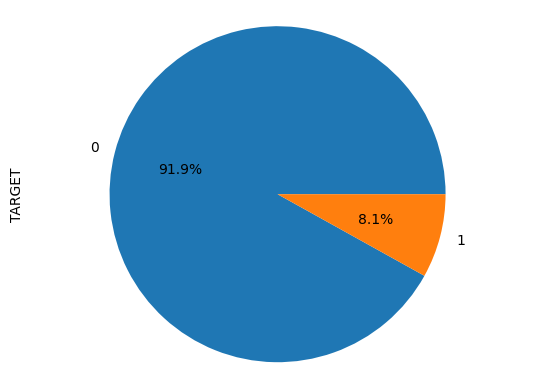

In [15]:
show_basic(app_train, 'Training - Original')

In [16]:
# DAYS_EMPLOYED se define como los días antes de la solicitud en que la persona comenzó su empleo actual
# Por lo tanto, es un valor negativo por naturaleza
# Hay 55374 registros con un valor de 365243
# Asumimos que el atributo no es aplicable para estos registros, por lo que lo establecemos como nulo

len(app_train.loc[app_train['DAYS_EMPLOYED'] == 365243])

55374

In [17]:
# Reemplazo valores faltantes con NULL

set_missing_to_null(app_train, 'Training')


Nombre del conjunto de datos:Training
Reemplazando valores faltantes con NULL...


In [18]:
#show_basic(app_train, 'Training - Cleansed')

In [19]:
#show_basic(app_test, 'Test - Original')

In [20]:
# DAYS_EMPLOYED se define como los días antes de la solicitud en que la persona comenzó su empleo actual
# Por lo tanto, es un valor negativo por naturaleza
# Hay 9274 registros con un valor de 365243
# Asumimo que el atributo no es aplicable para estos registros, por lo que lo establezco como nulo

# Cuento el número de registros en app_test donde DAYS_EMPLOYED es igual a 365243
# Esto identifica casos donde el empleo no es aplicable para establecerlos como nulos después
len(app_test.loc[app_test['DAYS_EMPLOYED'] == 365243])

9274

In [21]:
# Reemplazo los valores faltantes con NULL en el conjunto de datos de prueba (app_test)
# usando la función set_missing_to_null y le asigna la etiqueta 'Test - Original'
set_missing_to_null(app_test, 'Test - Original')


Nombre del conjunto de datos:Test - Original
Reemplazando valores faltantes con NULL...


In [22]:
show_basic(app_test, 'Test - Cleansed')


Data Set Name:Test - Cleansed

Test - Cleansed Number of Rows and Columns:


(48744, 121)


Test - Cleansed First Lines:


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN     AMT_INCOME_TOTAL           AMT_CREDIT  \
0             0           135,000.00           568,800.00   
1             0            99,000.00           222,768.00   
2             0           202,500.00           663,264.00   
3             2           315,000.00         1,575,000.00   
4             1           180,000.00           625,500.00   

           AMT_ANNUITY      AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0            20,560.50           450,000.00   Unaccompanied          Working   
1            17,370.00           180,000.00   Unaccompanied          Working   
2            69,777.00           630,000.00             NaN          Working   
3            49,018.50         1,575,000.00   Unaccompanied          Working   
4            32,067.00           625,500.00   Unaccompanied          Working   

             NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0               Higher education            Married  House / apartment   
1  Secondary / secondary special            Married  House / apartment   
2               Higher education            Married  House / apartment   
3  Secondary / secondary special            Married  House / apartment   
4  Secondary / secondary special            Married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH        DAYS_EMPLOYED  \
0                        0.02      -19241            -2,329.00   
1                        0.04      -18064            -4,469.00   
2                        0.02      -20038            -4,458.00   
3                        0.03      -13976            -1,866.00   
4                        0.01      -13040            -2,191.00   

     DAYS_REGISTRATION  DAYS_ID_PUBLISH          OWN_CAR_AGE  FLAG_MOBIL  \
0            -5,170.00             -812                  NaN           1   
1            -9,118.00            -1623                  NaN           1   
2            -2,175.00            -3503                 5.00           1   
3            -2,000.00            -4208                  NaN           1   
4            -4,000.00            -4262                16.00           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           0           1   
1               1                0                 1           0           0   
2               1                0                 1           0           0   
3               1                0                 1           1           0   
4               1                1                 1           0           0   

      OCCUPATION_TYPE      CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                 NaN                 2.00                     2   
1  Low-skill Laborers                 2.00                     2   
2             Drivers                 2.00                     2   
3         Sales staff                 4.00                     2   
4                 NaN                 3.00                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                   


Test - Cleansed Total Number of Columns: 
(121)

Test - Cleansed Number of Columns with Missing Values: 
(65)

Test - CleansedNumber of Columns with > 50% Missing Values:


29


Test - Cleansed Top 50 Columns with Missing Values:


Missing Values    % of Total Values
COMMONAREA_AVG                         33495                68.72
COMMONAREA_MEDI                        33495                68.72
COMMONAREA_MODE                        33495                68.72
NONLIVINGAPARTMENTS_MODE               33347                68.41
NONLIVINGAPARTMENTS_AVG                33347                68.41
NONLIVINGAPARTMENTS_MEDI               33347                68.41
FONDKAPREMONT_MODE                     32797                67.28
LIVINGAPARTMENTS_AVG                   32780                67.25
LIVINGAPARTMENTS_MODE                  32780                67.25
LIVINGAPARTMENTS_MEDI                  32780                67.25
FLOORSMIN_MODE                         32466                66.61
FLOORSMIN_MEDI                         32466                66.61
FLOORSMIN_AVG                          32466                66.61
OWN_CAR_AGE                            32312                66.29
YEARS_BUILD_MEDI                       31818                65.28
YEARS_BUILD_MODE                       31818                65.28
YEARS_BUILD_AVG                        31818                65.28
LANDAREA_MODE                          28254                57.96
LANDAREA_MEDI                          28254                57.96
LANDAREA_AVG                           28254                57.96
BASEMENTAREA_AVG                       27641                56.71
BASEMENTAREA_MEDI                      27641                56.71
BASEMENTAREA_MODE                      27641                56.71
NONLIVINGAREA_AVG                      26084                53.51
NONLIVINGAREA_MODE                     26084                53.51
NONLIVINGAREA_MEDI                     26084                53.51
ELEVATORS_MEDI                         25189                51.68
ELEVATORS_MODE                         25189                51.68
ELEVATORS_AVG                          25189                51.68
WALLSMATERIAL_MODE                     23893                49.02
APARTMENTS_MEDI                        23887                49.01
APARTMENTS_MODE                        23887                49.01
APARTMENTS_AVG                         23887                49.01
HOUSETYPE_MODE                         23619                48.46
ENTRANCES_MEDI                         23579                48.37
ENTRANCES_AVG                          23579                48.37
ENTRANCES_MODE                         23579                48.37
LIVINGAREA_AVG                         23552                48.32
LIVINGAREA_MODE                        23552                48.32
LIVINGAREA_MEDI                        23552                48.32
FLOORSMAX_AVG                          23321                47.84
FLOORSMAX_MEDI                         23321                47.84
FLOORSMAX_MODE                         23321                47.84
YEARS_BEGINEXPLUATATION_MODE           22856                46.89
YEARS_BEGINEXPLUATATION_MEDI           22856                46.89
YEARS_BEGINEXPLUATATION_AVG            22856                46.89
TOTALAREA_MODE                         22624                46.41
EMERGENCYSTATE_MODE                    22209                45.56
EXT_SOURCE_1                           20532                42.12
OCCUPATION_TYPE                        15605                32.01


Test - Cleansed Number of Columns per Data Type: 


float64    66
int64      39
object     16
Name: count, dtype: int64



Test - Cleansed Column statistics - integer: 



SK_ID_CURR         CNT_CHILDREN           DAYS_BIRTH  \
count            48,744.00            48,744.00            48,744.00   
mean            277,796.68                 0.40           -16,068.08   
std             103,169.55                 0.71             4,325.90   
min             100,001.00                 0.00           -25,195.00   
25%             188,557.75                 0.00           -19,637.00   
50%             277,549.00                 0.00           -15,785.00   
75%             367,555.50                 1.00           -12,496.00   
max             456,250.00                20.00            -7,338.00   

           DAYS_ID_PUBLISH           FLAG_MOBIL       FLAG_EMP_PHONE  \
count            48,744.00            48,744.00            48,744.00   
mean             -3,051.71                 1.00                 0.81   
std               1,569.28                 0.00                 0.39   
min              -6,348.00                 0.00                 0.00   
25%              -4,448.00                 1.00                 1.00   
50%              -3,234.00                 1.00                 1.00   
75%              -1,706.00                 1.00                 1.00   
max                   0.00                 1.00                 1.00   

           FLAG_WORK_PHONE     FLAG_CONT_MOBILE           FLAG_PHONE  \
count            48,744.00            48,744.00            48,744.00   
mean                  0.20                 1.00                 0.26   
std                   0.40                 0.04                 0.44   
min                   0.00                 0.00                 0.00   
25%                   0.00                 1.00                 0.00   
50%                   0.00                 1.00                 0.00   
75%                   0.00                 1.00                 1.00   
max                   1.00                 1.00                 1.00   

                FLAG_EMAIL  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count            48,744.00             48,744.00                    48,744.00   
mean                  0.16                  2.04                         2.01   
std                   0.37                  0.52                         0.52   
min                   0.00                  1.00                        -1.00   
25%                   0.00                  2.00                         2.00   
50%                   0.00                  2.00                         2.00   
75%                   0.00                  2.00                         2.00   
max                   1.00                  3.00                         3.00   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count                48,744.00                   48,744.00   
mean                     12.01                        0.02   
std                       3.28                        0.14   
min                       0.00                        0.00   
25%                      10.00                        0.00   
50%                      12.00                        0.00   
75%                      14.00                        0.00   
max                      23.00                        1.00   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count                   48,744.00                    48,744.00   
mean                         0.06                         0.04   
std                          0.23                         0.20   
min                          0.00                         0.00   
25%                          0.00                         0.00   
50%                          0.00                         0.00   
75%                          0.00                         0.00   
max                          1.00                         1.00   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count               48,744.00               48,744.00   
mean                     0.08                    0.22   
std           


Test - Cleansed Column statistics - float: 



AMT_INCOME_TOTAL           AMT_CREDIT          AMT_ANNUITY  \
count            48,744.00            48,744.00            48,720.00   
mean            178,431.81           516,740.44            29,426.24   
std             101,522.59           365,397.00            16,016.37   
min              26,941.50            45,000.00             2,295.00   
25%             112,500.00           260,640.00            17,973.00   
50%             157,500.00           450,000.00            26,199.00   
75%             225,000.00           675,000.00            37,390.50   
max           4,410,000.00         2,245,500.00           180,576.00   

           AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE        DAYS_EMPLOYED  \
count            48,744.00                   48,744.00            39,470.00   
mean            462,618.84                        0.02            -2,476.74   
std             336,710.22                        0.01             2,307.96   
min              45,000.00                        0.00           -17,463.00   
25%             225,000.00                        0.01            -3,328.75   
50%             396,000.00                        0.02            -1,765.00   
75%             630,000.00                        0.03              -861.00   
max           2,245,500.00                        0.07                -1.00   

         DAYS_REGISTRATION          OWN_CAR_AGE      CNT_FAM_MEMBERS  \
count            48,744.00            16,432.00            48,744.00   
mean             -4,967.65                11.79                 2.15   
std               3,552.61                11.46                 0.89   
min             -23,722.00                 0.00                 1.00   
25%              -7,459.25                 4.00                 2.00   
50%              -4,490.00                 9.00                 2.00   
75%              -1,901.00                15.00                 3.00   
max                   0.00                74.00                21.00   

              EXT_SOURCE_1         EXT_SOURCE_2         EXT_SOURCE_3  \
count            28,212.00            48,736.00            40,076.00   
mean                  0.50                 0.52                 0.50   
std                   0.21                 0.18                 0.19   
min                   0.01                 0.00                 0.00   
25%                   0.34                 0.41                 0.36   
50%                   0.51                 0.56                 0.52   
75%                   0.67                 0.66                 0.65   
max                   0.94                 0.85                 0.88   

            APARTMENTS_AVG     BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
count            24,857.00            21,103.00                    25,888.00   
mean                  0.12                 0.09                         0.98   
std                   0.11                 0.08                         0.05   
min                   0.00                 0.00                         0.00   
25%                   0.06                 0.05                         0.98   
50%                   0.09                 0.08                         0.98   
75%                   0.15                 0.11                         0.99   
max                   1.00                 1.00                         1.00   

           YEARS_BUILD_AVG       COMMONAREA_AVG        ELEVATORS_AVG  \
count            16,926.00            15,249.00            23,555.00   
mean                  0.75                 0.05                 0.09   
std                   0.11                 0.08                 0.14   
min                   0.00                 0.00                 0.00   
25%                   0.69                 0.01                 0.00   
50%                   0.76                 0.02                 0.00   
75%                   0.82                 0.05                 0.16   
max                   1.00                 1.00       


Test - Cleansed Column statistics - object: 



NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count               48744       48744        48744           48744   
unique                  2           2            2               2   
top            Cash loans           F            N               Y   
freq                48305       32678        32311           33658   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count            47833            48744                          48744   
unique               7                7                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq             39727            24533                          33988   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count               48744              48744           33139   
unique                  5                  6              18   
top               Married  House / apartment        Laborers   
freq                32283              43645            8655   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                       48744                   48744              15947   
unique                          7                      58                  4   
top                       TUESDAY  Business Entity Type 3   reg oper account   
freq                         9751                   10840              12124   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count            25125              24851               26535  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq             24659              11269               26179


Test - Cleansed Number of Unique Classes per Object Column: 


NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64



Test - Cleansed Column Name: NAME_CONTRACT_TYPE


Count       Percentage (%)
NAME_CONTRACT_TYPE                            
Cash loans          48305                99.10
Revolving loans       439                 0.90



Test - Cleansed Column Name: CODE_GENDER


Count       Percentage (%)
CODE_GENDER                            
F            32678                67.04
M            16066                32.96



Test - Cleansed Column Name: FLAG_OWN_CAR


Count       Percentage (%)
FLAG_OWN_CAR                            
N             32311                66.29
Y             16433                33.71



Test - Cleansed Column Name: FLAG_OWN_REALTY


Count       Percentage (%)
FLAG_OWN_REALTY                            
Y                33658                69.05
N                15086                30.95



Test - Cleansed Column Name: NAME_TYPE_SUITE


Count       Percentage (%)
NAME_TYPE_SUITE                            
Unaccompanied    39727                81.50
Family            5881                12.07
Spouse, partner   1448                 2.97
Children           408                 0.84
Other_B            211                 0.43
Other_A            109                 0.22
Group of people     49                 0.10



Test - Cleansed Column Name: NAME_INCOME_TYPE


Count       Percentage (%)
NAME_INCOME_TYPE                                
Working               24533                50.33
Commercial associate  11402                23.39
Pensioner              9273                19.02
State servant          3532                 7.25
Student                   2                 0.00
Businessman               1                 0.00
Unemployed                1                 0.00



Test - Cleansed Column Name: NAME_EDUCATION_TYPE


Count       Percentage (%)
NAME_EDUCATION_TYPE                                      
Secondary / secondary special  33988                69.73
Higher education               12516                25.68
Incomplete higher               1724                 3.54
Lower secondary                  475                 0.97
Academic degree                   41                 0.08



Test - Cleansed Column Name: NAME_FAMILY_STATUS


Count       Percentage (%)
NAME_FAMILY_STATUS                              
Married               32283                66.23
Single / not married   7036                14.43
Civil marriage         4261                 8.74
Separated              2955                 6.06
Widow                  2209                 4.53



Test - Cleansed Column Name: NAME_HOUSING_TYPE


Count       Percentage (%)
NAME_HOUSING_TYPE                              
House / apartment    43645                89.54
With parents          2234                 4.58
Municipal apartment   1617                 3.32
Rented apartment       718                 1.47
Office apartment       407                 0.83
Co-op apartment        123                 0.25



Test - Cleansed Column Name: OCCUPATION_TYPE


Count       Percentage (%)
OCCUPATION_TYPE                                  
Laborers                8655                17.76
Sales staff             5072                10.41
Core staff              4361                 8.95
Managers                3574                 7.33
Drivers                 2773                 5.69
High skill tech staff   1854                 3.80
Accountants             1628                 3.34
Medicine staff          1316                 2.70
Security staff           915                 1.88
Cooking staff            894                 1.83
Cleaning staff           656                 1.35
Private service staff    455                 0.93
Low-skill Laborers       272                 0.56
Secretaries              213                 0.44
Waiters/barmen staff     178                 0.37
Realty agents            138                 0.28
HR staff                 104                 0.21
IT staff                  81                 0.17



Test - Cleansed Column Name: WEEKDAY_APPR_PROCESS_START


Count       Percentage (%)
WEEKDAY_APPR_PROCESS_START                            
TUESDAY                      9751                20.00
WEDNESDAY                    8457                17.35
THURSDAY                     8418                17.27
MONDAY                       8406                17.25
FRIDAY                       7250                14.87
SATURDAY                     4603                 9.44
SUNDAY                       1859                 3.81



Test - Cleansed Column Name: ORGANIZATION_TYPE


Count       Percentage (%)
ORGANIZATION_TYPE                                 
Business Entity Type 3  10840                22.24
XNA                      9274                19.03
Self-employed            5920                12.15
Other                    2707                 5.55
Medicine                 1716                 3.52
Government               1508                 3.09
Business Entity Type 2   1479                 3.03
Trade: type 7            1303                 2.67
School                   1287                 2.64
Construction             1039                 2.13
Kindergarten             1038                 2.13
Business Entity Type 1    887                 1.82
Transport: type 4         884                 1.81
Trade: type 3             578                 1.19
Military                  530                 1.09
Industry: type 9          499                 1.02
Industry: type 3          489                 1.00
Security                  472                 0.97
Transport: type 2         448                 0.92
Police                    441                 0.90
Housing                   435                 0.89
Industry: type 11         416                 0.85
Bank                      374                 0.77
Security Ministries       341                 0.70
Services                  302                 0.62
Postal                    294                 0.60
Agriculture               292                 0.60
Restaurant                284                 0.58
Trade: type 2             242                 0.50
University                221                 0.45
Industry: type 7          217                 0.45
Industry: type 1          178                 0.37
Transport: type 3         174                 0.36
Industry: type 4          167                 0.34
Electricity               156                 0.32
Hotel                     134                 0.27
Trade: type 6             122                 0.25
Industry: type 5           97                 0.20
Telecom                    95                 0.19
Emergency                  91                 0.19
Insurance                  80                 0.16
Industry: type 2           77                 0.16
Industry: type 12          77                 0.16
Realtor                    72                 0.15
Advertising                71                 0.15
Trade: type 1              64                 0.13
Culture                    61                 0.13
Legal Services             53                 0.11
Mobile                     45                 0.09
Cleaning                   43                 0.09
Transport: type 1          35                 0.07
Industry: type 6           27                 0.06
Industry: type 10          24                 0.05
Trade: type 4              14                 0.03
Religion                   12                 0.02
Trade: type 5               9                 0.02
Industry: type 13           6                 0.01
Industry: type 8            3                 0.01



Test - Cleansed Column Name: FONDKAPREMONT_MODE


Count       Percentage (%)
FONDKAPREMONT_MODE                               
reg oper account       12124                24.87
reg oper spec account   1990                 4.08
org spec account         920                 1.89
not specified            913                 1.87



Test - Cleansed Column Name: HOUSETYPE_MODE


Count       Percentage (%)
HOUSETYPE_MODE                              
block of flats    24659                50.59
specific housing    262                 0.54
terraced house      204                 0.42



Test - Cleansed Column Name: WALLSMATERIAL_MODE


Count       Percentage (%)
WALLSMATERIAL_MODE                            
Panel               11269                23.12
Stone, brick        10434                21.41
Block                1428                 2.93
Wooden                794                 1.63
Mixed                 353                 0.72
Monolithic            289                 0.59
Others                284                 0.58



Test - Cleansed Column Name: EMERGENCYSTATE_MODE


Count       Percentage (%)
EMERGENCYSTATE_MODE                            
No                   26179                53.71
Yes                    356                 0.73

In [23]:
#show_basic(app_bureau, 'Bureau')

In [24]:
#show_basic(app_bureau_balance, 'Bureau Balance - Original')

In [25]:
# STATUS = X significa desconocido así que lo establecemos como nulo

# Cuenta el número de registros en app_bureau_balance donde STATUS es igual a 'X'
# Esto identifica los casos donde el estado es desconocido para establecerlos como nulos después
len(app_bureau_balance.loc[app_bureau_balance['STATUS'] == 'X'])

5810482

In [26]:
set_missing_to_null(app_bureau_balance, 'Bureau Balance - Original')


Nombre del conjunto de datos:Bureau Balance - Original
Reemplazando valores faltantes con NULL...


In [27]:
#show_basic(app_bureau_balance, 'Bureau Balance - Cleansed')

In [28]:
#show_basic(app_previous_application, 'Previous Application - Original')

In [29]:
# Reemplazar valores faltantes con NULL

set_missing_to_null(app_previous_application, 'Previous Application')


Nombre del conjunto de datos:Previous Application
Reemplazando valores faltantes con NULL...


In [30]:
#show_basic(app_previous_application, 'Previous Application - Cleansed')

In [31]:
#show_basic(app_credit_card_balance, 'Credit Card Balance')

In [32]:
#show_basic(app_installments_payments, 'Installments Payments')

In [33]:
#show_basic(app_pos_cash_balance, 'POS Cash Balance - Original')

In [34]:
# Reemplazar valores faltantes con NULL

set_missing_to_null(app_pos_cash_balance, 'POS Cash Balance')


Nombre del conjunto de datos:POS Cash Balance
Reemplazando valores faltantes con NULL...


In [35]:
#show_basic(app_pos_cash_balance, 'POS Cash Balance - Cleansed')

## II - Análisis Exploratorio de Datos (AED)
Utilizaremos nuestra función auxiliar para mostrar información básica de cada conjunto de datos.
 
Mostraremos que en el conjunto de datos de entrenamiento:

- Las **puntuaciones normalizadas de fuentes de datos externas** (ext_source_1, ext_source_2, ext_source_3) muestran las correlaciones negativas más fuertes con el objetivo, aunque estas correlaciones son muy débiles. Cuanto mayor sea la puntuación, más probable será que un solicitante devuelva el préstamo.
- La **edad** de los solicitantes parece influir en la tasa de impago. Los solicitantes más jóvenes (21-25 años) tienen tasas de impago de hasta el 14%, tasas que disminuyen constantemente en solicitantes mayores, por debajo del 6% para mayores de 54 años.
 
- Hay algunas diferencias relacionadas con el **género** de los solicitantes:
- Las solicitantes mujeres solicitan en promedio préstamos ligeramente más pequeños.
- Las solicitantes mujeres más que duplican a los solicitantes hombres y tienen tasas de impago más bajas.


In [36]:
# Muestra las correlaciones entre las variables del conjunto de datos de entrenamiento (app_train)
# usando la función show_correlations() que visualiza las relaciones entre las variables
# y la variable objetivo (TARGET)
# Convertir columnas categóricas a numéricas antes de calcular correlaciones
app_train_numeric = app_train.select_dtypes(include=['int64', 'float64'])

# Mostrar correlaciones con la variable objetivo
show_correlations(app_train_numeric, 'Training')


Nombre del conjunto de datos:Training


Correlaciones más negativas:
 EXT_SOURCE_3                                -0.18
EXT_SOURCE_2                                -0.16
EXT_SOURCE_1                                -0.16
FLOORSMAX_AVG                               -0.04
FLOORSMAX_MEDI                              -0.04
FLOORSMAX_MODE                              -0.04
AMT_GOODS_PRICE                             -0.04
REGION_POPULATION_RELATIVE                  -0.04
ELEVATORS_AVG                               -0.03
ELEVATORS_MEDI                              -0.03
FLOORSMIN_AVG                               -0.03
FLOORSMIN_MEDI                              -0.03
LIVINGAREA_AVG                              -0.03
LIVINGAREA_MEDI                             -0.03
FLOORSMIN_MODE                              -0.03
TOTALAREA_MODE                              -0.03
ELEVATORS_MODE                              -0.03
LIVINGAREA_MODE                             -0.03
AMT_CREDIT                   

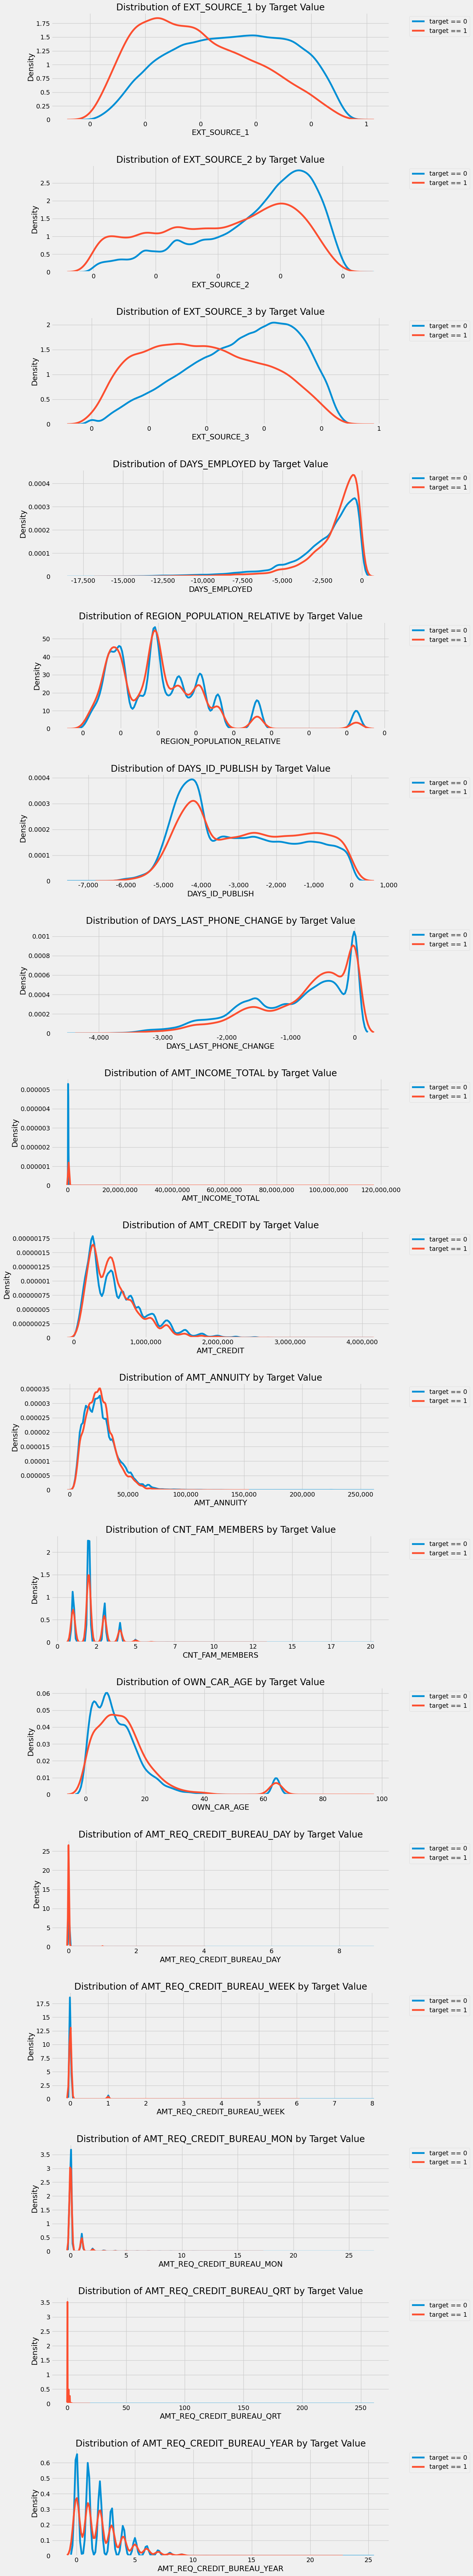

In [37]:
# Dibujar distribución para columnas seleccionadas
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15, 80))
filter_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'OWN_CAR_AGE','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']
def format_number(x, p):
    """º
    Función para formatear todos los números en formato decimal completo:
    - Si es 0, muestra '0'
    - Para cualquier otro valor, muestra el formato decimal completo
    """
    
    if x == 0:
        return '0'
    elif x < 0.0001:
        # Para números muy pequeños, mostrar formato decimal completo
        return '{:.8f}'.format(x).rstrip('0').rstrip('.') if '.' in '{:.8f}'.format(x) else '{:.8f}'.format(x)
    else:
        # Para otros números, también usar formato decimal
        return '{:.6f}'.format(x).rstrip('0').rstrip('.') if '.' in '{:.6f}'.format(x) else '{:.6f}'.format(x)

for i, feature in enumerate(filter_cols):
    ax = plt.subplot(len(filter_cols), 1, i + 1)
    
    # Graficar préstamos pagados
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], 
                label = 'target == 0')
    # Graficar préstamos no pagados
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], 
                label = 'target == 1')
    
    # Formatear los números del eje x
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Formatear los números del eje y con la nueva función
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_number))
    
    # Asegurar que la leyenda aparezca y ajustar su posición
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')

plt.tight_layout(h_pad = 3.0)

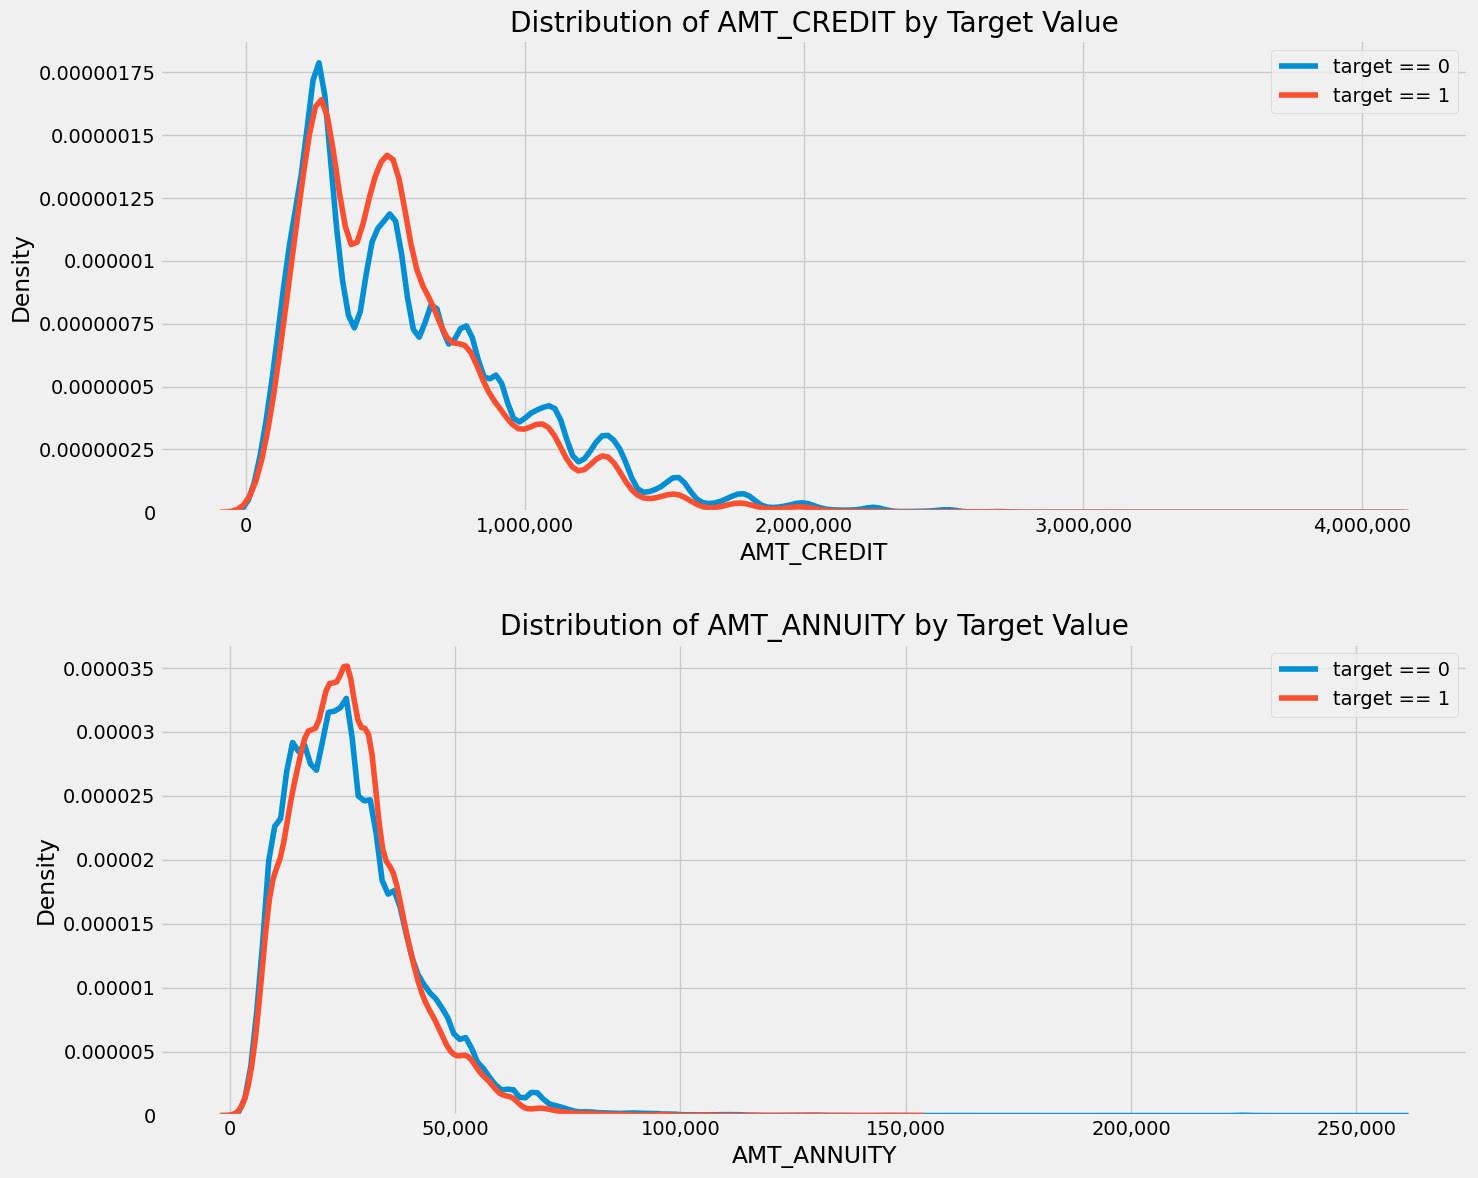

In [38]:
# Graficar distribución para monto de crédito, anualidad e ingresos

plt.style.use('fivethirtyeight')
plt.figure(figsize = (15, 12))  # Aumentado el tamaño para mejor visualización

def format_number(x, p):
    """
    Función para formatear todos los números en formato decimal completo
    """
    if x == 0:
        return '0'
    elif x < 0.0001:
        # Para números muy pequeños, mostrar formato decimal completo
        return '{:.8f}'.format(x).rstrip('0').rstrip('.') if '.' in '{:.8f}'.format(x) else '{:.8f}'.format(x)
    else:
        # Para otros números, también usar formato decimal
        return '{:.6f}'.format(x).rstrip('0').rstrip('.') if '.' in '{:.6f}'.format(x) else '{:.6f}'.format(x)

# Iterar a través de las características
filter_cols = ['AMT_CREDIT', 'AMT_ANNUITY']
for i, feature in enumerate(filter_cols):
    
    # Crear un nuevo subgráfico para cada fuente
    ax = plt.subplot(len(filter_cols), 1, i + 1)
    
    # Graficar préstamos pagados
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], 
                 label = 'target == 0')
    
    # Graficar préstamos no pagados
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], 
                label = 'target == 1')
    
    # Formatear los números del eje x
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Formatear los números del eje y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_number))
    
    # Asegurar que la leyenda aparezca
    plt.legend(loc='upper right')
    
    # Etiquetar los gráficos
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')

    
plt.tight_layout(h_pad = 2.5)


Data Set Name:Credit Bureau Request

Credit Bureau Request Column Name: AMT_REQ_CREDIT_BUREAU_YEAR_RANGE



Count       Percentage (%)   Paid  \
AMT_REQ_CREDIT_BUREAU_YEAR_RANGE                                      
5 or More                         67771                22.04  61173   
4.0                               20714                 6.74  19004   
2.0                               50192                16.32  46124   
3.0                               33628                10.94  30952   
1.0                               63405                20.62  58755   
0.0                               71801                23.35  66678   

                                             Paid (%)  Unpaid  \
AMT_REQ_CREDIT_BUREAU_YEAR_RANGE                                
5 or More                                       90.26    6598   
4.0                                             91.74    1710   
2.0                                             91.90    4068   
3.0                                             92.04    2676   
1.0                                             92.67    4650   
0.0                                             92.87    5123   

                                     Default Rate (%)  
AMT_REQ_CREDIT_BUREAU_YEAR_RANGE                       
5 or More                                        9.74  
4.0                                              8.26  
2.0                                              8.10  
3.0                                              7.96  
1.0                                              7.33  
0.0                                              7.13

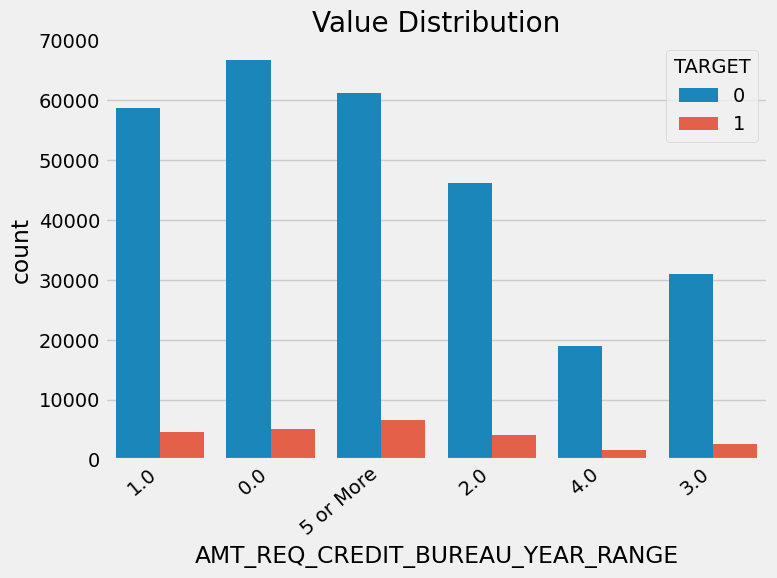

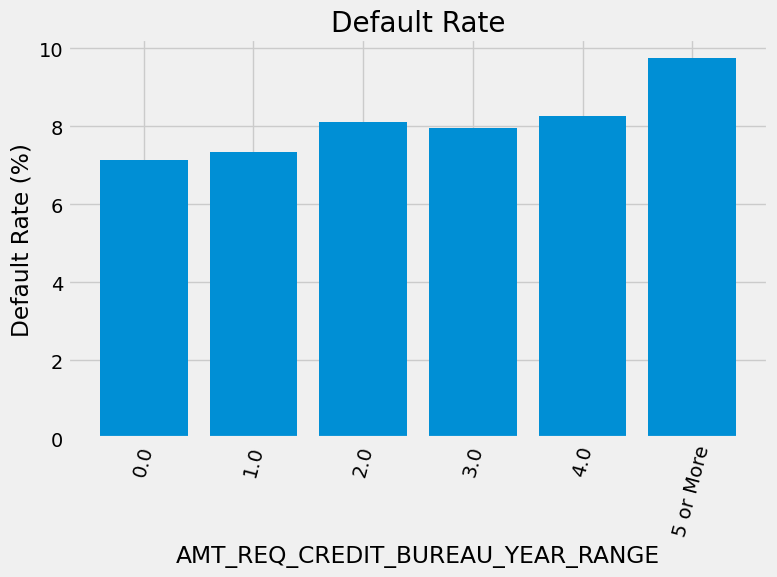

In [39]:
# Datos de solicitudes al buró de crédito

app_train['AMT_REQ_CREDIT_BUREAU_YEAR_RANGE'] = app_train['AMT_REQ_CREDIT_BUREAU_YEAR'].map(lambda x: str(x) if x  < 5 else "5 or More" )

show_default_rate(app_train.loc[:,['AMT_REQ_CREDIT_BUREAU_YEAR_RANGE', 'TARGET']], 'Credit Bureau Request')

# Eliminar las columnas de rango
filter_cols = ['AMT_REQ_CREDIT_BUREAU_YEAR_RANGE_RANGE']


Data Set Name:Geographical

Geographical Column Name: REGION_RATING_CLIENT



Count       Percentage (%)    Paid  \
REGION_RATING_CLIENT                                        
3                      48330                15.72   42964   
2                     226984                73.81  209077   
1                      32197                10.47   30645   

                                 Paid (%)  Unpaid     Default Rate (%)  
REGION_RATING_CLIENT                                                    
3                                   88.90    5366                11.10  
2                                   92.11   17907                 7.89  
1                                   95.18    1552                 4.82

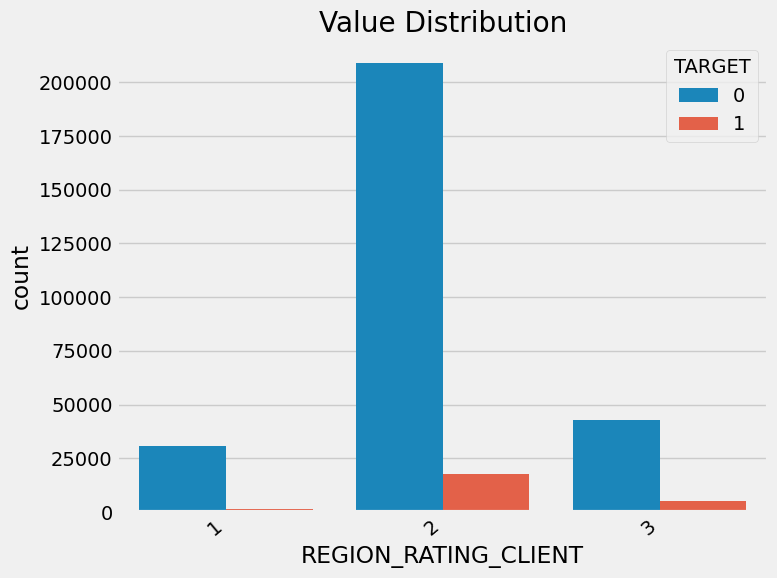

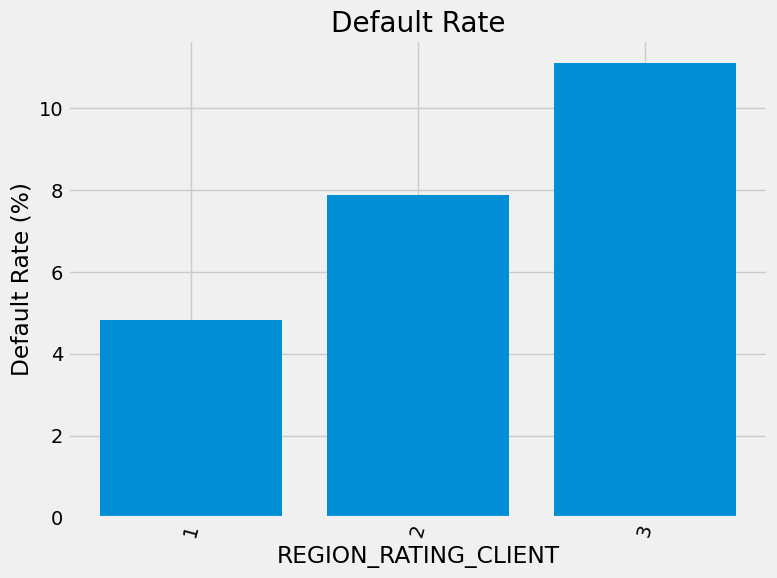


Geographical Column Name: REGION_RATING_CLIENT_W_CITY



Count       Percentage (%)    Paid  \
REGION_RATING_CLIENT_W_CITY                                        
3                             43860                14.26   38859   
2                            229484                74.63  211314   
1                             34167                11.11   32513   

                                        Paid (%)  Unpaid     Default Rate (%)  
REGION_RATING_CLIENT_W_CITY                                                    
3                                          88.60    5001                11.40  
2                                          92.08   18170                 7.92  
1                                          95.16    1654                 4.84

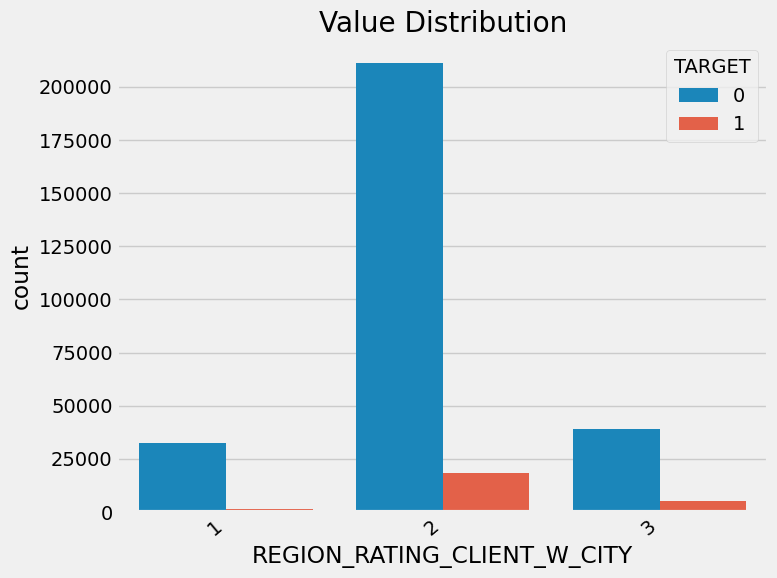

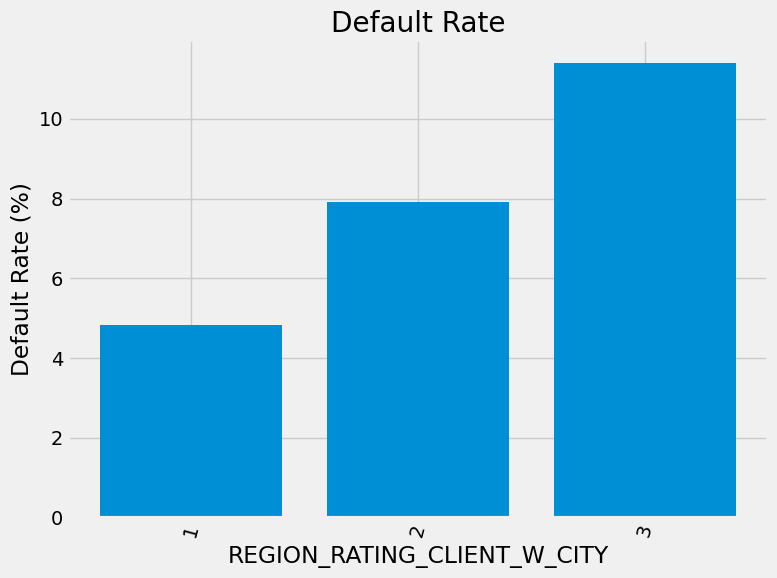


Geographical Column Name: REG_REGION_NOT_LIVE_REGION



Count       Percentage (%)    Paid  \
REG_REGION_NOT_LIVE_REGION                                        
1                             4657                 1.51    4224   
0                           302854                98.49  278462   

                                       Paid (%)  Unpaid     Default Rate (%)  
REG_REGION_NOT_LIVE_REGION                                                    
1                                         90.70     433                 9.30  
0                                         91.95   24392                 8.05

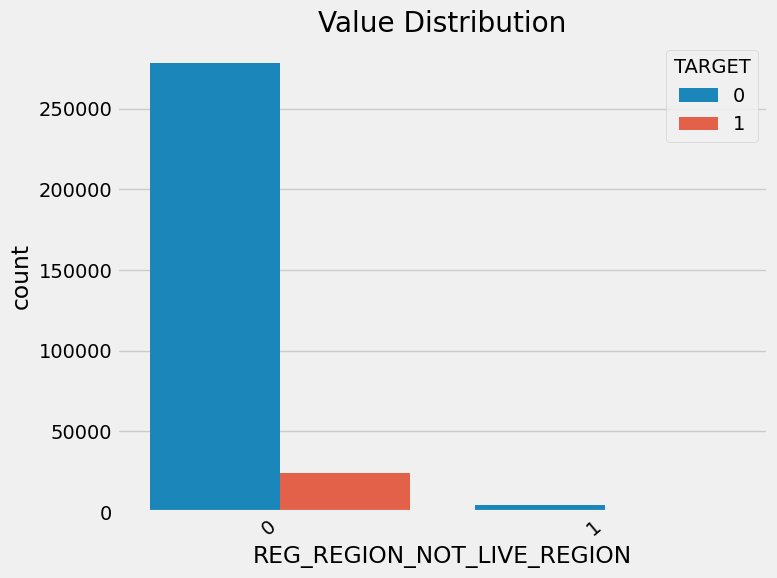

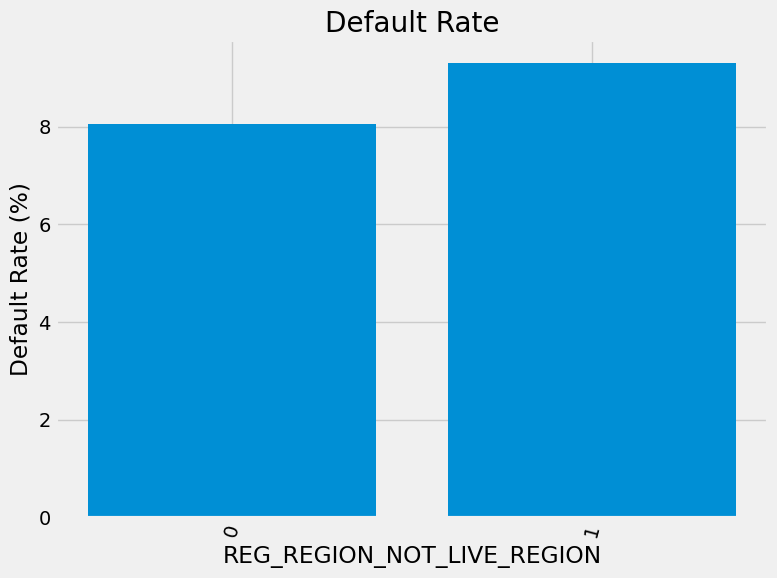


Geographical Column Name: REG_REGION_NOT_WORK_REGION



Count       Percentage (%)    Paid  \
REG_REGION_NOT_WORK_REGION                                        
1                            15612                 5.08   14224   
0                           291899                94.92  268462   

                                       Paid (%)  Unpaid     Default Rate (%)  
REG_REGION_NOT_WORK_REGION                                                    
1                                         91.11    1388                 8.89  
0                                         91.97   23437                 8.03

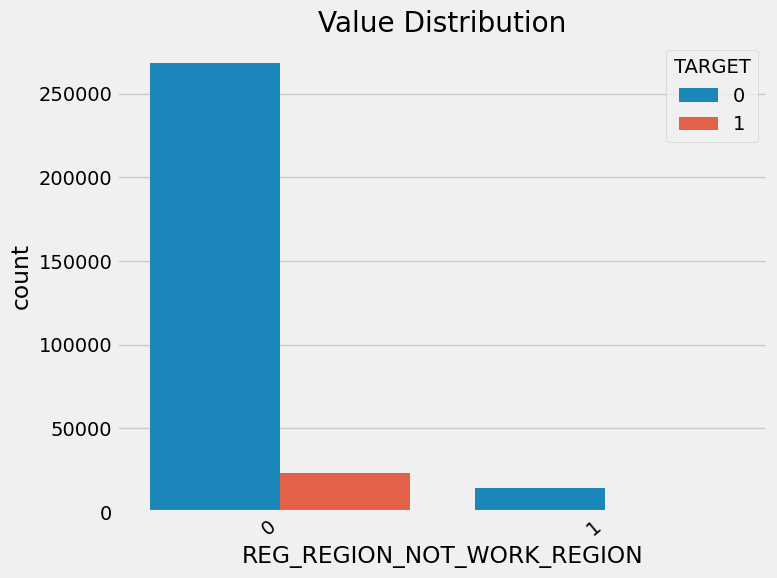

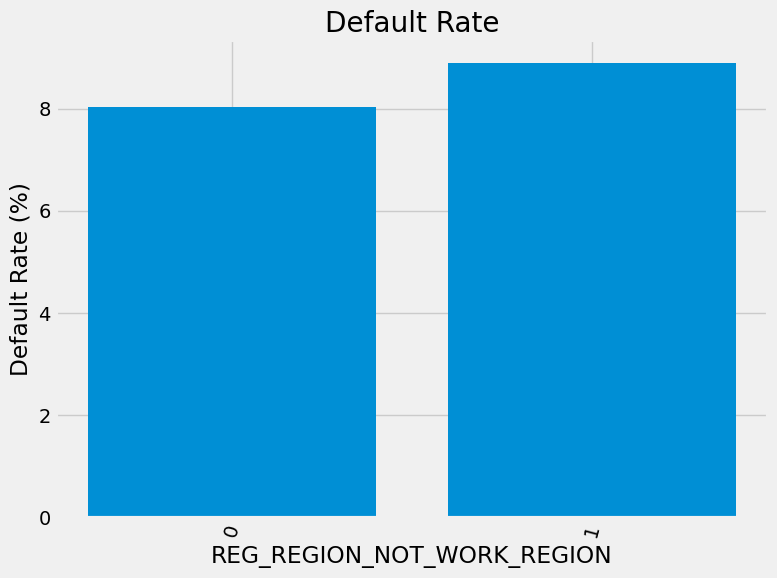


Geographical Column Name: LIVE_REGION_NOT_WORK_REGION



Count       Percentage (%)    Paid  \
LIVE_REGION_NOT_WORK_REGION                                        
1                             12503                 4.07   11447   
0                            295008                95.93  271239   

                                        Paid (%)  Unpaid     Default Rate (%)  
LIVE_REGION_NOT_WORK_REGION                                                    
1                                          91.55    1056                 8.45  
0                                          91.94   23769                 8.06

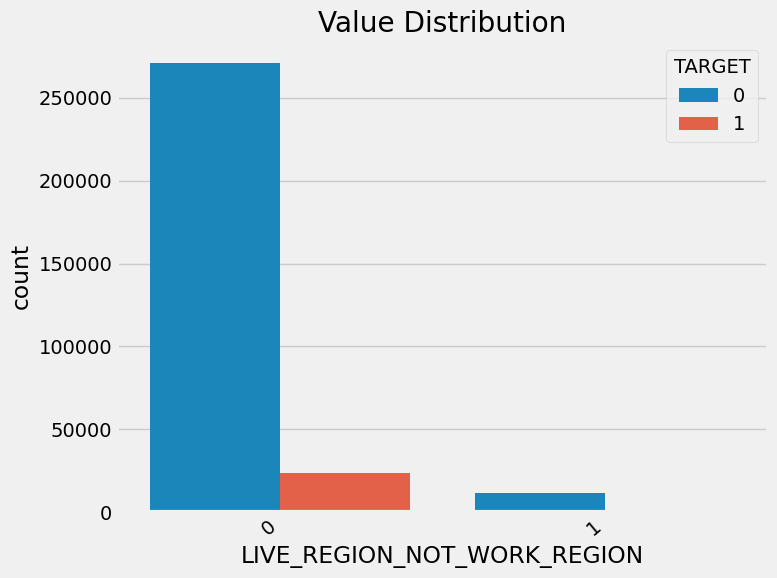

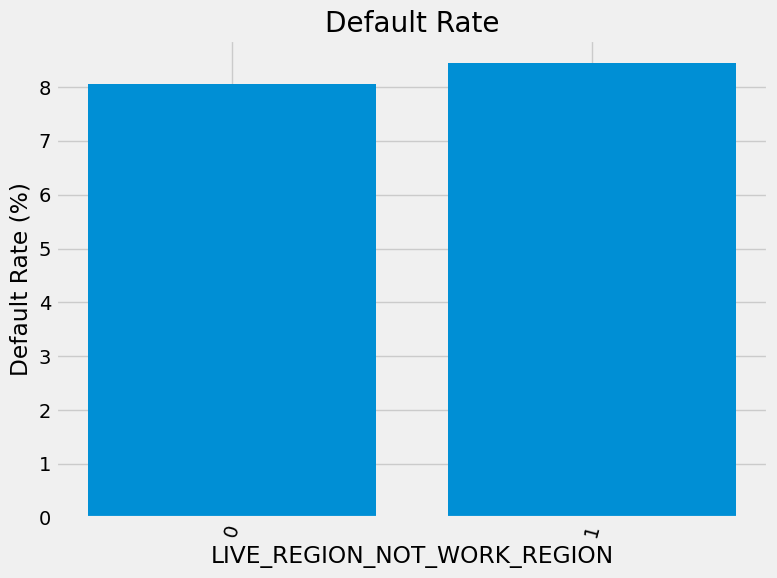


Geographical Column Name: REG_CITY_NOT_LIVE_CITY



Count       Percentage (%)    Paid  \
REG_CITY_NOT_LIVE_CITY                                        
1                        24039                 7.82   21100   
0                       283472                92.18  261586   

                                   Paid (%)  Unpaid     Default Rate (%)  
REG_CITY_NOT_LIVE_CITY                                                    
1                                     87.77    2939                12.23  
0                                     92.28   21886                 7.72

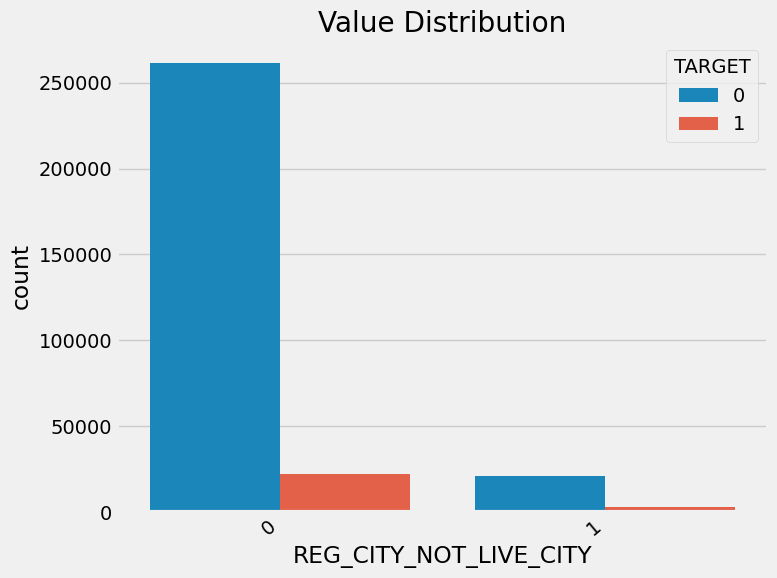

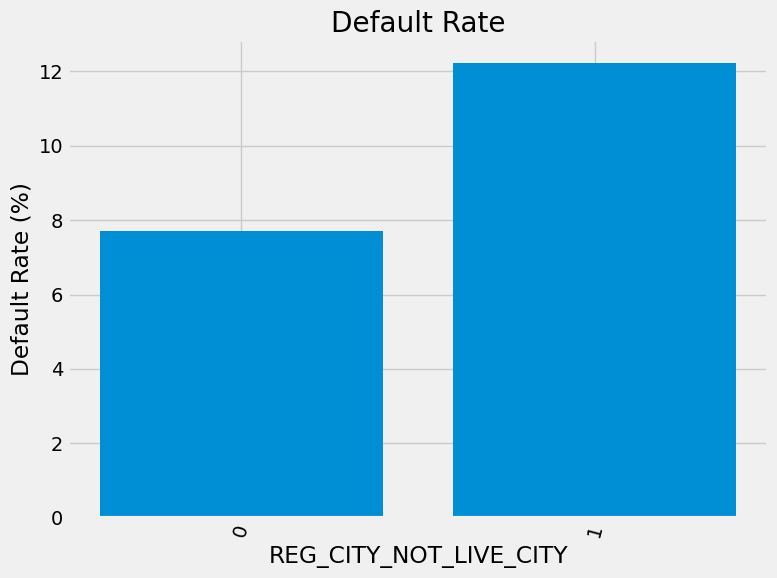


Geographical Column Name: REG_CITY_NOT_WORK_CITY



Count       Percentage (%)    Paid  \
REG_CITY_NOT_WORK_CITY                                        
1                        70867                23.05   63347   
0                       236644                76.95  219339   

                                   Paid (%)  Unpaid     Default Rate (%)  
REG_CITY_NOT_WORK_CITY                                                    
1                                     89.39    7520                10.61  
0                                     92.69   17305                 7.31

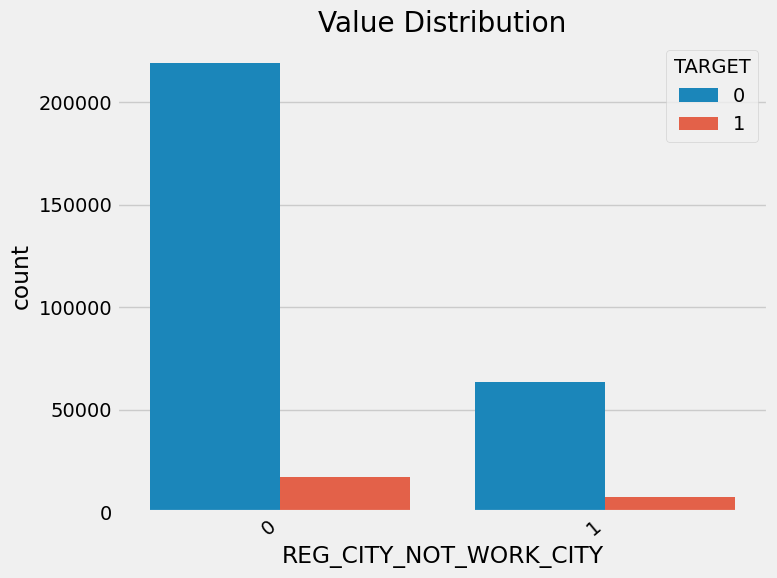

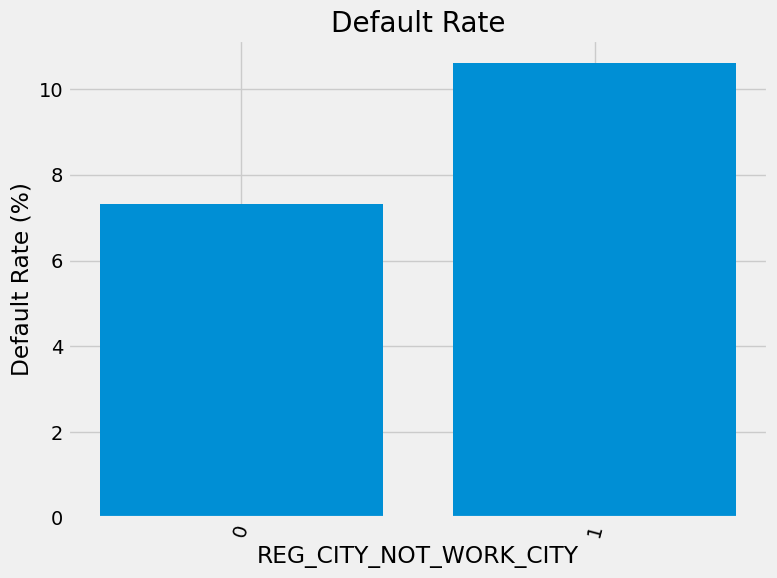


Geographical Column Name: LIVE_CITY_NOT_WORK_CITY



Count       Percentage (%)    Paid  \
LIVE_CITY_NOT_WORK_CITY                                        
1                         55215                17.96   49712   
0                        252296                82.04  232974   

                                    Paid (%)  Unpaid     Default Rate (%)  
LIVE_CITY_NOT_WORK_CITY                                                    
1                                      90.03    5503                 9.97  
0                                      92.34   19322                 7.66

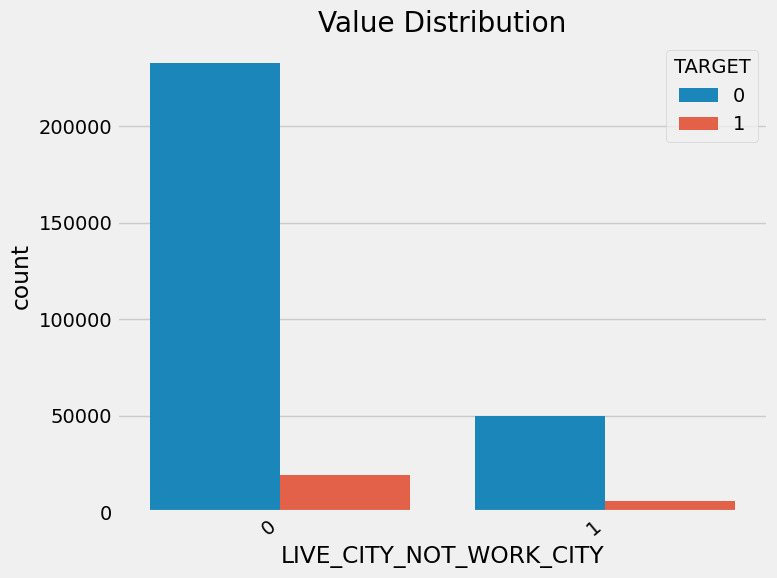

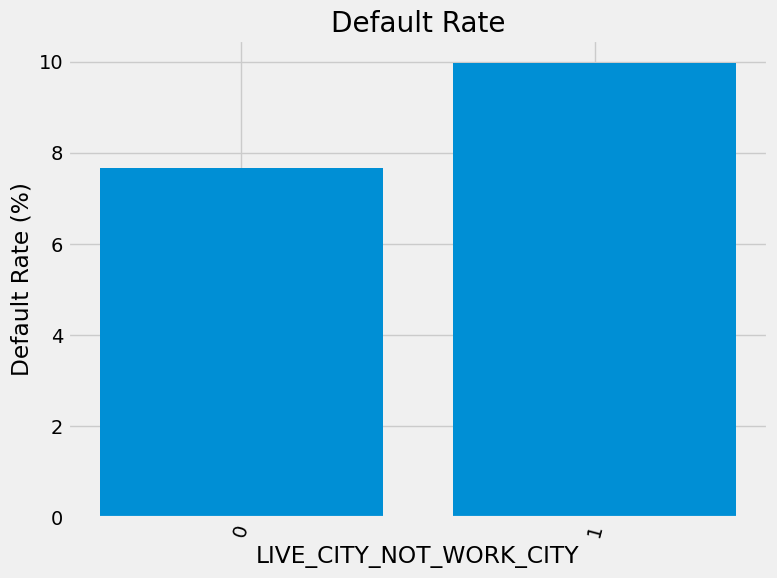

In [40]:
# Datos geográficos

filter_cols = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

geographical_data = app_train[filter_cols].astype("category")

geographical_data['TARGET'] = app_train['TARGET']

show_default_rate(geographical_data, 'Geographical')


Data Set Name:Contact

Contact Column Name: FLAG_MOBIL



Count       Percentage (%)    Paid             Paid (%)  Unpaid  \
FLAG_MOBIL                                                                     
1           307510               100.00  282685                91.93   24825   
0                1                 0.00       1               100.00       0   

               Default Rate (%)  
FLAG_MOBIL                       
1                          8.07  
0                          0.00

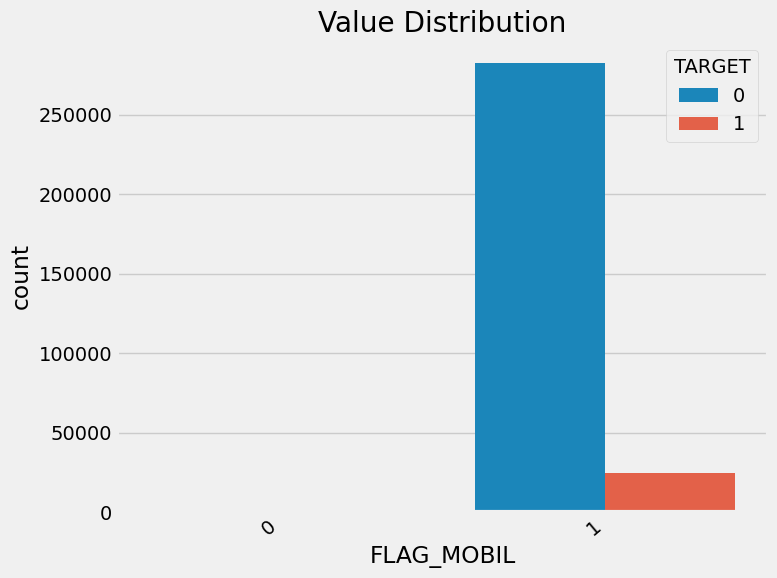

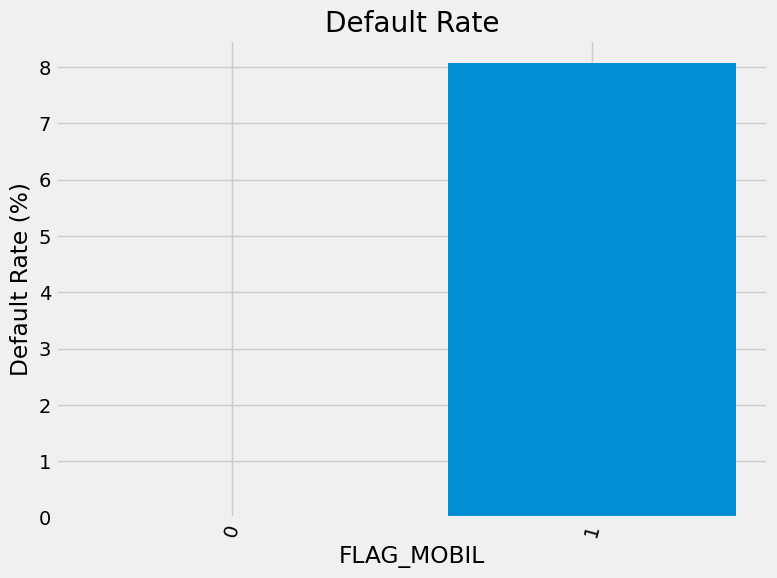


Contact Column Name: FLAG_EMP_PHONE



Count       Percentage (%)    Paid             Paid (%)  \
FLAG_EMP_PHONE                                                             
1               252125                81.99  230291                91.34   
0                55386                18.01   52395                94.60   

                Unpaid     Default Rate (%)  
FLAG_EMP_PHONE                               
1                21834                 8.66  
0                 2991                 5.40

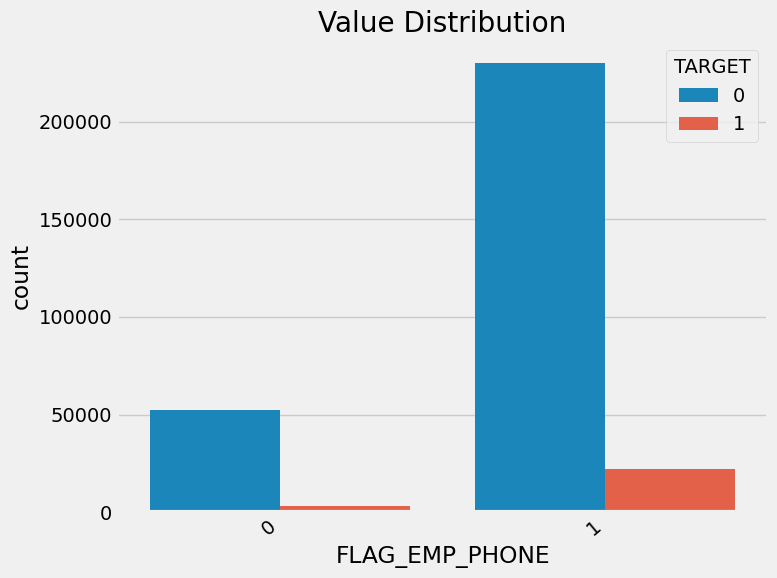

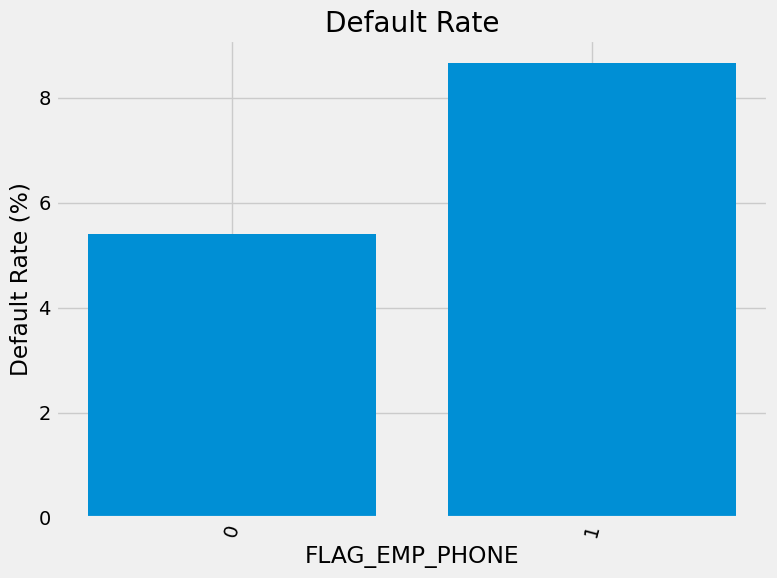


Contact Column Name: FLAG_WORK_PHONE



Count       Percentage (%)    Paid             Paid (%)  \
FLAG_WORK_PHONE                                                             
1                 61308                19.94   55404                90.37   
0                246203                80.06  227282                92.31   

                 Unpaid     Default Rate (%)  
FLAG_WORK_PHONE                               
1                  5904                 9.63  
0                 18921                 7.69

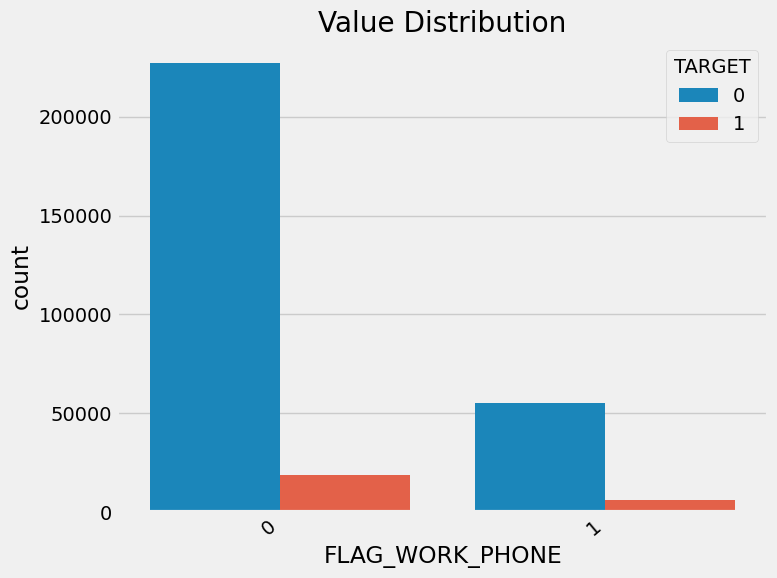

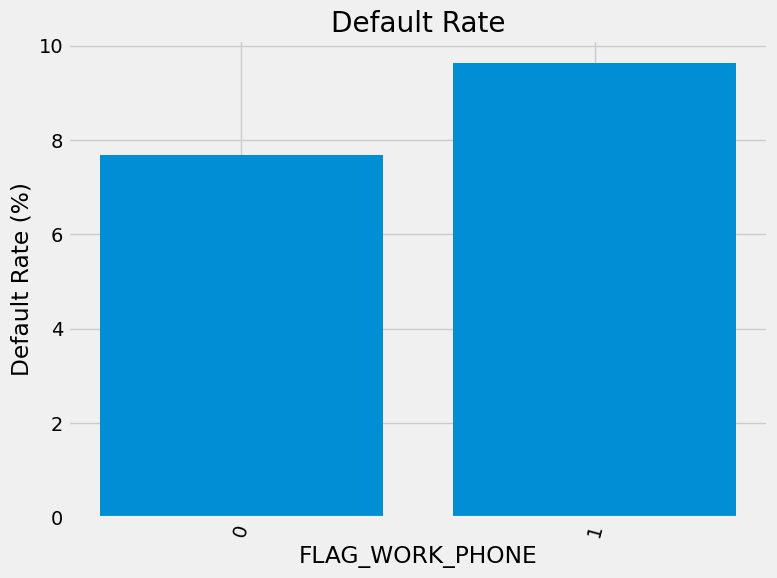


Contact Column Name: FLAG_CONT_MOBILE



Count       Percentage (%)    Paid             Paid (%)  \
FLAG_CONT_MOBILE                                                             
1                 306937                99.81  282157                91.93   
0                    574                 0.19     529                92.16   

                  Unpaid     Default Rate (%)  
FLAG_CONT_MOBILE                               
1                  24780                 8.07  
0                     45                 7.84

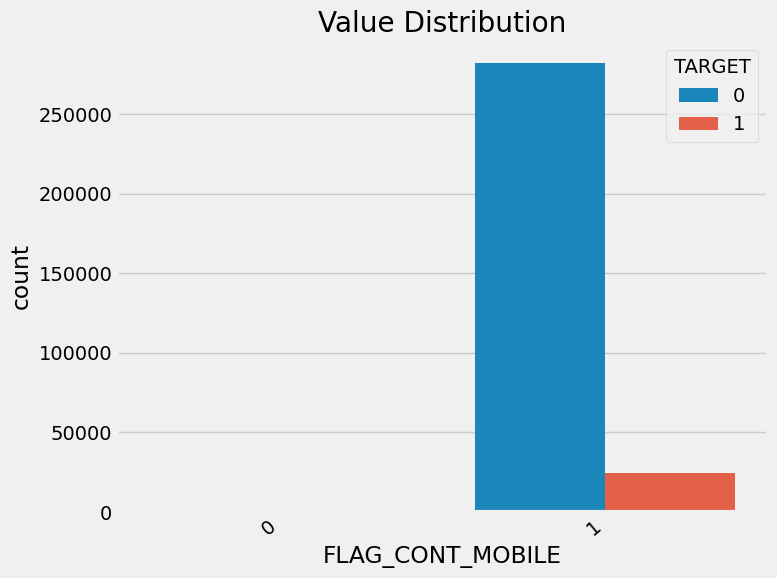

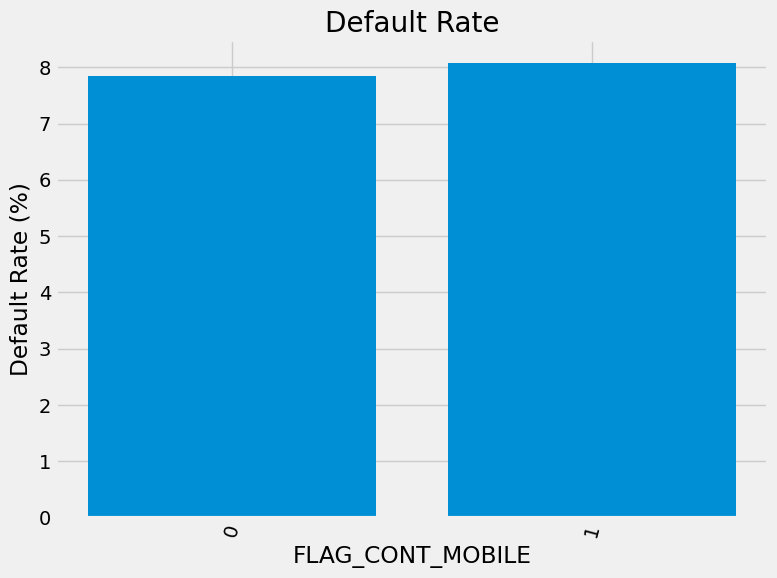


Contact Column Name: FLAG_PHONE



Count       Percentage (%)    Paid             Paid (%)  Unpaid  \
FLAG_PHONE                                                                     
0           221080                71.89  202336                91.52   18744   
1            86431                28.11   80350                92.96    6081   

               Default Rate (%)  
FLAG_PHONE                       
0                          8.48  
1                          7.04

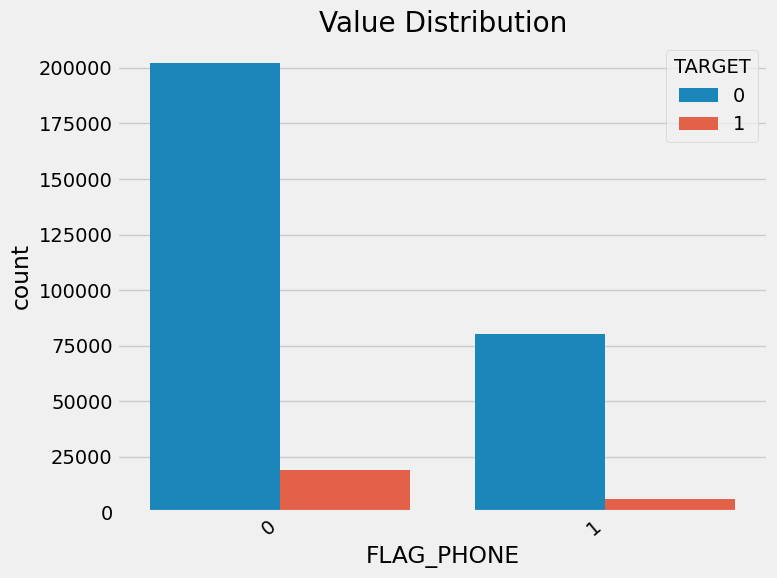

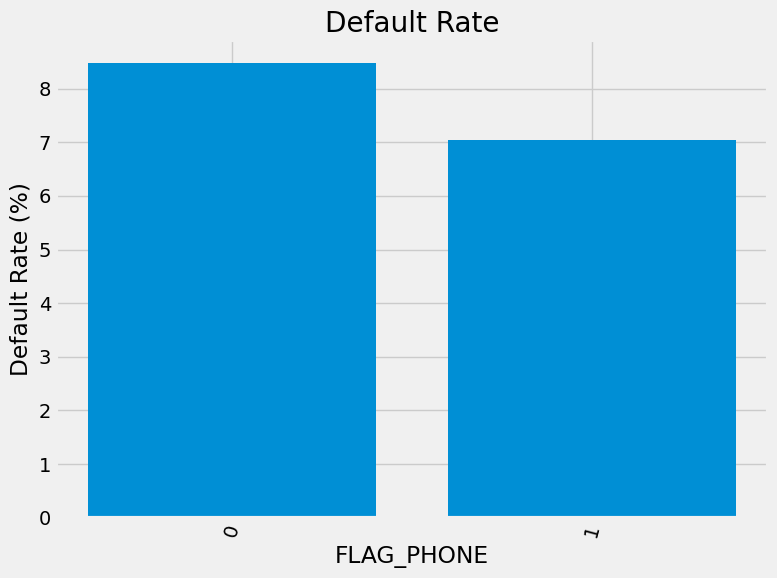


Contact Column Name: FLAG_EMAIL



Count       Percentage (%)    Paid             Paid (%)  Unpaid  \
FLAG_EMAIL                                                                     
0           290069                94.33  266618                91.92   23451   
1            17442                 5.67   16068                92.12    1374   

               Default Rate (%)  
FLAG_EMAIL                       
0                          8.08  
1                          7.88

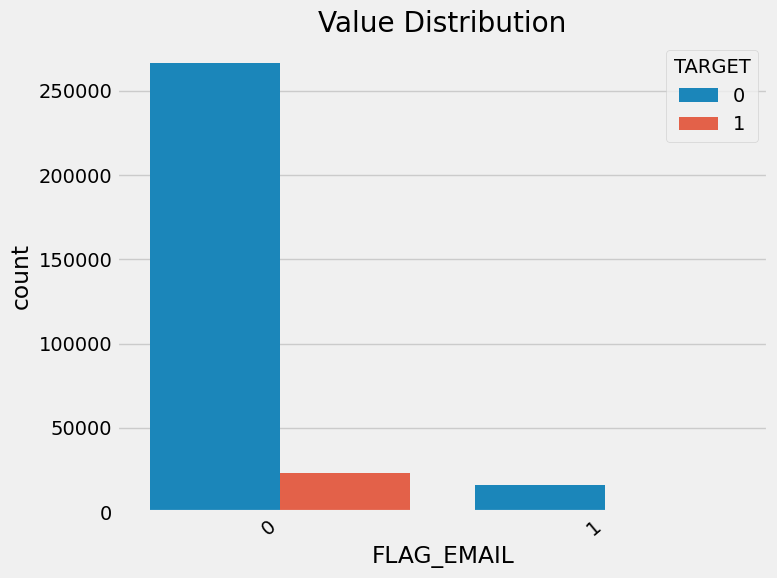

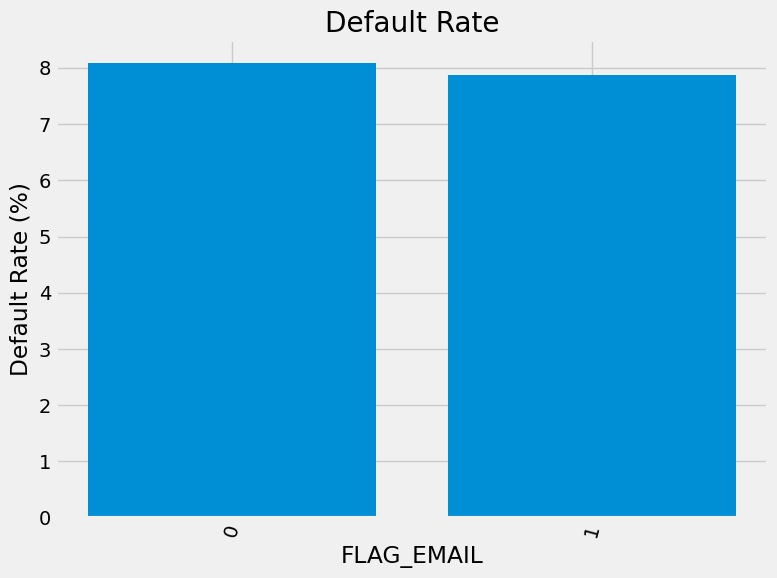

In [41]:
# Datos de contacto

filter_cols = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']

contact_data = app_train[filter_cols].astype("category")

contact_data['TARGET'] = app_train['TARGET']

show_default_rate(contact_data, 'Contact')


Data Set Name:Income Level

Income Level Column Name: INCOME_AMT_RANGE



Count       Percentage (%)   Paid             Paid (%)  \
INCOME_AMT_RANGE                                                           
< 100000          43701                14.21  39860                91.21   
< 150000          34663                11.27  31685                91.41   
< 125000          47890                15.57  43837                91.54   
< 75000           39806                12.94  36450                91.57   
< 175000          29644                 9.64  27190                91.72   
< 50000           19375                 6.30  17849                92.12   
< 200000          40797                13.27  37595                92.15   
< 25000            4517                 1.47   4174                92.41   
< 225000          44416                14.44  41490                93.41   
< 500000           2693                 0.88   2548                94.62   

                  Unpaid     Default Rate (%)  
INCOME_AMT_RANGE                               
< 100000            3841                 8.79  
< 150000            2978                 8.59  
< 125000            4053                 8.46  
< 75000             3356                 8.43  
< 175000            2454                 8.28  
< 50000             1526                 7.88  
< 200000            3202                 7.85  
< 25000              343                 7.59  
< 225000            2926                 6.59  
< 500000             145                 5.38

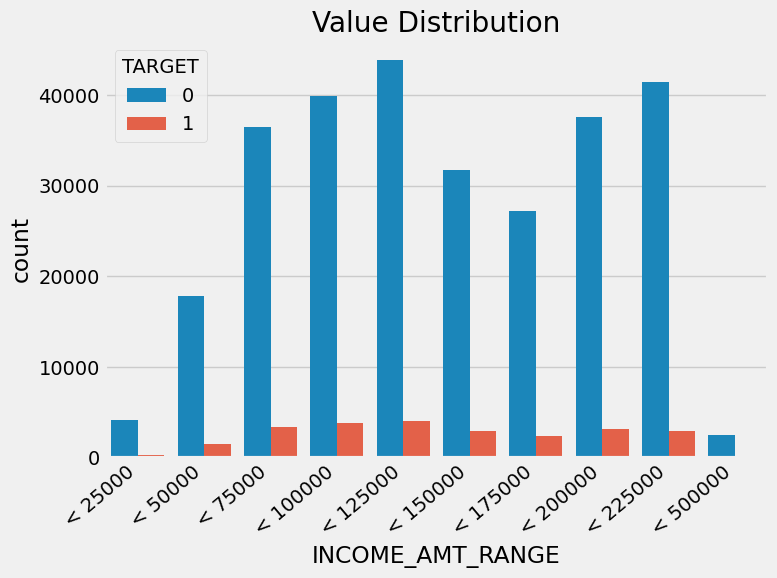

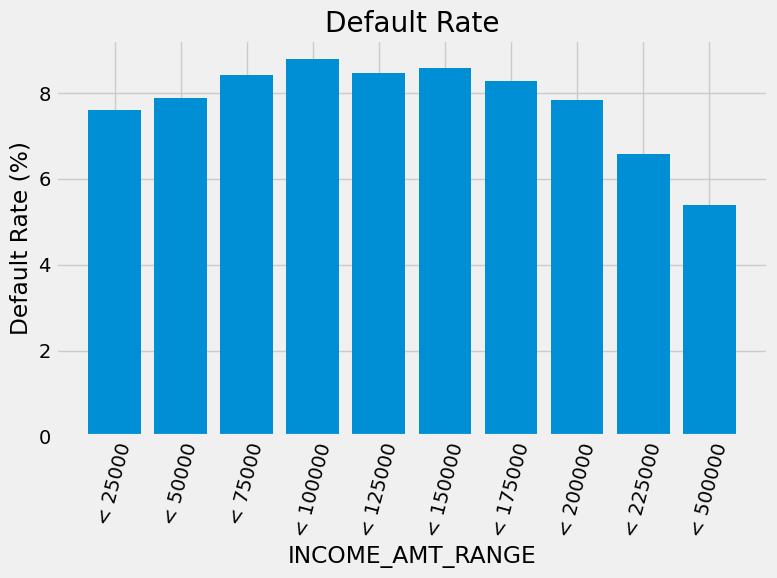

In [42]:
# Ingresos

bins = np.linspace(0, 225000, 10)
bins = (25000,  50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 500000, 4410000)

labels = ['< 25000',  '< 50000', '< 75000', '< 100000', '< 125000', '< 150000', '< 175000', '< 200000', '< 225000', '< 500000']

app_train['INCOME_AMT_RANGE'] = pd.cut(app_train['AMT_INCOME_TOTAL'], bins=bins, labels=labels)

show_default_rate(app_train.loc[:,['INCOME_AMT_RANGE', 'TARGET']], 'Income Level')


Data Set Name:Credit Amount Range

Credit Amount Range Column Name: CREDIT_AMT_RANGE



Count       Percentage (%)   Paid             Paid (%)  \
CREDIT_AMT_RANGE                                                           
< 450000          28372                 9.23  25356                89.37   
< 650000          20552                 6.68  18451                89.78   
< 350000          16205                 5.27  14574                89.94   
< 550000          36477                11.86  32934                90.29   
< 300000          11257                 3.66  10222                90.81   
< 750000          21864                 7.11  20202                92.40   
< 275000          20502                 6.67  18946                92.41   
< 250000           8954                 2.91   8300                92.70   
< 1000000         43099                14.02  39970                92.74   
< 225000          50244                16.34  46678                92.90   
< 1350000         35951                11.69  33652                93.61   
< 4100000         14034                 4.56  13401                95.49   

                  Unpaid     Default Rate (%)  
CREDIT_AMT_RANGE                               
< 450000            3016                10.63  
< 650000            2101                10.22  
< 350000            1631                10.06  
< 550000            3543                 9.71  
< 300000            1035                 9.19  
< 750000            1662                 7.60  
< 275000            1556                 7.59  
< 250000             654                 7.30  
< 1000000           3129                 7.26  
< 225000            3566                 7.10  
< 1350000           2299                 6.39  
< 4100000            633                 4.51

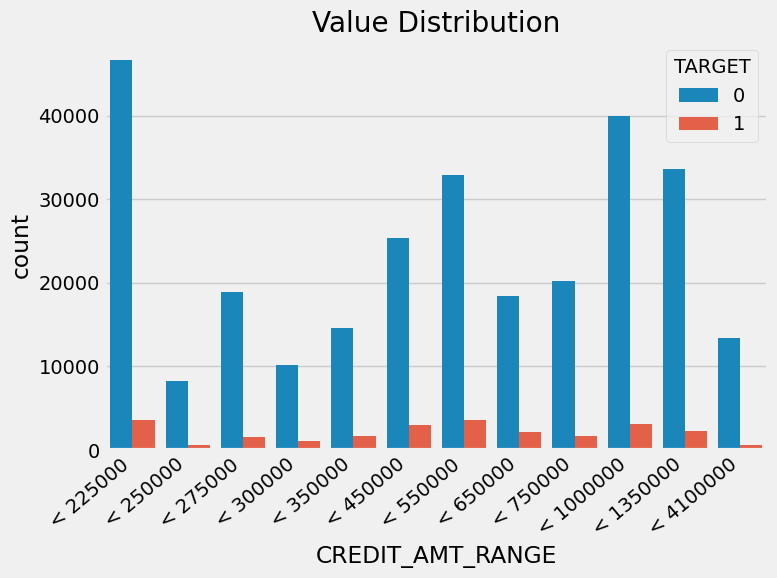

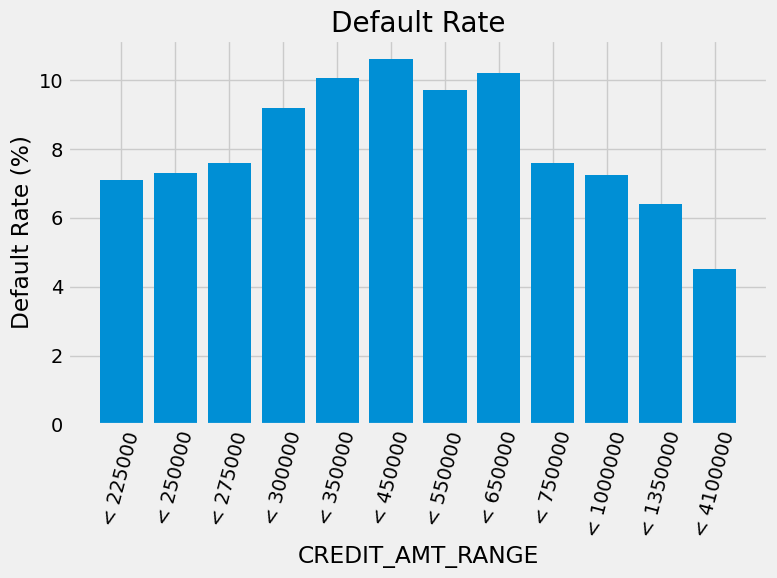

In [43]:
# Cantidad del Crédito

bins = np.linspace(0, 4050000, 10)
bins = (0, 225000,  250000, 275000, 300000, 350000, 450000,  550000, 650000, 750000, 1000000, 1350000, 4100000)
labels = ['< 225000',  '< 250000', '< 275000', '< 300000', '< 350000', '< 450000', '< 550000', '< 650000', '< 750000', '< 1000000', '< 1350000', '< 4100000']

app_train['CREDIT_AMT_RANGE'] = pd.cut(app_train['AMT_CREDIT'], bins=bins, labels=labels)
show_default_rate(app_train.loc[:,['CREDIT_AMT_RANGE', 'TARGET']], 'Credit Amount Range')

In [44]:
# Eliminar las columnas de rangos
filter_cols = ['CREDIT_AMT_RANGE', 'INCOME_AMT_RANGE']
app_train = app_train.drop(columns = filter_cols)

In [45]:
# Edad

# Convertir a años y comprobar valores atípicos
(app_train['DAYS_BIRTH'] / -365).describe()

count             307,511.00
mean                   43.94
std                    11.96
min                    20.52
25%                    34.01
50%                    43.15
75%                    53.92
max                    69.12
Name: DAYS_BIRTH, dtype: float64

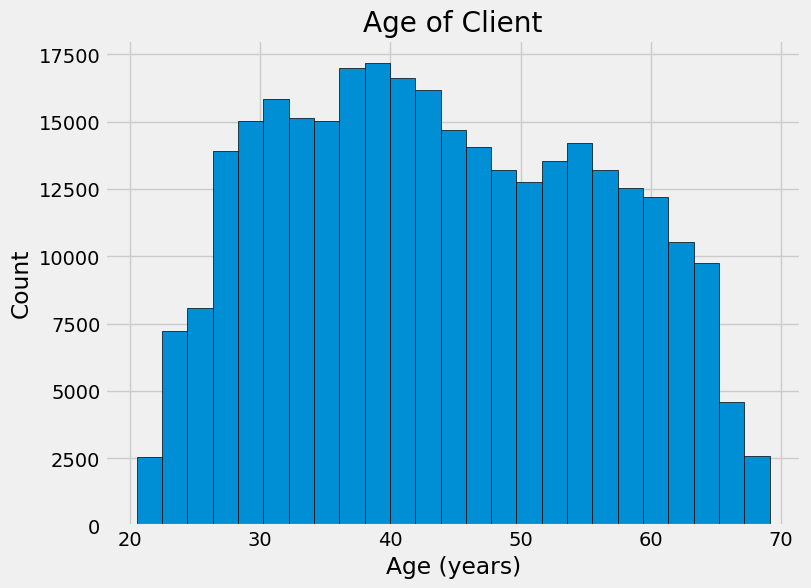

In [46]:
# Graficar la distribución de edades en años
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.hist(abs(app_train['DAYS_BIRTH'] / 365), edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [47]:
# Encontrar la correlación entre la edad y la variable objetivo
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982709)

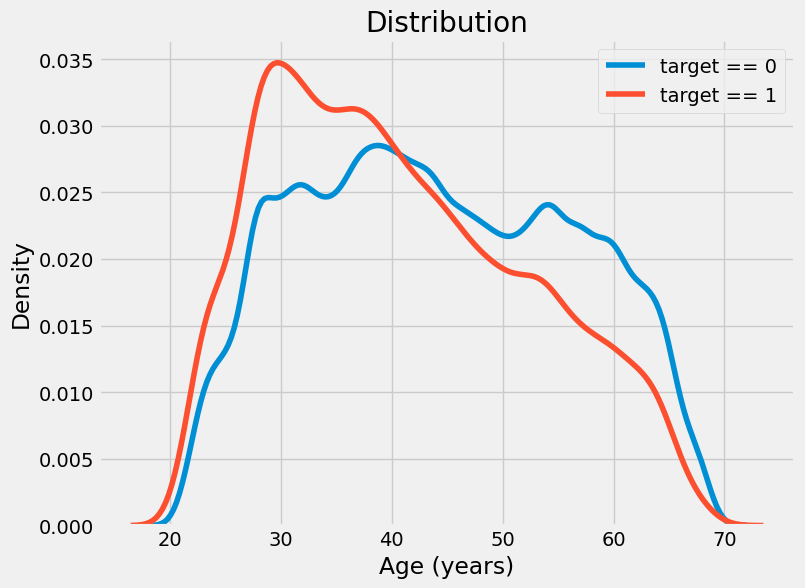

In [48]:
plt.figure(figsize = (8, 6))

# Convertir los días negativos a años positivos 
# DAYS_BIRTH está en días negativos, por lo que necesitamos usar abs() o multiplicar por -1
sns.kdeplot(abs(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH']) / 365, 
            label='target == 0')

# Gráfico KDE de préstamos que no fueron pagados a tiempo
sns.kdeplot(abs(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH']) / 365, 
            label='target == 1')

# Etiquetas del gráfico
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution');

# Añadir la leyenda explícitamente
plt.legend(loc='upper right')

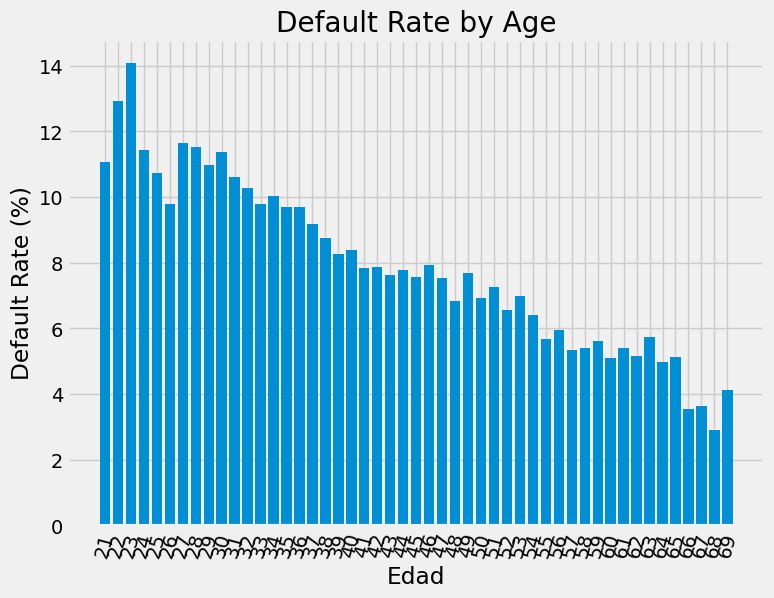

In [49]:
# Graficar la tasa de impago por rango de edad
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = round(abs(age_data['DAYS_BIRTH']) / 365).astype(int)
age_groups  = age_data.groupby('YEARS_BIRTH').mean()

plt.style.use('fivethirtyeight')

plt.figure(figsize = (8, 6))

ax = plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75); plt.xlabel('Edad'); plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Age');



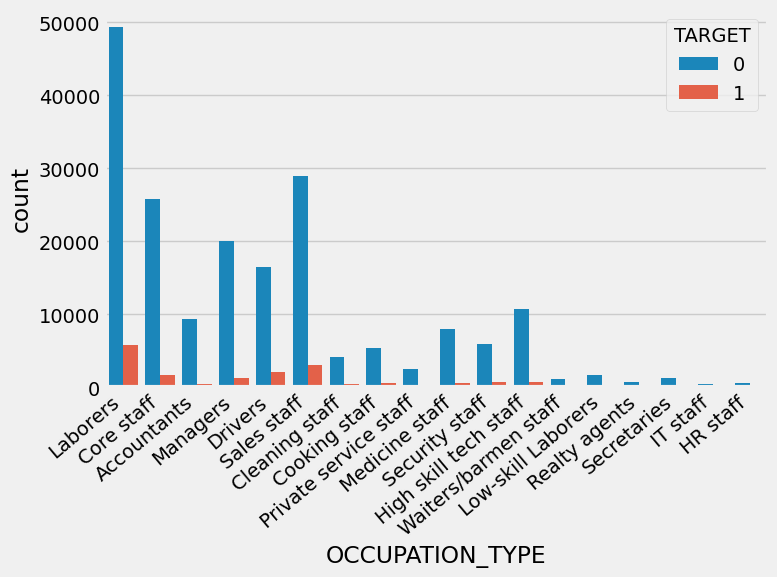

In [50]:
# Tipo de Ocupación

# Graficar la distribución de préstamos e impagos por tipo de ocupación

plt.figure(figsize = (8, 6))

plt.style.use('fivethirtyeight')

occupation_data = app_train[['TARGET', 'OCCUPATION_TYPE']]
occupation_data  = occupation_data.groupby(['OCCUPATION_TYPE', 'TARGET']).size()

ax = sns.countplot(x="OCCUPATION_TYPE", hue="TARGET", data=app_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

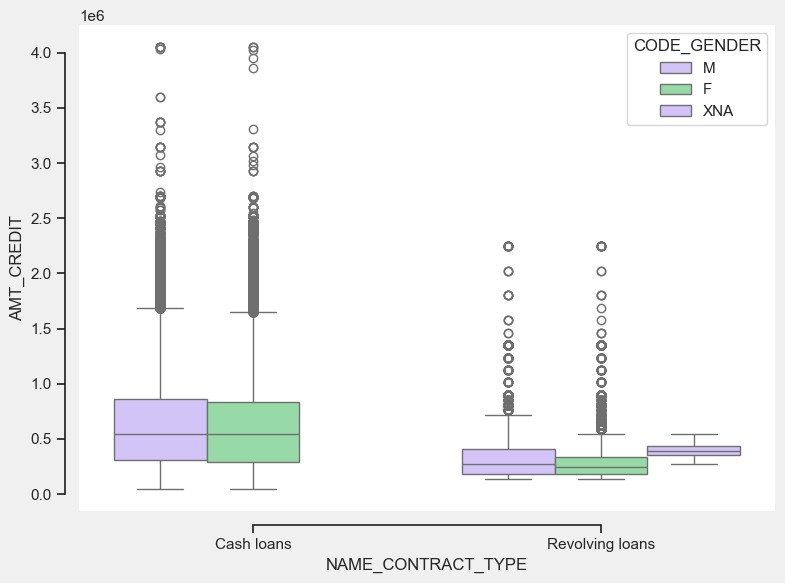

In [51]:
# Género

# Gráfico de cajas anidadas que muestra el monto de crédito por tipo de contrato y género
plt.figure(figsize = (8, 6))

sns.set(style="ticks", palette="pastel")

sns.boxplot(x="NAME_CONTRACT_TYPE", y="AMT_CREDIT",
            hue="CODE_GENDER", palette=["m", "g"],
            data=app_train)
sns.despine(offset=10, trim=True)

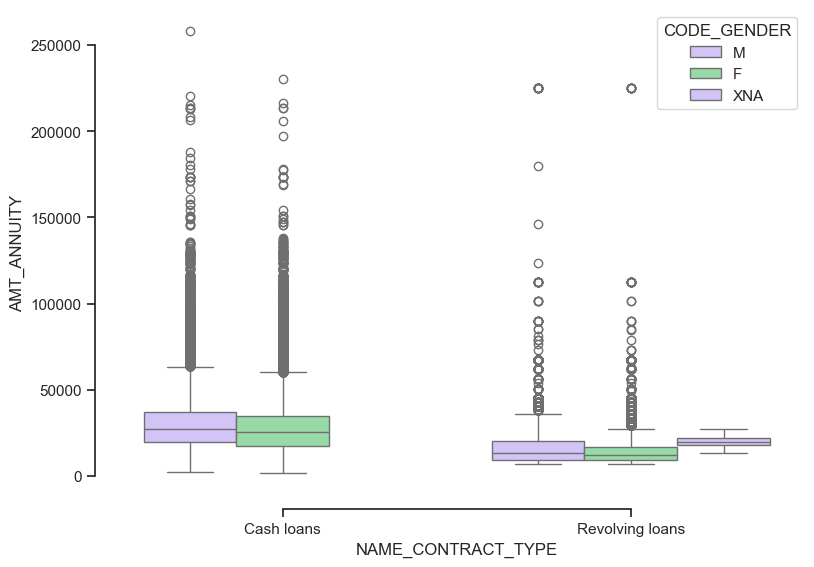

In [52]:
# Diagrama de cajas anidado que muestra la anualidad por tipo de contrato y género
plt.figure(figsize = (8, 6))

sns.set(style="ticks", palette="pastel")

sns.boxplot(x="NAME_CONTRACT_TYPE", y="AMT_ANNUITY",
            hue="CODE_GENDER", palette=["m", "g"],
            data=app_train)
sns.despine(offset=10, trim=True)


Data Set Name:Gender

Gender Column Name: CODE_GENDER



Count       Percentage (%)    Paid             Paid (%)  \
CODE_GENDER                                                             
M            105059                34.16   94404                89.86   
F            202448                65.83  188278                93.00   
XNA               4                 0.00       4               100.00   

                          Unpaid     Default Rate (%)  
CODE_GENDER                                            
M                      10,655.00                10.14  
F                      14,170.00                 7.00  
XNA                         0.00                 0.00

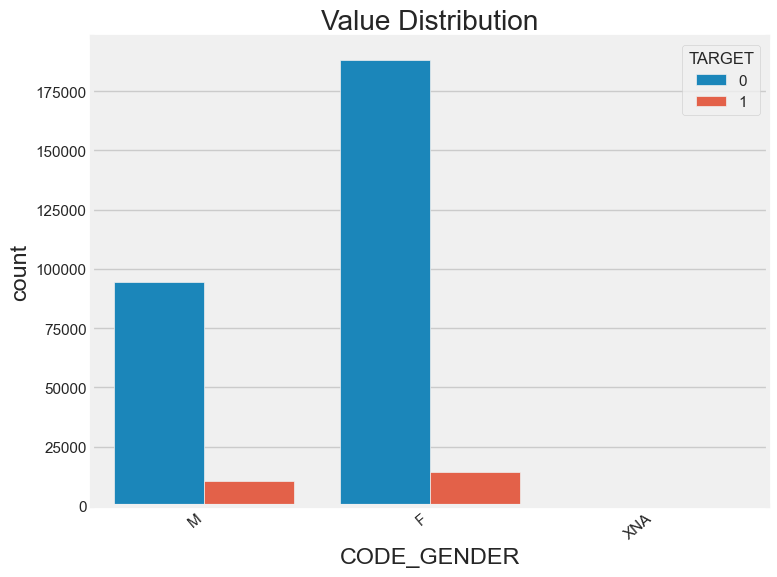

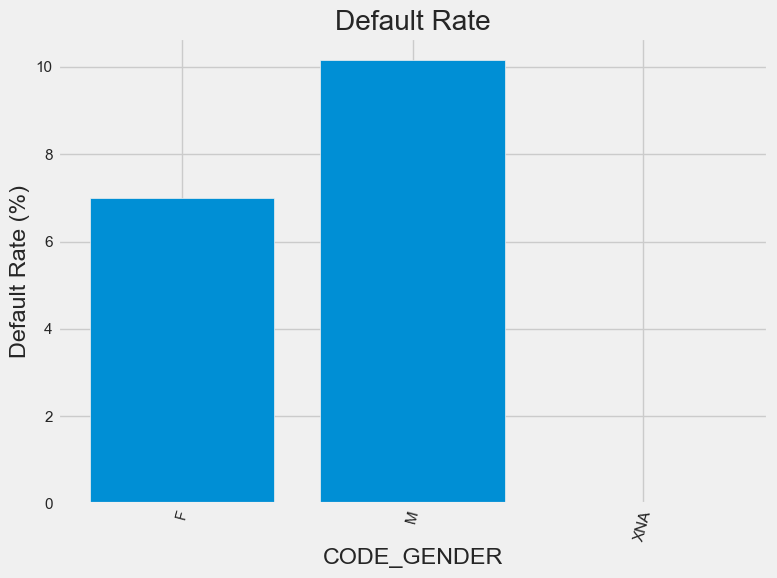

In [53]:
# Graficar la distribución de préstamos e impagos por género

show_default_rate(app_train.loc[:,['CODE_GENDER', 'TARGET']], 'Gender')


Data Set Name:Credit Amount Range - Males

Credit Amount Range - Males Column Name: CREDIT_AMT_RANGE



Count       Percentage (%)   Paid             Paid (%)  \
CREDIT_AMT_RANGE                                                           
< 650000           6894                 6.56   5955                86.38   
< 350000           5373                 5.11   4662                86.77   
< 450000          10372                 9.87   9035                87.11   
< 550000          12628                12.02  11020                87.27   
< 300000           3776                 3.59   3339                88.43   
< 250000           2764                 2.63   2482                89.80   
< 750000           7266                 6.92   6570                90.42   
< 275000           7327                 6.97   6626                90.43   
< 225000          16155                15.38  14696                90.97   
< 1000000         14559                13.86  13293                91.30   
< 1350000         12613                12.01  11654                92.40   
< 4100000          5332                 5.08   5072                95.12   

                  Unpaid     Default Rate (%)  
CREDIT_AMT_RANGE                               
< 650000             939                13.62  
< 350000             711                13.23  
< 450000            1337                12.89  
< 550000            1608                12.73  
< 300000             437                11.57  
< 250000             282                10.20  
< 750000             696                 9.58  
< 275000             701                 9.57  
< 225000            1459                 9.03  
< 1000000           1266                 8.70  
< 1350000            959                 7.60  
< 4100000            260                 4.88

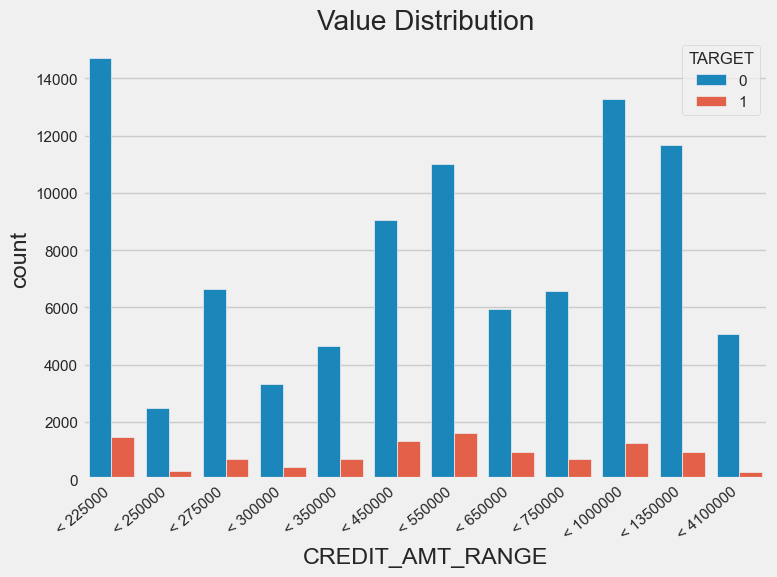

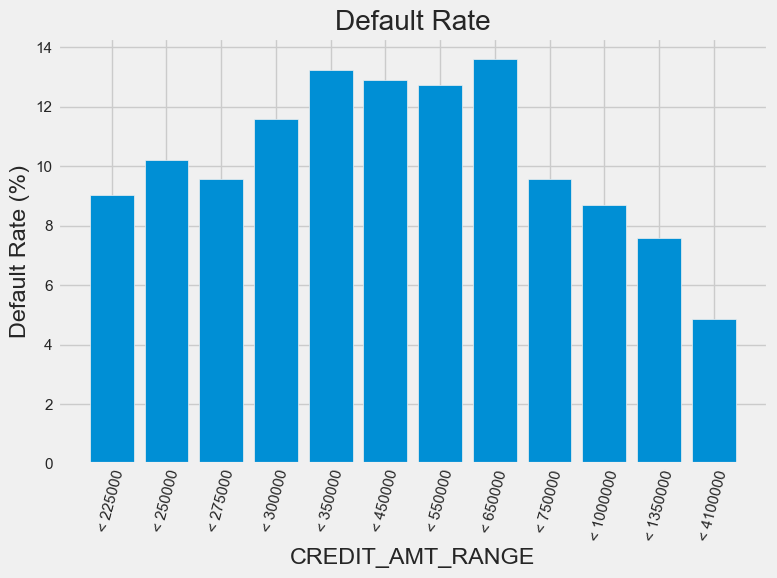

In [54]:
# Monto del Crédito - Hombres

male_data = app_train[app_train['CODE_GENDER']== 'M']

bins = np.linspace(0, 4050000, 10)
bins = (0, 225000,  250000, 275000, 300000, 350000, 450000,  550000, 650000, 750000, 1000000, 1350000, 4100000)
labels = ['< 225000',  '< 250000', '< 275000', '< 300000', '< 350000', '< 450000', '< 550000', '< 650000', '< 750000', '< 1000000', '< 1350000', '< 4100000']

male_data['CREDIT_AMT_RANGE'] = pd.cut(male_data['AMT_CREDIT'], bins=bins, labels=labels)
show_default_rate(male_data.loc[:,['CREDIT_AMT_RANGE', 'TARGET']], 'Credit Amount Range - Males')

del male_data


Data Set Name:Credit Amount Range - Females

Credit Amount Range - Females Column Name: CREDIT_AMT_RANGE



Count       Percentage (%)   Paid             Paid (%)  \
CREDIT_AMT_RANGE                                                           
< 450000          17998                 8.89  16319                90.67   
< 650000          13658                 6.75  12496                91.49   
< 350000          10832                 5.35   9912                91.51   
< 550000          23848                11.78  21913                91.89   
< 300000           7481                 3.70   6883                92.01   
< 750000          14598                 7.21  13632                93.38   
< 1000000         28540                14.10  26677                93.47   
< 275000          13174                 6.51  12319                93.51   
< 225000          34089                16.84  31982                93.82   
< 250000           6190                 3.06   5818                93.99   
< 1350000         23338                11.53  21998                94.26   
< 4100000          8702                 4.30   8329                95.71   

                  Unpaid     Default Rate (%)  
CREDIT_AMT_RANGE                               
< 450000            1679                 9.33  
< 650000            1162                 8.51  
< 350000             920                 8.49  
< 550000            1935                 8.11  
< 300000             598                 7.99  
< 750000             966                 6.62  
< 1000000           1863                 6.53  
< 275000             855                 6.49  
< 225000            2107                 6.18  
< 250000             372                 6.01  
< 1350000           1340                 5.74  
< 4100000            373                 4.29

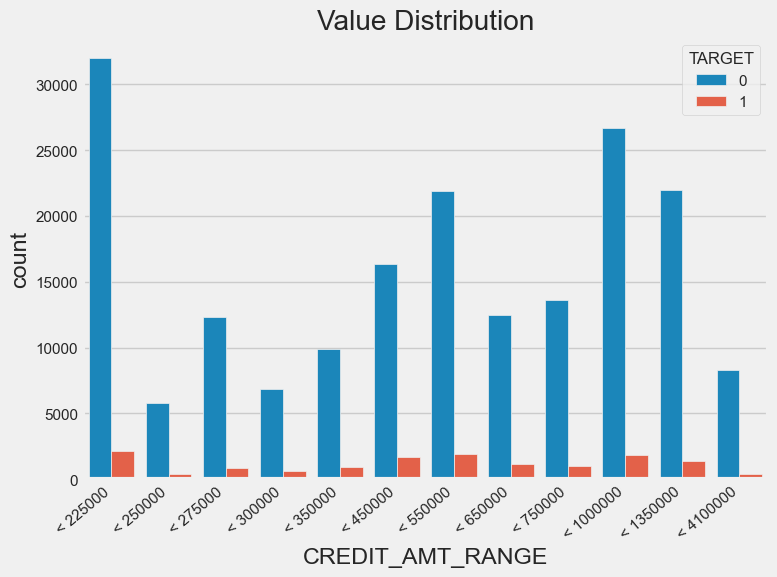

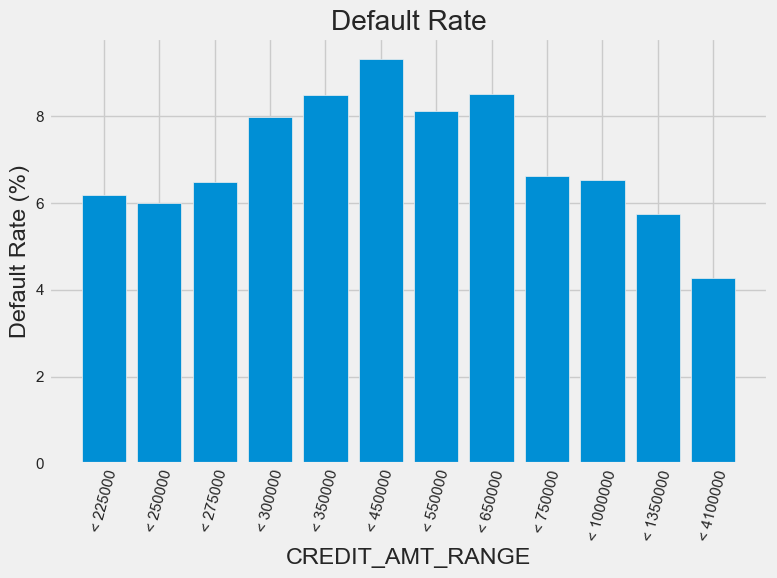

In [55]:
# Monto del Crédito - Mujeres

female_data = app_train[app_train['CODE_GENDER']== 'F']

bins = np.linspace(0, 4050000, 10)
bins = (0, 225000,  250000, 275000, 300000, 350000, 450000,  550000, 650000, 750000, 1000000, 1350000, 4100000)
labels = ['< 225000',  '< 250000', '< 275000', '< 300000', '< 350000', '< 450000', '< 550000', '< 650000', '< 750000', '< 1000000', '< 1350000', '< 4100000']

female_data['CREDIT_AMT_RANGE'] = pd.cut(female_data['AMT_CREDIT'], bins=bins, labels=labels)
show_default_rate(female_data.loc[:,['CREDIT_AMT_RANGE', 'TARGET']], 'Credit Amount Range - Females')

del female_data

## III - Características del Dominio
 
Incluiremos algunas características adicionales en los conjuntos de datos de entrenamiento y prueba:

* `CREDIT_INCOME_PERCENT`: el porcentaje del monto del crédito en relación con los ingresos del cliente
* `CREDIT_GOODS_PERCENT`: el porcentaje del monto del crédito en relación con el precio de los bienes para los que se otorga el préstamo
* `ANNUITY_INCOME_PERCENT`: el porcentaje de la anualidad mensual del préstamo en relación con los ingresos del cliente
* `CREDIT_TERM`: la duración del pago en meses
* `DAYS_EMPLOYED_PERCENT`: el porcentaje de días empleado en relación con la edad del cliente
* `EXT_SOURCE_AVG`: el promedio de las tres puntuaciones de fuentes externas para el cliente
* `INCOME_PER_PERSON`: la relación entre los ingresos del cliente y el número de miembros del hogar
* `ANY_CHILDREN`: si el cliente tiene o no uno o más hijos
* `IS_EMPLOYED`: si el cliente estaba empleado o no cuando presentó su solicitud
* `LONGTERM_EMPLOYMENT`: si el cliente comenzó o no su empleo actual más de 5 años antes de solicitar el préstamo

In [56]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_GOODS_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train['EXT_SOURCE_AVG'] = (app_train['EXT_SOURCE_1'].fillna(0) + app_train['EXT_SOURCE_2'].fillna(0) + app_train['EXT_SOURCE_3'].fillna(0)) / 3
app_train['INCOME_PER_PERSON'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_FAM_MEMBERS']
app_train['ANY_CHILDREN'] = app_train['CNT_CHILDREN'].map(lambda x: 1 if x > 0 else 0)
app_train['IS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].map(lambda x: 1 if x < 0 else 0)
app_train['LONGTERM_EMPLOYMENT'] = app_train['DAYS_EMPLOYED'].map(lambda x: 1 if x < -2000 else 0)

app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_GOODS_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_GOODS_PRICE']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']
app_test['EXT_SOURCE_AVG'] = (app_test['EXT_SOURCE_1'] + app_test['EXT_SOURCE_2'] + app_test['EXT_SOURCE_3']) / 3
app_test['INCOME_PER_PERSON'] = app_test['AMT_INCOME_TOTAL'] / app_test['CNT_FAM_MEMBERS']
app_test['ANY_CHILDREN'] = app_test['CNT_CHILDREN'].map(lambda x: 1 if x > 0 else 0)
app_test['IS_EMPLOYED'] = app_test['DAYS_EMPLOYED'].map(lambda x: 1 if x < 0 else 0)
app_test['LONGTERM_EMPLOYMENT'] = app_test['DAYS_EMPLOYED'].map(lambda x: 1 if x < -2000 else 0)

In [57]:
# Encontrar la correlación de las nuevas variables y la variable objetivo
ext_data = app_train[['TARGET', 'EXT_SOURCE_AVG', 'CREDIT_INCOME_PERCENT', 'CREDIT_GOODS_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'INCOME_PER_PERSON', 'ANY_CHILDREN', 'IS_EMPLOYED', 'LONGTERM_EMPLOYMENT']]
ext_data_corrs = ext_data.corr()
ext_data_corrs



TARGET       EXT_SOURCE_AVG  \
TARGET                                 1.00                -0.17   
EXT_SOURCE_AVG                        -0.17                 1.00   
CREDIT_INCOME_PERCENT                 -0.01                 0.04   
CREDIT_GOODS_PERCENT                   0.07                -0.06   
ANNUITY_INCOME_PERCENT                 0.01                -0.01   
CREDIT_TERM                            0.01                -0.06   
DAYS_EMPLOYED_PERCENT                  0.07                -0.12   
INCOME_PER_PERSON                     -0.01                 0.05   
ANY_CHILDREN                           0.02                 0.02   
IS_EMPLOYED                            0.05                 0.03   
LONGTERM_EMPLOYMENT                   -0.05                 0.13   

                        CREDIT_INCOME_PERCENT  CREDIT_GOODS_PERCENT  \
TARGET                                  -0.01                  0.07   
EXT_SOURCE_AVG                           0.04                 -0.06   
CREDIT_INCOME_PERCENT                    1.00                  0.07   
CREDIT_GOODS_PERCENT                     0.07                  1.00   
ANNUITY_INCOME_PERCENT                   0.79                  0.01   
CREDIT_TERM                             -0.52                 -0.14   
DAYS_EMPLOYED_PERCENT                   -0.05                  0.02   
INCOME_PER_PERSON                       -0.16                 -0.03   
ANY_CHILDREN                            -0.03                  0.02   
IS_EMPLOYED                             -0.08                  0.01   
LONGTERM_EMPLOYMENT                      0.03                 -0.01   

                        ANNUITY_INCOME_PERCENT          CREDIT_TERM  \
TARGET                                    0.01                 0.01   
EXT_SOURCE_AVG                           -0.01                -0.06   
CREDIT_INCOME_PERCENT                     0.79                -0.52   
CREDIT_GOODS_PERCENT                      0.01                -0.14   
ANNUITY_INCOME_PERCENT                    1.00                -0.03   
CREDIT_TERM                              -0.03                 1.00   
DAYS_EMPLOYED_PERCENT                    -0.02                 0.05   
INCOME_PER_PERSON                        -0.22                -0.02   
ANY_CHILDREN                             -0.01                 0.03   
IS_EMPLOYED                              -0.08                 0.02   
LONGTERM_EMPLOYMENT                      -0.01                -0.05   

                        DAYS_EMPLOYED_PERCENT    INCOME_PER_PERSON  \
TARGET                                   0.07                -0.01   
EXT_SOURCE_AVG                          -0.12                 0.05   
CREDIT_INCOME_PERCENT                   -0.05                -0.16   
CREDIT_GOODS_PERCENT                     0.02                -0.03   
ANNUITY_INCOME_PERCENT                  -0.02                -0.22   
CREDIT_TERM                              0.05                -0.02   
DAYS_EMPLOYED_PERCENT                    1.00                 0.00   
INCOME_PER_PERSON                        0.00                 1.00   
ANY_CHILDREN                            -0.00                -0.23   
IS_EMPLOYED                             -0.00                 0.01   
LONGTERM_EMPLOYMENT                     -0.75                 0.01   

                               ANY_CHILDREN          IS_EMPLOYED  \
TARGET                                 0.02                 0.05   
EXT_SOURCE_AVG                         0.02                 0.03   
CREDIT_INCOME_PERCENT                 -0.03                -0.08   
CREDIT_GOODS_PERCENT                   0.02                 0.01   
ANNUITY_INCOME_PERCENT                -0.01                -0.08   
CREDIT_TERM                            0.03                 0.02   
DAYS_EMPLOYED_PERCENT                 -0.00                -0.00   
INCOME_PER_PERSON                     -0.23                 0.01   
ANY_CHILDREN                           1.00                 0

In [58]:
# plt.figure(figsize = (12, 20))
# # iterar a través de las nuevas características
# for i, feature in enumerate(['EXT_SOURCE_AVG', 'CREDIT_INCOME_PERCENT', 'CREDIT_GOODS_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'INCOME_PER_PERSON']):
#     
#     # crear un nuevo subgráfico para cada fuente
#     plt.subplot(7, 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], label = 'target == 0')
#     # graficar préstamos que no fueron pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], label = 'target == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribución de %s por Valor Objetivo' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Density');
#     
# plt.tight_layout(h_pad = 2.5)

## IV - Características de Pagos a Plazos
 
Incluiremos algunas características adicionales del conjunto de datos de pagos a plazos:

Vemos algunos ejemplos de contratos con nulos en las variables de cuotas pagadas. Eliminamos los mismos.

In [59]:
null_payments = pd.DataFrame(app_installments_payments[(app_installments_payments['AMT_INSTALMENT']==0) & app_installments_payments['AMT_PAYMENT'].isnull()].SK_ID_PREV.drop_duplicates())
null_payments.set_index('SK_ID_PREV', drop=False)

null_payments = app_installments_payments[app_installments_payments['SK_ID_PREV'].isin(null_payments['SK_ID_PREV'])]

null_payments.sort_values(by=['SK_ID_PREV'], ascending = False)
#null_payments



SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
5646226     2820929      257105                    0.00   
5167463     2820929      257105                    0.00   
5191293     2820929      257105                    0.00   
5230505     2820929      257105                    0.00   
5231572     2820929      257105                    0.00   
...             ...         ...                     ...   
3764239     1160413      162504                    0.00   
593084      1131442      130761                    1.00   
3764249     1131442      130761                    2.00   
3387590     1131442      130761                    1.00   
3563880     1131442      130761                    2.00   

         NUM_INSTALMENT_NUMBER      DAYS_INSTALMENT   DAYS_ENTRY_PAYMENT  \
5646226                      9            -1,506.00            -1,519.00   
5167463                     20            -1,372.00            -1,372.00   
5191293                     12            -1,476.00            -1,457.00   
5230505                     32            -1,063.00            -1,063.00   
5231572                     26            -1,191.00            -1,191.00   
...                        ...                  ...                  ...   
3764239                      2              -306.00                  NaN   
593084                       1              -112.00              -121.00   
3764249                      3               -52.00                  NaN   
3387590                      2               -82.00               -86.00   
3563880                      4               -22.00               -30.00   

              AMT_INSTALMENT          AMT_PAYMENT  
5646226            11,025.00            11,025.00  
5167463               239.85               239.85  
5191293            11,025.00            11,025.00  
5230505             2,475.00             2,475.00  
5231572               239.85               239.85  
...                      ...                  ...  
3764239                 0.00                  NaN  
593084             19,387.67            19,387.67  
3764249                 0.00                  NaN  
3387590            19,387.67            19,387.67  
3563880            19,387.67            19,387.67  

[933 rows x 8 columns]

In [60]:
null_payments = pd.DataFrame(app_installments_payments[(app_installments_payments['AMT_INSTALMENT']==0) & app_installments_payments['AMT_PAYMENT'].isnull()].SK_ID_PREV.drop_duplicates())
null_payments.set_index('SK_ID_PREV', drop=False)
app_installments_payments = app_installments_payments[-app_installments_payments['SK_ID_PREV'].isin(null_payments['SK_ID_PREV'])]

Vemos distribución de variables

In [61]:
# app_installments_payments['NUM_INSTALMENT_VERSION'].plot.hist(title = 'Cambios en calendario de pagos');

In [62]:
# app_installments_payments['NUM_INSTALMENT_NUMBER'].plot.hist(title = 'Cuotas pagadas');

In [63]:
# app_installments_payments['DAYS_INSTALMENT'].plot.hist(title = 'Días de pago teórico');

In [64]:
# app_installments_payments['DAYS_ENTRY_PAYMENT'].plot.hist(title = 'Días de pago real');

In [65]:
# app_installments_payments['AMT_INSTALMENT'].plot.hist(title = 'Cuantía teórico a pagar');

In [66]:
# app_installments_payments['AMT_PAYMENT'].plot.hist(title = 'Cuantía real pagada');

In [67]:
# plt.boxplot(app_installments_payments['NUM_INSTALMENT_VERSION'], notch = True)

In [68]:
# plt.boxplot(app_installments_payments['NUM_INSTALMENT_NUMBER'], notch = True)

In [69]:
# plt.boxplot(app_installments_payments['DAYS_INSTALMENT'], notch = True)

In [70]:
# plt.boxplot(app_installments_payments['DAYS_ENTRY_PAYMENT'], notch = True)

In [71]:
# plt.boxplot(app_installments_payments['AMT_INSTALMENT'], notch = True)

In [72]:
# plt.boxplot(app_installments_payments['AMT_PAYMENT'], notch = True)

Vemos valores duplicados a nivel contrato previo, contrato actual, num_instalment_version, num_instalment_number. 

In [73]:
inst_pay_agg = app_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER'])['SK_ID_PREV'].agg(['count']).sort_values('count', ascending = False)
inst_pay_agg.head()

count
SK_ID_PREV SK_ID_CURR NUM_INSTALMENT_VERSION NUM_INSTALMENT_NUMBER       
2778637    354455     2.00                   101                       12
2248580    340563     2.00                   101                        9
1030631    277041     2.00                   101                        8
1463960    140244     2.00                   101                        8
1240132    366695     2.00                   101                        8

In [74]:
### Analizamos algunos ejemplos: vemos que el cliente paga en diversos días poco a poco parte de la cuota 
inst_pay_ej = app_installments_payments[(app_installments_payments.SK_ID_PREV == 2778637) & (app_installments_payments.SK_ID_CURR == 354455) & (app_installments_payments.NUM_INSTALMENT_VERSION == 2) & (app_installments_payments.NUM_INSTALMENT_NUMBER == 101)]
# inst_pay_ej

In [75]:
# creamos dataset marcando estos casos
repeated_payments = app_installments_payments[['SK_ID_PREV','NUM_INSTALMENT_NUMBER','AMT_INSTALMENT']]
repeated_payments = repeated_payments.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], as_index=False).agg('count')
repeated_payments['repetidos'] = np.where(repeated_payments['AMT_INSTALMENT'] > 1, 1, 0)
repeated_payments = repeated_payments.groupby(['SK_ID_PREV'], as_index=False).agg({'repetidos':'sum'})
repeated_payments.set_index('SK_ID_PREV', drop=False)
# repeated_payments.head()

SK_ID_PREV  repetidos
SK_ID_PREV                       
1000001        1000001          0
1000002        1000002          0
1000003        1000003          0
1000004        1000004          0
1000005        1000005          1
...                ...        ...
2843495        2843495          0
2843496        2843496          2
2843497        2843497          0
2843498        2843498          0
2843499        2843499          0

[997715 rows x 2 columns]

obtenemos número de cuotas de cada préstamo (máximo)

In [76]:
qty_payments = app_installments_payments[['SK_ID_PREV','NUM_INSTALMENT_NUMBER']].groupby(['SK_ID_PREV'], as_index=False).agg({'NUM_INSTALMENT_NUMBER':'max'})
qty_payments.set_index('SK_ID_PREV', drop=False)
# qty_payments.head()

SK_ID_PREV  NUM_INSTALMENT_NUMBER
SK_ID_PREV                                   
1000001        1000001                      2
1000002        1000002                      4
1000003        1000003                      3
1000004        1000004                      7
1000005        1000005                     10
...                ...                    ...
2843495        2843495                      7
2843496        2843496                     32
2843497        2843497                     20
2843498        2843498                      6
2843499        2843499                     10

[997715 rows x 2 columns]

Obtenemos la cuantía a pagar teórica y pagada en cada cuota / mensualidad

In [77]:
inst_amount = app_installments_payments[['SK_ID_PREV','NUM_INSTALMENT_NUMBER','AMT_INSTALMENT','AMT_PAYMENT']].groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER','AMT_INSTALMENT'], as_index=False).agg('count')
inst_amount = inst_amount.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], as_index=False).agg({'AMT_INSTALMENT':'sum'})
inst_amount.set_index('SK_ID_PREV', drop=False)
# inst_amount.head()

SK_ID_PREV  NUM_INSTALMENT_NUMBER       AMT_INSTALMENT
SK_ID_PREV                                                        
1000001        1000001                      1             6,404.31
1000001        1000001                      2            62,039.11
1000002        1000002                      1             6,264.00
1000002        1000002                      2             6,264.00
1000002        1000002                      3             6,264.00
...                ...                    ...                  ...
2843499        2843499                      6            16,074.00
2843499        2843499                      7            16,074.00
2843499        2843499                      8            16,074.00
2843499        2843499                      9            16,074.00
2843499        2843499                     10           433,416.24

[12861075 rows x 3 columns]

In [78]:
# control de duplicados
sin_dup = inst_amount.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER'])['SK_ID_PREV'].agg(['count']).sort_values('count', ascending = False)
# sin_dup.head()
del sin_dup

In [79]:
payed_amount = app_installments_payments[['SK_ID_PREV','NUM_INSTALMENT_NUMBER','AMT_INSTALMENT','AMT_PAYMENT']].groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER','AMT_PAYMENT'], as_index=False).agg('count')
payed_amount = payed_amount.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], as_index=False).agg({'AMT_PAYMENT':'sum'})
payed_amount.set_index('SK_ID_PREV', drop=False)
# payed_amount.head()

SK_ID_PREV  NUM_INSTALMENT_NUMBER          AMT_PAYMENT
SK_ID_PREV                                                        
1000001        1000001                      1             6,404.31
1000001        1000001                      2            62,039.11
1000002        1000002                      1             6,264.00
1000002        1000002                      2             6,264.00
1000002        1000002                      3             6,264.00
...                ...                    ...                  ...
2843499        2843499                      6            16,074.00
2843499        2843499                      7            16,074.00
2843499        2843499                      8            16,074.00
2843499        2843499                      9            16,074.00
2843499        2843499                     10           433,416.24

[12858237 rows x 3 columns]

In [80]:
# control de duplicados
sin_dup = payed_amount.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER'])['SK_ID_PREV'].agg(['count']).sort_values('count', ascending = False)
# sin_dup.head()
del sin_dup

In [81]:
amount_inner = pd.merge(left=inst_amount,right=payed_amount, left_on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], right_on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'])
# amount_inner.head()

Hay casos que tienen cuota teórica a cero pero pago realizado

In [82]:
no_instalment = amount_inner[(amount_inner.AMT_INSTALMENT == 0) & (amount_inner.AMT_PAYMENT > 0) ]
no_instalment.set_index('SK_ID_PREV', drop=False)
# no_instalment.head(10)

SK_ID_PREV  NUM_INSTALMENT_NUMBER       AMT_INSTALMENT  \
SK_ID_PREV                                                           
1030407        1030407                      1                 0.00   
1030407        1030407                      2                 0.00   
1030407        1030407                      3                 0.00   
1030407        1030407                      4                 0.00   
1030407        1030407                      5                 0.00   
...                ...                    ...                  ...   
2567423        2567423                      4                 0.00   
2567423        2567423                      5                 0.00   
2567423        2567423                      6                 0.00   
2567423        2567423                      7                 0.00   
2567423        2567423                      8                 0.00   

                    AMT_PAYMENT  
SK_ID_PREV                       
1030407                7,616.65  
1030407                7,616.65  
1030407                7,616.65  
1030407                7,616.65  
1030407                7,616.65  
...                         ...  
2567423                5,776.11  
2567423                5,776.11  
2567423                5,776.11  
2567423                5,776.11  
2567423                5,782.77  

[217 rows x 4 columns]

In [83]:
inst_amount.drop(columns=inst_amount.columns)
inst_amount = app_installments_payments[['SK_ID_PREV','NUM_INSTALMENT_NUMBER','AMT_INSTALMENT','AMT_PAYMENT']]
inst_amount.set_index('SK_ID_PREV', drop=False)
inst_amount = pd.merge(left=inst_amount,right=no_instalment, left_on='SK_ID_PREV', right_on='SK_ID_PREV', how='left', suffixes=('','right'))
inst_amount['AMT_INSTALMENT'] = np.where(inst_amount['AMT_INSTALMENTright'].isna() | inst_amount['AMT_INSTALMENTright'] ==0,\
                                         inst_amount['AMT_PAYMENT'],inst_amount['AMT_INSTALMENT'])

inst_amount = inst_amount.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER','AMT_INSTALMENT'], as_index=False).agg('count')
inst_amount = inst_amount.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], as_index=False).agg({'AMT_INSTALMENT':'sum'})
inst_amount.set_index('SK_ID_PREV', drop=False)

amount_inner = pd.merge(left=inst_amount,right=payed_amount, left_on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], right_on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'])
# amount_inner.head()

In [84]:
# control de duplicados
sin_dup = amount_inner[(amount_inner.AMT_INSTALMENT == 0) & (amount_inner.AMT_PAYMENT > 0) ]
# sin_dup
del amount_inner
del sin_dup

Calculamos otras variables como retrasos o adelantos en los pagos, la cuantía del préstamo y si se ha pagado todo

In [85]:
delay_advance = pd.merge(left=app_installments_payments, right=inst_amount, how='left', on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], \
                         suffixes=('_L', '_R'))
delay_advance['del_adv'] = np.where(delay_advance['AMT_INSTALMENT_R']==0,0,(delay_advance['DAYS_INSTALMENT']-delay_advance['DAYS_ENTRY_PAYMENT'])\
                                    *(delay_advance['AMT_INSTALMENT_L']/delay_advance['AMT_INSTALMENT_R']))
delay_advance['days_diff'] = delay_advance['DAYS_INSTALMENT'] - delay_advance['DAYS_ENTRY_PAYMENT']
delay_advance['ratio'] = delay_advance['AMT_INSTALMENT_L']/delay_advance['AMT_INSTALMENT_R'] 
delay_advance = delay_advance.groupby(['SK_ID_PREV'], as_index=False).agg({'days_diff':['sum','mean'],'del_adv':['sum','mean'], 'ratio':['mean']})

# delay_advance.head(10)

In [86]:
loan_amount = inst_amount.groupby(['SK_ID_PREV'], as_index=False).agg({'AMT_INSTALMENT':'sum'})
loan_amount = loan_amount.rename(index=str, columns={"AMT_INSTALMENT":"loan"})
loan_amount.set_index('SK_ID_PREV', drop=False)
loan_amount.head()

SK_ID_PREV                 loan
0     1000001            68,443.43
1     1000002            37,235.57
2     1000003            14,854.05
3     1000004            33,523.15
4     1000005           147,021.70

In [87]:
inst_amount_total = inst_amount.groupby(['SK_ID_PREV'], as_index=False).agg({'AMT_INSTALMENT':'sum'})

payed_amount_total = payed_amount.groupby(['SK_ID_PREV'], as_index=False).agg({'AMT_PAYMENT':'sum'})

net_debt = pd.merge(left=inst_amount_total,right=payed_amount_total, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
net_debt['balance'] = net_debt['AMT_INSTALMENT'].astype(int)-net_debt['AMT_PAYMENT'].astype(int)
net_debt = net_debt[['SK_ID_PREV','balance']]
net_debt = net_debt.groupby(['SK_ID_PREV'], as_index=False).agg({'balance':['sum','mean']})
# net_debt.head()

Creamos el conjunto de datos final uniendo los distintos datasets creados con info calculada

In [88]:
instalments = app_installments_payments[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
instalments.set_index('SK_ID_PREV', drop=False)
# instalments.head()

SK_ID_PREV  SK_ID_CURR
SK_ID_PREV                        
1054186        1054186      161674
1330831        1330831      151639
2085231        2085231      193053
2452527        2452527      199697
2714724        2714724      167756
...                ...         ...
2363009        2363009      430339
1231783        1231783      448767
1984920        1984920      416501
1946334        1946334      415418
1276288        1276288      448485

[997715 rows x 2 columns]

In [89]:
# Reset index of delay_advance and net_debt to remove multi-level columns
delay_advance.columns = ['SK_ID_PREV', 'days_diff_sum', 'days_diff_mean', 'del_adv_sum', 'del_adv_mean', 'ratio_mean']
net_debt.columns = ['SK_ID_PREV', 'balance_sum', 'balance_mean']

instalments = pd.merge(left=instalments,right=repeated_payments, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
instalments = pd.merge(left=instalments,right=qty_payments, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
instalments = pd.merge(left=instalments,right=delay_advance, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
instalments = pd.merge(left=instalments,right=net_debt, left_on='SK_ID_PREV', right_on='SK_ID_PREV')

# instalments.head(10)

In [90]:
instalments.columns = ["_".join(x) for x in instalments.columns.ravel()]
instalments.rename(columns={'S_K___I_D___P_R_E_V': 'SK_ID_PREV', 'S_K___I_D___C_U_R_R': 'SK_ID_CURR','r_e_p_e_a_t_e_d': 'repeated', \
                   'N_U_M___I_N_S_T_A_L_M_E_N_T___N_U_M_B_E_R': 'NUM_INSTALMENT_NUMBER'}, inplace=True)
# instalments.head(10)

In [91]:
del no_instalment

del null_payments

del inst_pay_agg

del inst_pay_ej

del repeated_payments

del qty_payments

del inst_amount

del payed_amount

del delay_advance


del inst_amount_total

del payed_amount_total

del net_debt

Vemos distribuciones de variables

In [92]:
#instalments['repeated'].plot.hist();

In [93]:
# instalments['days_diff_sum'].plot.hist();

In [94]:
# instalments['days_diff_mean'].plot.hist();

In [95]:
# instalments['del_adv_sum'].plot.hist();

In [96]:
# instalments['del_adv_mean'].plot.hist();

In [97]:
# instalments['ratio_mean'].plot.hist();

In [98]:
# instalments['balance_sum'].plot.hist();

In [99]:
# instalments['balance_mean'].plot.hist();

In [100]:
# plt.boxplot(instalments['repeated'], notch = True)

In [101]:
#plt.boxplot(instalments['days_diff_sum'], notch = True)

In [102]:
# plt.boxplot(instalments['days_diff_mean'], notch = True)

In [103]:
# plt.boxplot(instalments['del_adv_sum'], notch = True)

In [104]:
# plt.boxplot(instalments['del_adv_mean'], notch = True)

In [105]:
# plt.boxplot(instalments['balance_sum'], notch = True)

In [106]:
# plt.boxplot(instalments['balance_mean'], notch = True)

In [107]:
app_installments_payments = instalments
del instalments

In [108]:
format_colnames(app_installments_payments, 'Installments')


Nombre del conjunto de datos:Installments


Formateando nombres de columnas:


In [109]:
#show_basic(app_installments_payments, 'Installments')

In [110]:
# Agrupar columnas numéricas por id de solicitud actual y calcular estadísticas de agregación media, máximo, mínimo y suma
instalment_stats = app_installments_payments.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'max', 'min', 'sum']).reset_index()
# instalment_stats.head()

In [111]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Imprimir información de diagnóstico
print("Columnas actuales:", instalment_stats.columns.tolist())

# Inicializar lista de nombres de columnas
columns = []

# Procesar cada columna
for col in instalment_stats.columns:
    # Separar el nombre de la columna y la estadística
    if isinstance(col, tuple):
        var, stat = col
    else:
        # Si la columna es SK_ID_CURR o similar, mantenerla igual
        columns.append(col)
        continue
        
    # Crear el nuevo nombre
    if var.startswith('INSTALMENT_'):
        columns.append(f'{var}_{stat.upper()}')
    else:
        columns.append(f'INSTALMENT_{var}_{stat.upper()}')

# Verificar el número de columnas generadas
print("\nNúmero de nombres de columnas generados:", len(columns))
print("Número de columnas en instalment_stats:", len(instalment_stats.columns))

# Asignar los nombres de columnas
instalment_stats.columns = columns
instalment_stats.head()

Columnas actuales: [('index', ''), ('SK_ID_CURR', ''), ('R_E_P_E_T_I_D_O_S', 'mean'), ('R_E_P_E_T_I_D_O_S', 'max'), ('R_E_P_E_T_I_D_O_S', 'min'), ('R_E_P_E_T_I_D_O_S', 'sum'), ('NUM_INSTALMENT_NUMBER', 'mean'), ('NUM_INSTALMENT_NUMBER', 'max'), ('NUM_INSTALMENT_NUMBER', 'min'), ('NUM_INSTALMENT_NUMBER', 'sum'), ('D_A_Y_S___D_I_F_F___S_U_M', 'mean'), ('D_A_Y_S___D_I_F_F___S_U_M', 'max'), ('D_A_Y_S___D_I_F_F___S_U_M', 'min'), ('D_A_Y_S___D_I_F_F___S_U_M', 'sum'), ('D_A_Y_S___D_I_F_F___M_E_A_N', 'mean'), ('D_A_Y_S___D_I_F_F___M_E_A_N', 'max'), ('D_A_Y_S___D_I_F_F___M_E_A_N', 'min'), ('D_A_Y_S___D_I_F_F___M_E_A_N', 'sum'), ('D_E_L___A_D_V___S_U_M', 'mean'), ('D_E_L___A_D_V___S_U_M', 'max'), ('D_E_L___A_D_V___S_U_M', 'min'), ('D_E_L___A_D_V___S_U_M', 'sum'), ('D_E_L___A_D_V___M_E_A_N', 'mean'), ('D_E_L___A_D_V___M_E_A_N', 'max'), ('D_E_L___A_D_V___M_E_A_N', 'min'), ('D_E_L___A_D_V___M_E_A_N', 'sum'), ('R_A_T_I_O___M_E_A_N', 'mean'), ('R_A_T_I_O___M_E_A_N', 'max'), ('R_A_T_I_O___M_E_A_N', 'm

INSTALMENT_index_  INSTALMENT_SK_ID_CURR_  \
0                  0                  100001   
1                  1                  100002   
2                  2                  100003   
3                  3                  100004   
4                  4                  100005   

   INSTALMENT_R_E_P_E_T_I_D_O_S_MEAN  INSTALMENT_R_E_P_E_T_I_D_O_S_MAX  \
0                               0.00                                 0   
1                               0.00                                 0   
2                               0.00                                 0   
3                               0.00                                 0   
4                               0.00                                 0   

   INSTALMENT_R_E_P_E_T_I_D_O_S_MIN  INSTALMENT_R_E_P_E_T_I_D_O_S_SUM  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   INSTALMENT_NUM_INSTALMENT_NUMBER_MEAN  \
0                                   4.00   
1                                  19.00   
2                                   8.33   
3                                   3.00   
4                                   9.00   

   INSTALMENT_NUM_INSTALMENT_NUMBER_MAX  INSTALMENT_NUM_INSTALMENT_NUMBER_MIN  \
0                                     4                                     4   
1                                    19                                    19   
2                                    12                                     6   
3                                     3                                     3   
4                                     9                                     9   

   INSTALMENT_NUM_INSTALMENT_NUMBER_SUM  ...  \
0                                     8  ...   
1                                    19  ...   
2                                    25  ...   
3                                     3  ...   
4                                     9  ...   

   INSTALMENT_R_A_T_I_O___M_E_A_N_MIN  INSTALMENT_R_A_T_I_O___M_E_A_N_SUM  \
0                                1.00                                2.00   
1                                1.00                                1.00   
2                                1.00                                3.00   
3                                1.00                                1.00   
4                                1.00                                1.00   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_MEAN  \
0                                   0.00   
1                                   0.00   
2                                   0.00   
3                                   0.00   
4                                   0.00   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_MAX  INSTALMENT_B_A_L_A_N_C_E___S_U_M_MIN  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_SUM  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   INSTALMENT_B_A_L_A_N_C_E___M_E_A_N_MEAN  \
0                                     0.00   
1                                     0.00   
2                                     0.00   
3                                     0.00   
4                                     0.00   

   INSTALMENT_B_A_L_A_N_C_E___M_E_A_N_

In [112]:
# Primero, veamos qué tenemos
print("Forma de instalment_stats:", instalment_stats.shape)
print("\nColumnas actuales de instalment_stats:")
print(instalment_stats.columns.tolist())
print("\nNúmero de columnas propuestas:", len(columns))
print("\nColumnas propuestas:")
print(columns)

# Asegurémonos de que tengamos el número correcto de nombres de columnas
columns_adjusted = columns[:len(instalment_stats.columns)]

# Asignar los nombres ajustados
instalment_stats.columns = columns_adjusted
instalment_stats.head()

Forma de instalment_stats: (339577, 38)

Columnas actuales de instalment_stats:
['INSTALMENT_index_', 'INSTALMENT_SK_ID_CURR_', 'INSTALMENT_R_E_P_E_T_I_D_O_S_MEAN', 'INSTALMENT_R_E_P_E_T_I_D_O_S_MAX', 'INSTALMENT_R_E_P_E_T_I_D_O_S_MIN', 'INSTALMENT_R_E_P_E_T_I_D_O_S_SUM', 'INSTALMENT_NUM_INSTALMENT_NUMBER_MEAN', 'INSTALMENT_NUM_INSTALMENT_NUMBER_MAX', 'INSTALMENT_NUM_INSTALMENT_NUMBER_MIN', 'INSTALMENT_NUM_INSTALMENT_NUMBER_SUM', 'INSTALMENT_D_A_Y_S___D_I_F_F___S_U_M_MEAN', 'INSTALMENT_D_A_Y_S___D_I_F_F___S_U_M_MAX', 'INSTALMENT_D_A_Y_S___D_I_F_F___S_U_M_MIN', 'INSTALMENT_D_A_Y_S___D_I_F_F___S_U_M_SUM', 'INSTALMENT_D_A_Y_S___D_I_F_F___M_E_A_N_MEAN', 'INSTALMENT_D_A_Y_S___D_I_F_F___M_E_A_N_MAX', 'INSTALMENT_D_A_Y_S___D_I_F_F___M_E_A_N_MIN', 'INSTALMENT_D_A_Y_S___D_I_F_F___M_E_A_N_SUM', 'INSTALMENT_D_E_L___A_D_V___S_U_M_MEAN', 'INSTALMENT_D_E_L___A_D_V___S_U_M_MAX', 'INSTALMENT_D_E_L___A_D_V___S_U_M_MIN', 'INSTALMENT_D_E_L___A_D_V___S_U_M_SUM', 'INSTALMENT_D_E_L___A_D_V___M_E_A_N_MEAN', 

INSTALMENT_index_  INSTALMENT_SK_ID_CURR_  \
0                  0                  100001   
1                  1                  100002   
2                  2                  100003   
3                  3                  100004   
4                  4                  100005   

   INSTALMENT_R_E_P_E_T_I_D_O_S_MEAN  INSTALMENT_R_E_P_E_T_I_D_O_S_MAX  \
0                               0.00                                 0   
1                               0.00                                 0   
2                               0.00                                 0   
3                               0.00                                 0   
4                               0.00                                 0   

   INSTALMENT_R_E_P_E_T_I_D_O_S_MIN  INSTALMENT_R_E_P_E_T_I_D_O_S_SUM  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   INSTALMENT_NUM_INSTALMENT_NUMBER_MEAN  \
0                                   4.00   
1                                  19.00   
2                                   8.33   
3                                   3.00   
4                                   9.00   

   INSTALMENT_NUM_INSTALMENT_NUMBER_MAX  INSTALMENT_NUM_INSTALMENT_NUMBER_MIN  \
0                                     4                                     4   
1                                    19                                    19   
2                                    12                                     6   
3                                     3                                     3   
4                                     9                                     9   

   INSTALMENT_NUM_INSTALMENT_NUMBER_SUM  ...  \
0                                     8  ...   
1                                    19  ...   
2                                    25  ...   
3                                     3  ...   
4                                     9  ...   

   INSTALMENT_R_A_T_I_O___M_E_A_N_MIN  INSTALMENT_R_A_T_I_O___M_E_A_N_SUM  \
0                                1.00                                2.00   
1                                1.00                                1.00   
2                                1.00                                3.00   
3                                1.00                                1.00   
4                                1.00                                1.00   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_MEAN  \
0                                   0.00   
1                                   0.00   
2                                   0.00   
3                                   0.00   
4                                   0.00   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_MAX  INSTALMENT_B_A_L_A_N_C_E___S_U_M_MIN  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_SUM  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   INSTALMENT_B_A_L_A_N_C_E___M_E_A_N_MEAN  \
0                                     0.00   
1                                     0.00   
2                                     0.00   
3                                     0.00   
4                                     0.00   

   INSTALMENT_B_A_L_A_N_C_E___M_E_A_N_

In [113]:
# Asignar la lista de nombres de columnas como los nombres de columnas del dataframe
instalment_stats.columns = columns
instalment_stats.head()

INSTALMENT_index_  INSTALMENT_SK_ID_CURR_  \
0                  0                  100001   
1                  1                  100002   
2                  2                  100003   
3                  3                  100004   
4                  4                  100005   

   INSTALMENT_R_E_P_E_T_I_D_O_S_MEAN  INSTALMENT_R_E_P_E_T_I_D_O_S_MAX  \
0                               0.00                                 0   
1                               0.00                                 0   
2                               0.00                                 0   
3                               0.00                                 0   
4                               0.00                                 0   

   INSTALMENT_R_E_P_E_T_I_D_O_S_MIN  INSTALMENT_R_E_P_E_T_I_D_O_S_SUM  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   INSTALMENT_NUM_INSTALMENT_NUMBER_MEAN  \
0                                   4.00   
1                                  19.00   
2                                   8.33   
3                                   3.00   
4                                   9.00   

   INSTALMENT_NUM_INSTALMENT_NUMBER_MAX  INSTALMENT_NUM_INSTALMENT_NUMBER_MIN  \
0                                     4                                     4   
1                                    19                                    19   
2                                    12                                     6   
3                                     3                                     3   
4                                     9                                     9   

   INSTALMENT_NUM_INSTALMENT_NUMBER_SUM  ...  \
0                                     8  ...   
1                                    19  ...   
2                                    25  ...   
3                                     3  ...   
4                                     9  ...   

   INSTALMENT_R_A_T_I_O___M_E_A_N_MIN  INSTALMENT_R_A_T_I_O___M_E_A_N_SUM  \
0                                1.00                                2.00   
1                                1.00                                1.00   
2                                1.00                                3.00   
3                                1.00                                1.00   
4                                1.00                                1.00   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_MEAN  \
0                                   0.00   
1                                   0.00   
2                                   0.00   
3                                   0.00   
4                                   0.00   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_MAX  INSTALMENT_B_A_L_A_N_C_E___S_U_M_MIN  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   INSTALMENT_B_A_L_A_N_C_E___S_U_M_SUM  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   INSTALMENT_B_A_L_A_N_C_E___M_E_A_N_MEAN  \
0                                     0.00   
1                                     0.00   
2                                     0.00   
3                                     0.00   
4                                     0.00   

   INSTALMENT_B_A_L_A_N_C_E___M_E_A_N_

In [114]:
instalment_stats["SK_ID_CURR"]=instalment_stats["INSTALMENT_SK_ID_CURR_"]

In [115]:
# Unir a los dataframes de entrenamiento y prueba
app_train = app_train.merge(instalment_stats, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(instalment_stats, on = 'SK_ID_CURR', how = 'left')

del instalment_stats

In [116]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('INSTALMENT_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

INSTALMENT_index_  INSTALMENT_SK_ID_CURR_  \
count           291,634.00              291,634.00   
mean            169,848.06              278,217.82   
std              97,985.53              102,836.89   
min                   1.00              100,002.00   
25%              84,974.25              189,127.25   
50%             169,870.50              278,325.50   
75%             254,656.75              367,288.75   
max             339,576.00              456,255.00   

       INSTALMENT_R_E_P_E_T_I_D_O_S_MEAN  INSTALMENT_R_E_P_E_T_I_D_O_S_MAX  \
count                         291,634.00                        291,634.00   
mean                                0.72                              1.61   
std                                 1.39                              2.80   
min                                 0.00                              0.00   
25%                                 0.00                              0.00   
50%                                 0.00                              0.00   
75%                                 1.00                              2.00   
max                                36.00                             54.00   

       INSTALMENT_R_E_P_E_T_I_D_O_S_MIN  INSTALMENT_R_E_P_E_T_I_D_O_S_SUM  \
count                        291,634.00                        291,634.00   
mean                               0.24                              2.15   
std                                1.04                              4.08   
min                                0.00                              0.00   
25%                                0.00                              0.00   
50%                                0.00                              0.00   
75%                                0.00                              3.00   
max                               36.00                             73.00   

       INSTALMENT_NUM_INSTALMENT_NUMBER_MEAN  \
count                             291,634.00   
mean                                   13.86   
std                                    13.95   
min                                     1.00   
25%                                     7.00   
50%                                    10.00   
75%                                    14.38   
max                                   236.00   

       INSTALMENT_NUM_INSTALMENT_NUMBER_MAX  \
count                            291,634.00   
mean                                  24.40   
std                                   30.05   
min                                    1.00   
25%                                   10.00   
50%                                   12.00   
75%                                   24.00   
max                                  277.00   

       INSTALMENT_NUM_INSTALMENT_NUMBER_MIN  \
count                            291,634.00   
mean                                   7.83   
std                                   10.86   
min                                    1.00   
25%                                    4.00   
50%                                    6.00   
75%                                   10.00   
max                                  236.00   

       INSTALMENT_NUM_INSTALMENT_NUMBER_SUM  \
count                            291,634.00   
mean                                  41.06   
std                                   44.30   
min                                    1.00   
25%                                   12.00   
50%                                   24.00   
75%                                   51.00   
max                                  563.00   

       INSTALMENT_D_A_Y_S___D_I_F_F___S_U_M_MEAN  \
count                                 291,634.00   
mean                                      121.24   
std                                       189.37   
min                                   -41,452.50   
25%                                        62.50   
50%                                       100.33   
75%                                       156.00   
max 

In [117]:
del app_installments_payments

## V - Características de Bureau y Balance de Bureau

Incluiremos algunas características adicionales del conjunto de datos de bureau y balance de bureau:
* `BUREAU_PREVIOUS_LOAN_COUNT`: Número de préstamos tomados previamente por el cliente.
* `BUREAU_PREVIOUS_LOAN_TYPE_COUNT`: Número de diferentes tipos de préstamos tomados previamente por el cliente.
* `BUREAU_BALANCE_MONTHS_DPD_COUNT`: Número de veces que el cliente tuvo un préstamo de bureau donde su estado para un mes particular estaba 31 o más días vencido.
* `BUREAU_BALANCE_MONTHS_COUNT`: Número de meses de balance para un préstamo en relación con la fecha de solicitud.
* `BUREAU_%_[MEAN|MAX|MIN|SUM]`: Estadísticas agregadas para cada columna numérica de todos los préstamos tomados previamente por el cliente.
* `BUREAU_%_[COUNT]`: Estadísticas agregadas para cada columna categórica de todos los préstamos tomados previamente por el cliente.

In [118]:
# Calcular BUREAU_PREVIOUS_LOAN_COUNT, el número de préstamos previos tomados por el cliente
# Agrupar por id de cliente y obtener el conteo y crear un dataframe temporal previous_loan_counts 
# Crear nuevo dataframe con SK_ID_CURR y BUREAU_PREVIOUS_LOAN_COUNT
previous_loan_counts = app_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'BUREAU_PREVIOUS_LOAN_COUNT'})

In [119]:
# Calcular BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT, el número de préstamos activos tomados por el cliente
# Agrupar por id de cliente y obtener el conteo y crear un dataframe temporal active_loan_counts 
# Crear nuevo dataframe con SK_ID_CURR y BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT
active_loan_counts = app_bureau[app_bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT'})

In [120]:
# Calcular BUREAU_PREVIOUS_LOAN_TYPE_COUNT, el número de diferentes tipos de préstamos previos tomados por el cliente
# Agrupar por id de cliente y obtener el conteo de valores únicos para CREDIT_TYPE y crear un dataframe temporal previous_loan_type_counts
previous_loan_type_counts = app_bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_PREVIOUS_LOAN_TYPE_COUNT'})

In [121]:
# Fusionar con el dataframe temporal anterior
previous_loan_counts = previous_loan_counts.merge(active_loan_counts, on = 'SK_ID_CURR', how = 'left')
previous_loan_counts = previous_loan_counts.merge(previous_loan_type_counts, on = 'SK_ID_CURR', how = 'left')

del active_loan_counts

del previous_loan_type_counts



In [122]:
# Fusionar con los dataframes de entrenamiento y prueba
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

del previous_loan_counts

In [123]:
# Rellenar los valores faltantes con 0
app_train['BUREAU_PREVIOUS_LOAN_COUNT'] = app_train['BUREAU_PREVIOUS_LOAN_COUNT'].fillna(0)
app_train['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT'] = app_train['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT'].fillna(0)
app_train['BUREAU_PREVIOUS_LOAN_TYPE_COUNT'] = app_train['BUREAU_PREVIOUS_LOAN_TYPE_COUNT'].fillna(0)

app_test['BUREAU_PREVIOUS_LOAN_COUNT'] = app_test['BUREAU_PREVIOUS_LOAN_COUNT'].fillna(0)
app_test['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT'] = app_test['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT'].fillna(0)
app_test['BUREAU_PREVIOUS_LOAN_TYPE_COUNT'] = app_test['BUREAU_PREVIOUS_LOAN_TYPE_COUNT'].fillna(0)

In [124]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('BUREAU_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

BUREAU_PREVIOUS_LOAN_COUNT  BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  \
count                  307,511.00                         307,511.00   
mean                         4.77                               1.76   
std                          4.50                               1.80   
min                          0.00                               0.00   
25%                          1.00                               0.00   
50%                          4.00                               1.00   
75%                          7.00                               3.00   
max                        116.00                              32.00   

       BUREAU_PREVIOUS_LOAN_TYPE_COUNT  
count                       307,511.00  
mean                              1.49  
std                               0.85  
min                               0.00  
25%                               1.00  
50%                               2.00  
75%                               2.00  
max                               6.00

In [125]:
# Encontrar la correlación de las nuevas variables y la variable objetivo
ext_data = app_train[['TARGET', 'BUREAU_PREVIOUS_LOAN_COUNT', 'BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT', 'BUREAU_PREVIOUS_LOAN_TYPE_COUNT']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  \
TARGET                                            1.00   
BUREAU_PREVIOUS_LOAN_COUNT                       -0.01   
BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT                 0.04   
BUREAU_PREVIOUS_LOAN_TYPE_COUNT                  -0.02   

                                   BUREAU_PREVIOUS_LOAN_COUNT  \
TARGET                                                  -0.01   
BUREAU_PREVIOUS_LOAN_COUNT                               1.00   
BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT                        0.74   
BUREAU_PREVIOUS_LOAN_TYPE_COUNT                          0.62   

                                   BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  \
TARGET                                                          0.04   
BUREAU_PREVIOUS_LOAN_COUNT                                      0.74   
BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT                               1.00   
BUREAU_PREVIOUS_LOAN_TYPE_COUNT                                 0.60   

                                   BUREAU_PREVIOUS_LOAN_TYPE_COUNT  
TARGET                                                       -0.02  
BUREAU_PREVIOUS_LOAN_COUNT                                    0.62  
BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT                             0.60  
BUREAU_PREVIOUS_LOAN_TYPE_COUNT                               1.00

In [126]:
# plt.figure(figsize = (12, 20))
# # iterar a través de las nuevas características
# for i, feature in enumerate(['BUREAU_PREVIOUS_LOAN_COUNT', 'BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT', 'BUREAU_PREVIOUS_LOAN_TYPE_COUNT']):
#     
#     # crear un nuevo subgráfico para cada fuente
#     plt.subplot(3, 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], label = 'target == 0')
#     # graficar préstamos que no fueron pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], label = 'target == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribution of %s by Target Value' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Density');
#     
# plt.tight_layout(h_pad = 2.5)

In [127]:
# Describir las nuevas columnas en el conjunto de datos de prueba

filter_col = [col for col in app_test if col.startswith('BUREAU_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

BUREAU_PREVIOUS_LOAN_COUNT  BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  \
count                  307,511.00                         307,511.00   
mean                         4.77                               1.76   
std                          4.50                               1.80   
min                          0.00                               0.00   
25%                          1.00                               0.00   
50%                          4.00                               1.00   
75%                          7.00                               3.00   
max                        116.00                              32.00   

       BUREAU_PREVIOUS_LOAN_TYPE_COUNT  
count                       307,511.00  
mean                              1.49  
std                               0.85  
min                               0.00  
25%                               1.00  
50%                               2.00  
75%                               2.00  
max                               6.00

In [128]:
# Calcular BUREAU_BALANCE_MONTHS_DPD_COUNT del balance del bureau
# Este es el número de veces que un cliente tuvo un préstamo del bureau donde su estado para un mes particular estaba vencido por 31 días o más.
# Lo calculamos contando los meses por préstamo donde STATUS es 2, 3, 4 o 5.

bureau_balance_months_dpd_by_loan_count = app_bureau_balance.loc[:,['SK_ID_BUREAU', 'STATUS']]
bureau_balance_months_dpd_by_loan_count['STATUS'] = bureau_balance_months_dpd_by_loan_count['STATUS'].map(lambda x: 0 if x not in ['5', '4', '3', '2'] else 1)
bureau_balance_months_dpd_by_loan_count = bureau_balance_months_dpd_by_loan_count.groupby(['SK_ID_BUREAU'], as_index=False, sort=False).sum()
bureau_balance_months_dpd_by_loan_count = bureau_balance_months_dpd_by_loan_count.rename(index=str, columns = {'STATUS': 'BUREAU_BALANCE_MONTHS_DPD_COUNT'})
# bureau_balance_months_dpd_by_loan_count.describe()

In [129]:
# Calcular BUREAU_BALANCE_MONTHS_COUNT del balance del bureau

bureau_balance_months_count = app_bureau_balance.loc[:,['SK_ID_BUREAU', 'MONTHS_BALANCE']]

bureau_balance_months_count = bureau_balance_months_count.groupby('SK_ID_BUREAU', as_index=False).count().rename(columns = {'MONTHS_BALANCE': 'BUREAU_BALANCE_MONTHS_COUNT'})

# bureau_balance_months_count.describe()

In [130]:
# Combinar métricas calculadas del balance del buró con el dataframe del bureau

app_bureau = app_bureau.merge(bureau_balance_months_dpd_by_loan_count, on = 'SK_ID_BUREAU', how = 'left')

del bureau_balance_months_dpd_by_loan_count

app_bureau = app_bureau.merge(bureau_balance_months_count, on = 'SK_ID_BUREAU', how = 'left')

del bureau_balance_months_count

In [131]:
# Fill the missing values with 0 
app_bureau['BUREAU_BALANCE_MONTHS_DPD_COUNT'] = app_bureau['BUREAU_BALANCE_MONTHS_DPD_COUNT'].fillna(0)
app_bureau['BUREAU_BALANCE_MONTHS_COUNT'] = app_bureau['BUREAU_BALANCE_MONTHS_COUNT'].fillna(0)

In [132]:
app_bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE    DAYS_ENDDATE_FACT  \
0                         0              -153.00              -153.00   
1                         0             1,075.00                  NaN   
2                         0               528.00                  NaN   
3                         0                  NaN                  NaN   
4                         0             1,197.00                  NaN   
...                     ...                  ...                  ...   
1716423                   0               -30.00                  NaN   
1716424                   0            -2,433.00            -2,493.00   
1716425                   0            -1,628.00              -970.00   
1716426                   0            -1,513.00            -1,513.00   
1716427                   0                  NaN              -387.00   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG       AMT_CREDIT_SUM  \
0                           NaN                   0            91,323.00   
1                           NaN                   0           225,000.00   
2                           NaN                   0           464,323.50   
3                           NaN                   0            90,000.00   
4                     77,674.50                   0         2,700,000.00   
...                         ...                 ...                  ...   
1716423                    0.00                   0            11,250.00   
1716424                5,476.50                   0            38,130.84   
1716425                     NaN                   0            15,570.00   
1716426                     NaN                   0            36,000.00   
1716427                     NaN                   0            22,500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                       0.00                   NaN                    0.00   
1                 171,342.00                   NaN                    0.00   
2                        NaN                   NaN                    0.00   
3                        NaN                   NaN                    0.00   
4                        NaN                   NaN                    0.00   
...                      ...                   ...                     ...   
1716423            11,250.00                  0.00                    0.00   
1716424                 0.00                  0.00                    0.00   
1716425                  NaN                   NaN                    0.00   
1716426                 0.00                  0.00                    0.00   
1716427                 0.00                   NaN                    0.00   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  \
0        Consumer credit                -131          NaN   
1            Credit card                 -20          NaN   
2        Consumer credit                 -16          NaN   
3            Credit card                 -16          NaN   
4        Consume

In [133]:
# Ver valores únicos de la columna CREDIT_CURRENCY
print("Valores únicos en CREDIT_CURRENCY:")
print(app_bureau['CREDIT_TYPE'].unique())

# Ver distribución de valores
print("\nDistribución de valores en CREDIT_CURRENCY:")
print(app_bureau['CREDIT_TYPE'].value_counts())

Valores únicos en CREDIT_CURRENCY:
['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']

Distribución de valores en CREDIT_CURRENCY:
CREDIT_TYPE
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)              

In [134]:
# Crear variables dummy para CREDIT_ACTIVE
credit_active_dummies = pd.get_dummies(app_bureau['CREDIT_ACTIVE'], prefix='CREDIT_ACTIVE')

# Crear variables dummy para CREDIT_CURRENCY 
credit_currency_dummies = pd.get_dummies(app_bureau['CREDIT_CURRENCY'], prefix='CREDIT_CURRENCY')

# Crear variables dummy para CREDIT_TYPE
credit_type_dummies = pd.get_dummies(app_bureau['CREDIT_TYPE'], prefix='CREDIT_TYPE')

# Eliminar las columnas originales
app_bureau = app_bureau.drop(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], axis=1)

# Concatenar las variables dummy con el dataframe original
app_bureau = pd.concat([app_bureau, credit_active_dummies, credit_currency_dummies, credit_type_dummies], axis=1)

In [135]:
app_bureau

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0            215354       5714462         -497                   0   
1            215354       5714463         -208                   0   
2            215354       5714464         -203                   0   
3            215354       5714465         -203                   0   
4            215354       5714466         -629                   0   
...             ...           ...          ...                 ...   
1716423      259355       5057750          -44                   0   
1716424      100044       5057754        -2648                   0   
1716425      100044       5057762        -1809                   0   
1716426      246829       5057770        -1878                   0   
1716427      246829       5057778         -463                   0   

         DAYS_CREDIT_ENDDATE    DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0                    -153.00              -153.00                     NaN   
1                   1,075.00                  NaN                     NaN   
2                     528.00                  NaN                     NaN   
3                        NaN                  NaN                     NaN   
4                   1,197.00                  NaN               77,674.50   
...                      ...                  ...                     ...   
1716423               -30.00                  NaN                    0.00   
1716424            -2,433.00            -2,493.00                5,476.50   
1716425            -1,628.00              -970.00                     NaN   
1716426            -1,513.00            -1,513.00                     NaN   
1716427                  NaN              -387.00                     NaN   

         CNT_CREDIT_PROLONG       AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  ...  \
0                         0            91,323.00                 0.00  ...   
1                         0           225,000.00           171,342.00  ...   
2                         0           464,323.50                  NaN  ...   
3                         0            90,000.00                  NaN  ...   
4                         0         2,700,000.00                  NaN  ...   
...                     ...                  ...                  ...  ...   
1716423                   0            11,250.00            11,250.00  ...   
1716424                   0            38,130.84                 0.00  ...   
1716425                   0            15,570.00                  NaN  ...   
1716426                   0            36,000.00                 0.00  ...   
1716427                   0            22,500.00                 0.00  ...   

         CREDIT_TYPE_Interbank credit  \
0                               False   
1                               False   
2                               False   
3                               False   
4                               False   
...                               ...   
1716423                         False   
1716424                         False   
1716425                         False   
1716426                         False   
1716427                         False   

         CREDIT_TYPE_Loan for business development  \
0                                            False   
1                                            False   
2                                            False   
3                                            False   
4                                            False   
...                                            ...   
1716423                                      False   
1716424                                      False   
1716425                                      False   
1716426                                      False   
1716427                                      False   

         CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                                    False          
1                         

In [136]:
# Convertir columnas booleanas a numéricas (False -> 0, True -> 1)
boolean_columns = app_bureau.select_dtypes(include=['bool']).columns
app_bureau[boolean_columns] = app_bureau[boolean_columns].astype(int)

In [137]:
app_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 39 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int64  
 1   SK_ID_BUREAU                                              int64  
 2   DAYS_CREDIT                                               int64  
 3   CREDIT_DAY_OVERDUE                                        int64  
 4   DAYS_CREDIT_ENDDATE                                       float64
 5   DAYS_ENDDATE_FACT                                         float64
 6   AMT_CREDIT_MAX_OVERDUE                                    float64
 7   CNT_CREDIT_PROLONG                                        int64  
 8   AMT_CREDIT_SUM                                            float64
 9   AMT_CREDIT_SUM_DEBT                                       float64
 10  AMT_CREDIT_SUM_LIMIT          

In [138]:
# Separar columnas numéricas y categóricas
numeric_columns = app_bureau.select_dtypes(include=['int64', 'float64']).columns

# Agrupar columnas numéricas por id de cliente y calcular estadísticas
bureau_client_stats = app_bureau[numeric_columns].groupby('SK_ID_CURR', as_index=False).agg(['mean', 'max', 'min', 'sum']).reset_index()

# Verificar si hay columnas categóricas antes de procesarlas
categorical_columns = app_bureau.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    # Procesar columnas categóricas
    bureau_categorical_stats = pd.get_dummies(app_bureau[categorical_columns])
    bureau_categorical_stats['SK_ID_CURR'] = app_bureau['SK_ID_CURR']
    bureau_categorical_stats = bureau_categorical_stats.groupby('SK_ID_CURR').agg(['sum']).reset_index()
    
    # Combinar estadísticas numéricas y categóricas
    bureau_client_stats = pd.merge(bureau_client_stats, bureau_categorical_stats, on='SK_ID_CURR', how='left')

In [139]:
bureau_client_stats.head()

index SK_ID_CURR         SK_ID_BUREAU                              \
                                   mean      max      min       sum   
0     0     100001         5,896,633.00  5896636  5896630  41276431   
1     1     100002         6,153,272.12  6158909  6113835  49226177   
2     2     100003         5,885,878.50  5885880  5885877  23543514   
3     3     100004         6,829,133.50  6829134  6829133  13658267   
4     4     100005         6,735,201.00  6735202  6735200  20205603   

           DAYS_CREDIT                   ... CREDIT_TYPE_Mortgage      \
                  mean  max   min   sum  ...                  min sum   
0              -735.00  -49 -1572 -5145  ...                    0   0   
1              -874.00 -103 -1437 -6992  ...                    0   0   
2            -1,400.75 -606 -2586 -5603  ...                    0   0   
3              -867.00 -408 -1326 -1734  ...                    0   0   
4              -190.67  -62  -373  -572  ...                    0   0   

  CREDIT_TYPE_Real estate loan             CREDIT_TYPE_Unknown type of loan  \
                          mean max min sum                             mean   
0                         0.00   0   0   0                             0.00   
1                         0.00   0   0   0                             0.00   
2                         0.00   0   0   0                             0.00   
3                         0.00   0   0   0                             0.00   
4                         0.00   0   0   0                             0.00   

               
  max min sum  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0  

[5 rows x 154 columns]

In [140]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Inicializar lista de nombres de columnas
columns = ['SK_ID_CURR']

# Iterar a través de los nombres de variables
for var in bureau_client_stats.columns.levels[0]:
    # Saltar el nombre del id
    if var != 'SK_ID_CURR':
        
        # Iterar a través de los nombres de estadísticas
        for stat in bureau_client_stats.columns.levels[1][:-1]:
            # Crear un nuevo nombre de columna para la variable y estadística
            if var.startswith('BUREAU_'):
              columns.append('%s_%s' % (var, stat.upper()))
            else:
              columns.append('BUREAU_%s_%s' % (var, stat.upper()))
display(columns)

['SK_ID_CURR',
 'BUREAU_SK_ID_BUREAU_MEAN',
 'BUREAU_SK_ID_BUREAU_MAX',
 'BUREAU_SK_ID_BUREAU_MIN',
 'BUREAU_SK_ID_BUREAU_SUM',
 'BUREAU_DAYS_CREDIT_MEAN',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_MIN',
 'BUREAU_DAYS_CREDIT_SUM',
 'BUREAU_CREDIT_DAY_OVERDUE_MEAN',
 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
 'BUREAU_CREDIT_DAY_OVERDUE_MIN',
 'BUREAU_CREDIT_DAY_OVERDUE_SUM',
 'BUREAU_DAYS_CREDIT_ENDDATE_MEAN',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'BUREAU_DAYS_CREDIT_ENDDATE_MIN',
 'BUREAU_DAYS_CREDIT_ENDDATE_SUM',
 'BUREAU_DAYS_ENDDATE_FACT_MEAN',
 'BUREAU_DAYS_ENDDATE_FACT_MAX',
 'BUREAU_DAYS_ENDDATE_FACT_MIN',
 'BUREAU_DAYS_ENDDATE_FACT_SUM',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM',
 'BUREAU_CNT_CREDIT_PROLONG_MEAN',
 'BUREAU_CNT_CREDIT_PROLONG_MAX',
 'BUREAU_CNT_CREDIT_PROLONG_MIN',
 'BUREAU_CNT_CREDIT_PROLONG_SUM',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 

In [141]:
# Primero, veamos qué tenemos
print("Forma de bureau_client_stats:", bureau_client_stats.shape)
print("\nColumnas actuales de bureau_client_stats:")
print(bureau_client_stats.columns.tolist())
print("\nNúmero de columnas propuestas:", len(columns))
print("\nColumnas propuestas:")
print(columns)

# Asegurémonos de que tengamos el número correcto de nombres de columnas
columns_adjusted = columns[:len(bureau_client_stats.columns)]

# Asignar los nombres ajustados
bureau_client_stats.columns = columns_adjusted

Forma de bureau_client_stats: (305811, 154)

Columnas actuales de bureau_client_stats:
[('index', ''), ('SK_ID_CURR', ''), ('SK_ID_BUREAU', 'mean'), ('SK_ID_BUREAU', 'max'), ('SK_ID_BUREAU', 'min'), ('SK_ID_BUREAU', 'sum'), ('DAYS_CREDIT', 'mean'), ('DAYS_CREDIT', 'max'), ('DAYS_CREDIT', 'min'), ('DAYS_CREDIT', 'sum'), ('CREDIT_DAY_OVERDUE', 'mean'), ('CREDIT_DAY_OVERDUE', 'max'), ('CREDIT_DAY_OVERDUE', 'min'), ('CREDIT_DAY_OVERDUE', 'sum'), ('DAYS_CREDIT_ENDDATE', 'mean'), ('DAYS_CREDIT_ENDDATE', 'max'), ('DAYS_CREDIT_ENDDATE', 'min'), ('DAYS_CREDIT_ENDDATE', 'sum'), ('DAYS_ENDDATE_FACT', 'mean'), ('DAYS_ENDDATE_FACT', 'max'), ('DAYS_ENDDATE_FACT', 'min'), ('DAYS_ENDDATE_FACT', 'sum'), ('AMT_CREDIT_MAX_OVERDUE', 'mean'), ('AMT_CREDIT_MAX_OVERDUE', 'max'), ('AMT_CREDIT_MAX_OVERDUE', 'min'), ('AMT_CREDIT_MAX_OVERDUE', 'sum'), ('CNT_CREDIT_PROLONG', 'mean'), ('CNT_CREDIT_PROLONG', 'max'), ('CNT_CREDIT_PROLONG', 'min'), ('CNT_CREDIT_PROLONG', 'sum'), ('AMT_CREDIT_SUM', 'mean'), ('AMT_CRED

In [142]:
print("Número de columnas en bureau_client_stats:", len(bureau_client_stats.columns))
print("Número de nombres en la lista columns:", len(columns))

Número de columnas en bureau_client_stats: 154
Número de nombres en la lista columns: 157


In [143]:
# Obtener solo las columnas que existen actualmente
columnas_actuales = bureau_client_stats.columns.tolist()
columns = [col for col in columns if col in columnas_actuales]

print("Columnas actuales:", columnas_actuales)
print("Nuevos nombres filtrados:", columns)

Columnas actuales: ['SK_ID_CURR', 'BUREAU_SK_ID_BUREAU_MEAN', 'BUREAU_SK_ID_BUREAU_MAX', 'BUREAU_SK_ID_BUREAU_MIN', 'BUREAU_SK_ID_BUREAU_SUM', 'BUREAU_DAYS_CREDIT_MEAN', 'BUREAU_DAYS_CREDIT_MAX', 'BUREAU_DAYS_CREDIT_MIN', 'BUREAU_DAYS_CREDIT_SUM', 'BUREAU_CREDIT_DAY_OVERDUE_MEAN', 'BUREAU_CREDIT_DAY_OVERDUE_MAX', 'BUREAU_CREDIT_DAY_OVERDUE_MIN', 'BUREAU_CREDIT_DAY_OVERDUE_SUM', 'BUREAU_DAYS_CREDIT_ENDDATE_MEAN', 'BUREAU_DAYS_CREDIT_ENDDATE_MAX', 'BUREAU_DAYS_CREDIT_ENDDATE_MIN', 'BUREAU_DAYS_CREDIT_ENDDATE_SUM', 'BUREAU_DAYS_ENDDATE_FACT_MEAN', 'BUREAU_DAYS_ENDDATE_FACT_MAX', 'BUREAU_DAYS_ENDDATE_FACT_MIN', 'BUREAU_DAYS_ENDDATE_FACT_SUM', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM', 'BUREAU_CNT_CREDIT_PROLONG_MEAN', 'BUREAU_CNT_CREDIT_PROLONG_MAX', 'BUREAU_CNT_CREDIT_PROLONG_MIN', 'BUREAU_CNT_CREDIT_PROLONG_SUM', 'BUREAU_AMT_CREDIT_SUM_MEAN', 'BUREAU_AMT_CREDIT_SUM_MAX', 'BUREAU_AMT_

In [144]:
# Asignar la lista de nombres de columnas como nombres de las columnas del dataframe
bureau_client_stats.columns = columns
# bureau_client_stats.head()

In [145]:
# Unir a los dataframes de entrenamiento y prueba
app_train = app_train.merge(bureau_client_stats, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_client_stats, on = 'SK_ID_CURR', how = 'left')

del bureau_client_stats

In [146]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

# Crea una lista con todas las columnas del dataframe app_train que comienzan con 'BUREAU_'
# Esto filtra las columnas relacionadas con la información de bureau de crédito
filter_col = [col for col in app_train if col.startswith('BUREAU_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

BUREAU_PREVIOUS_LOAN_COUNT  BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  \
count                  307,511.00                         307,511.00   
mean                         4.77                               1.76   
std                          4.50                               1.80   
min                          0.00                               0.00   
25%                          1.00                               0.00   
50%                          4.00                               1.00   
75%                          7.00                               3.00   
max                        116.00                              32.00   

       BUREAU_PREVIOUS_LOAN_TYPE_COUNT  BUREAU_SK_ID_BUREAU_MEAN  \
count                       307,511.00                177,604.00   
mean                              1.49                336,378.02   
std                               0.85                 69,278.07   
min                               0.00                216,379.00   
25%                               1.00                276,185.75   
50%                               2.00                336,564.00   
75%                               2.00                396,473.25   
max                               6.00                456,255.00   

       BUREAU_SK_ID_BUREAU_MAX  BUREAU_SK_ID_BUREAU_MIN  \
count               177,604.00               177,604.00   
mean              5,923,560.04             5,947,552.55   
std                 527,435.53               533,008.73   
min               5,000,005.00             5,000,005.00   
25%               5,467,868.00             5,487,303.75   
50%               5,920,973.85             5,957,914.00   
75%               6,382,874.00             6,415,151.00   
max               6,843,445.50             6,843,447.00   

       BUREAU_SK_ID_BUREAU_SUM  BUREAU_DAYS_CREDIT_MEAN  \
count               177,604.00               177,604.00   
mean              5,900,476.26            33,285,872.64   
std                 531,522.35            26,557,442.91   
min               5,000,005.00             5,000,005.00   
25%               5,439,443.75            13,164,763.00   
50%               5,894,017.00            26,314,406.00   
75%               6,360,653.25            45,304,394.50   
max               6,843,444.00           379,789,875.00   

       BUREAU_DAYS_CREDIT_MAX  BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_SUM  \
count              177,604.00              177,604.00              177,604.00   
mean                -1,083.73                 -489.90               -1,765.40   
std                    557.64                  532.34                  858.83   
min                 -2,922.00               -2,922.00               -2,922.00   
25%                 -1,430.26                 -621.00               -2,583.00   
50%                 -1,052.25                 -305.00               -1,822.00   
75%                   -671.00                 -149.00               -1,047.00   
max                     -3.00                    0.00                   -3.00   

       BUREAU_CREDIT_DAY_OVERDUE_MEAN  BUREAU_CREDIT_DAY_OVERDUE_MAX  \
count                      177,604.00                     177,604.00   
mean                        -6,419.34                           0.94   
std                          6,102.40                          24.08   
min                        -80,050.00                           0.00   
25%                         -9,043.00                           0.00   
50%                         -4,649.00                           0.00   
75%                         -1,937.00                           0.00   
max                             -3.00                       2,770.00   

       BUREAU_CREDIT_DAY_OVERDUE_MIN  BUREAU_CREDIT_DAY_OVERDUE_SUM  \
count                     177,604.00                     177,604.00   
mean                            4.50                           0.13   
std                            86.06                          15.34   
min               

In [147]:
# Describir las nuevas columnas en el conjunto de datos de prueba

filter_col = [col for col in app_test if col.startswith('BUREAU_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_test[filter_col].describe())

BUREAU_PREVIOUS_LOAN_COUNT  BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  \
count                   48,744.00                          48,744.00   
mean                         5.15                               1.82   
std                          4.84                               1.83   
min                          0.00                               0.00   
25%                          2.00                               0.00   
50%                          4.00                               1.00   
75%                          7.00                               3.00   
max                         78.00                              19.00   

       BUREAU_PREVIOUS_LOAN_TYPE_COUNT  BUREAU_SK_ID_BUREAU_MEAN  \
count                        48,744.00                 28,206.00   
mean                              1.54                335,718.15   
std                               0.86                 69,158.50   
min                               0.00                216,378.00   
25%                               1.00                276,291.25   
50%                               2.00                335,064.50   
75%                               2.00                395,308.75   
max                               5.00                456,254.00   

       BUREAU_SK_ID_BUREAU_MAX  BUREAU_SK_ID_BUREAU_MIN  \
count                28,206.00                28,206.00   
mean              5,917,331.13             5,940,911.40   
std                 528,369.99               534,169.41   
min               5,000,055.50             5,000,060.00   
25%               5,458,198.78             5,476,822.25   
50%               5,907,736.00             5,943,953.50   
75%               6,378,671.38             6,410,853.50   
max               6,843,423.00             6,843,425.00   

       BUREAU_SK_ID_BUREAU_SUM  BUREAU_DAYS_CREDIT_MEAN  \
count                28,206.00                28,206.00   
mean              5,895,270.56            33,020,790.50   
std                 531,947.62            26,271,216.55   
min               5,000,051.00             5,000,968.00   
25%               5,430,064.75            13,122,849.50   
50%               5,883,760.50            26,175,904.00   
75%               6,356,764.00            45,058,772.25   
max               6,843,421.00           510,874,065.00   

       BUREAU_DAYS_CREDIT_MAX  BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_SUM  \
count               28,206.00               28,206.00               28,206.00   
mean                -1,075.61                 -487.71               -1,750.19   
std                    556.60                  528.09                  860.27   
min                 -2,918.00               -2,918.00               -2,922.00   
25%                 -1,422.92                 -623.00               -2,574.00   
50%                 -1,046.50                 -302.00               -1,792.00   
75%                   -662.00                 -148.00               -1,027.00   
max                      0.00                    0.00                    0.00   

       BUREAU_CREDIT_DAY_OVERDUE_MEAN  BUREAU_CREDIT_DAY_OVERDUE_MAX  \
count                       28,206.00                      28,206.00   
mean                        -6,338.69                           0.98   
std                          6,039.04                          27.30   
min                        -83,611.00                           0.00   
25%                         -8,947.75                           0.00   
50%                         -4,555.00                           0.00   
75%                         -1,898.00                           0.00   
max                              0.00                       2,776.00   

       BUREAU_CREDIT_DAY_OVERDUE_MIN  BUREAU_CREDIT_DAY_OVERDUE_SUM  \
count                      28,206.00                      28,206.00   
mean                            4.43                           0.20   
std                            86.77                          19.50   
min               

In [148]:
# Obtener las columnas categóricas específicas
#categorical_columns = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

# Crear variables dummy para las columnas categóricas
#bureau_client_categorical = pd.get_dummies(app_bureau[categorical_columns])
#bureau_client_categorical['SK_ID_CURR'] = app_bureau['SK_ID_CURR']

In [149]:
# Obtener las columnas categóricas (tipo object) del dataframe app_bureau
categorical_columns = app_bureau.select_dtypes('object').columns

if len(categorical_columns) > 0:
    # Crear variables dummy solo si hay columnas categóricas
    bureau_client_categorical = pd.get_dummies(app_bureau[categorical_columns])
    bureau_client_categorical['SK_ID_CURR'] = app_bureau['SK_ID_CURR']
    
    # Agrupar y calcular sumas
    bureau_client_categorical_stats = bureau_client_categorical.groupby('SK_ID_CURR').agg('sum')
    
    # Verificar si tenemos columnas antes de llamar a describe()
    if len(bureau_client_categorical_stats.columns) > 0:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            pd.options.display.float_format = '{:20,.2f}'.format
            display(bureau_client_categorical_stats.describe())
    else:
        print("No hay columnas categóricas para describir después de la agregación")
else:
    print("No se encontraron columnas categóricas en app_bureau")


No se encontraron columnas categóricas en app_bureau


In [150]:
# Mostrar correlaciones con la variable objetivo
#show_correlations(app_train, 'Training')

In [151]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('BUREAU_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

BUREAU_PREVIOUS_LOAN_COUNT  BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  \
count                  307,511.00                         307,511.00   
mean                         4.77                               1.76   
std                          4.50                               1.80   
min                          0.00                               0.00   
25%                          1.00                               0.00   
50%                          4.00                               1.00   
75%                          7.00                               3.00   
max                        116.00                              32.00   

       BUREAU_PREVIOUS_LOAN_TYPE_COUNT  BUREAU_SK_ID_BUREAU_MEAN  \
count                       307,511.00                177,604.00   
mean                              1.49                336,378.02   
std                               0.85                 69,278.07   
min                               0.00                216,379.00   
25%                               1.00                276,185.75   
50%                               2.00                336,564.00   
75%                               2.00                396,473.25   
max                               6.00                456,255.00   

       BUREAU_SK_ID_BUREAU_MAX  BUREAU_SK_ID_BUREAU_MIN  \
count               177,604.00               177,604.00   
mean              5,923,560.04             5,947,552.55   
std                 527,435.53               533,008.73   
min               5,000,005.00             5,000,005.00   
25%               5,467,868.00             5,487,303.75   
50%               5,920,973.85             5,957,914.00   
75%               6,382,874.00             6,415,151.00   
max               6,843,445.50             6,843,447.00   

       BUREAU_SK_ID_BUREAU_SUM  BUREAU_DAYS_CREDIT_MEAN  \
count               177,604.00               177,604.00   
mean              5,900,476.26            33,285,872.64   
std                 531,522.35            26,557,442.91   
min               5,000,005.00             5,000,005.00   
25%               5,439,443.75            13,164,763.00   
50%               5,894,017.00            26,314,406.00   
75%               6,360,653.25            45,304,394.50   
max               6,843,444.00           379,789,875.00   

       BUREAU_DAYS_CREDIT_MAX  BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_SUM  \
count              177,604.00              177,604.00              177,604.00   
mean                -1,083.73                 -489.90               -1,765.40   
std                    557.64                  532.34                  858.83   
min                 -2,922.00               -2,922.00               -2,922.00   
25%                 -1,430.26                 -621.00               -2,583.00   
50%                 -1,052.25                 -305.00               -1,822.00   
75%                   -671.00                 -149.00               -1,047.00   
max                     -3.00                    0.00                   -3.00   

       BUREAU_CREDIT_DAY_OVERDUE_MEAN  BUREAU_CREDIT_DAY_OVERDUE_MAX  \
count                      177,604.00                     177,604.00   
mean                        -6,419.34                           0.94   
std                          6,102.40                          24.08   
min                        -80,050.00                           0.00   
25%                         -9,043.00                           0.00   
50%                         -4,649.00                           0.00   
75%                         -1,937.00                           0.00   
max                             -3.00                       2,770.00   

       BUREAU_CREDIT_DAY_OVERDUE_MIN  BUREAU_CREDIT_DAY_OVERDUE_SUM  \
count                     177,604.00                     177,604.00   
mean                            4.50                           0.13   
std                            86.06                          15.34   
min               

## VI - Características de Bureau y Balance de Bureau - Préstamos Activos
 
 Incluiremos algunas características adicionales para préstamos activos del conjunto de datos de bureau y balance de bureau:
* `BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT`: Número de préstamos activos tomados previamente por el cliente.
* `BUREAU_ACTIVE_PREVIOUS_LOAN_TYPE_COUNT`: Número de diferentes tipos de préstamos activos tomados previamente por el cliente.
* `BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT`: Número de veces que el cliente tuvo un préstamo activo en bureau donde su estado para un mes particular estaba 31 o más días vencido.
* `BUREAU_BALANCE_ACTIVE_MONTHS_COUNT`: Número de meses de balance para un préstamo activo relativo a la fecha de solicitud.
* `BUREAU_ACTIVE_%_[MEAN|MAX|MIN|SUM]`: Estadísticas agregadas para cada columna numérica de todos los préstamos activos tomados previamente por el cliente.


In [152]:
# Datos de bureau
app_bureau = pd.read_csv('bureau.csv')

In [153]:
# Datos de balance de bureau
app_bureau_balance = pd.read_csv('bureau_balance.csv')

In [154]:
app_bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [155]:
# Seleccionar solo préstamos activos
app_bureau = app_bureau[app_bureau['CREDIT_ACTIVE'] == 'Active']
#show_basic(app_bureau, 'Bureau - Active Loans')

In [156]:
# Calcular BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT del balance de bureau
# Este es el número de veces que el cliente tuvo un préstamo de bureau donde su estado para un mes particular estaba 31 o más días vencido.
# Lo calculamos contando los meses por préstamo donde STATUS es 2, 3, 4 o 5.

# Seleccionamos solo las columnas 'SK_ID_BUREAU' y 'STATUS' del dataframe app_bureau_balance
# Esto nos permite trabajar con un subconjunto más pequeño de datos para calcular los días de mora por préstamo
bureau_balance_months_dpd_by_loan_count = app_bureau_balance.loc[:,['SK_ID_BUREAU', 'STATUS']]

bureau_balance_months_dpd_by_loan_count['STATUS'] = bureau_balance_months_dpd_by_loan_count['STATUS'].map(lambda x: 0 if x not in ['5', '4', '3', '2'] else 1)
bureau_balance_months_dpd_by_loan_count = bureau_balance_months_dpd_by_loan_count.groupby(['SK_ID_BUREAU'], as_index=False, sort=False).sum()
bureau_balance_months_dpd_by_loan_count = bureau_balance_months_dpd_by_loan_count.rename(index=str, columns = {'STATUS': 'BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT'})
bureau_balance_months_dpd_by_loan_count.describe()

SK_ID_BUREAU  BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT
count           817,395.00                              817,395.00
mean          6,022,974.24                                    0.12
std             500,713.77                                    1.72
min           5,001,709.00                                    0.00
25%           5,700,075.50                                    0.00
50%           6,061,126.00                                    0.00
75%           6,430,105.50                                    0.00
max           6,842,888.00                                   97.00

In [157]:
# Calcular BUREAU_BALANCE_ACTIVE_MONTHS_COUNT del balance de bureau

bureau_balance_months_count = app_bureau_balance.loc[:,['SK_ID_BUREAU', 'MONTHS_BALANCE']]

bureau_balance_months_count = bureau_balance_months_count.groupby('SK_ID_BUREAU', as_index=False).count().rename(columns = {'MONTHS_BALANCE': 'BUREAU_BALANCE_ACTIVE_MONTHS_COUNT'})

bureau_balance_months_count.describe()

SK_ID_BUREAU  BUREAU_BALANCE_ACTIVE_MONTHS_COUNT
count           817,395.00                          817,395.00
mean          6,022,974.24                               33.40
std             500,713.77                               25.79
min           5,001,709.00                                1.00
25%           5,700,075.50                               13.00
50%           6,061,126.00                               26.00
75%           6,430,105.50                               48.00
max           6,842,888.00                               97.00

In [158]:
# Combinar las métricas calculadas del balance de bureau con el dataframe de bureau

# Verificar si ya existe la columna para evitar duplicados
if 'BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT' not in app_bureau.columns:
    app_bureau = app_bureau.merge(bureau_balance_months_dpd_by_loan_count, on='SK_ID_BUREAU', how='left')
else:
    # Si ya existe, usar suffixes para evitar el error
    app_bureau = app_bureau.merge(bureau_balance_months_dpd_by_loan_count, on='SK_ID_BUREAU', how='left', 
                                 suffixes=('_old', ''))
    # Eliminar la columna antigua si existe
    if 'BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT_old' in app_bureau.columns:
        app_bureau.drop('BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT_old', axis=1, inplace=True)

del bureau_balance_months_dpd_by_loan_count

# Hacer lo mismo para la segunda columna
if 'BUREAU_BALANCE_ACTIVE_MONTHS_COUNT' not in app_bureau.columns:
    app_bureau = app_bureau.merge(bureau_balance_months_count, on='SK_ID_BUREAU', how='left')
else:
    # Si ya existe, usar suffixes para evitar el error
    app_bureau = app_bureau.merge(bureau_balance_months_count, on='SK_ID_BUREAU', how='left',
                                 suffixes=('_old', ''))
    # Eliminar la columna antigua si existe
    if 'BUREAU_BALANCE_ACTIVE_MONTHS_COUNT_old' in app_bureau.columns:
        app_bureau.drop('BUREAU_BALANCE_ACTIVE_MONTHS_COUNT_old', axis=1, inplace=True)

del bureau_balance_months_count

In [159]:
# Calcular BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT del balance de bureau
bureau_balance_months_dpd_by_loan_count = app_bureau_balance.loc[:,['SK_ID_BUREAU', 'STATUS']]
bureau_balance_months_dpd_by_loan_count['STATUS'] = bureau_balance_months_dpd_by_loan_count['STATUS'].map(lambda x: 0 if x not in ['5', '4', '3', '2'] else 1)
bureau_balance_months_dpd_by_loan_count = bureau_balance_months_dpd_by_loan_count.groupby(['SK_ID_BUREAU'], as_index=False, sort=False).sum()
bureau_balance_months_dpd_by_loan_count = bureau_balance_months_dpd_by_loan_count.rename(index=str, columns = {'STATUS': 'BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT'})

# Calcular BUREAU_BALANCE_ACTIVE_MONTHS_COUNT del balance de bureau
bureau_balance_months_count = app_bureau_balance.loc[:,['SK_ID_BUREAU', 'MONTHS_BALANCE']]
bureau_balance_months_count = bureau_balance_months_count.groupby('SK_ID_BUREAU', as_index=False).count().rename(columns = {'MONTHS_BALANCE': 'BUREAU_BALANCE_ACTIVE_MONTHS_COUNT'})

# Verificar si las columnas ya existen en app_bureau para evitar duplicados
existing_columns = app_bureau.columns.tolist()

# Realizar el merge para BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT
if 'BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT' in existing_columns:
    # Eliminar la columna existente antes de hacer el merge
    app_bureau = app_bureau.drop('BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT', axis=1)
    
app_bureau = app_bureau.merge(bureau_balance_months_dpd_by_loan_count, on='SK_ID_BUREAU', how='left')

# Realizar el merge para BUREAU_BALANCE_ACTIVE_MONTHS_COUNT
if 'BUREAU_BALANCE_ACTIVE_MONTHS_COUNT' in existing_columns:
    # Eliminar la columna existente antes de hacer el merge
    app_bureau = app_bureau.drop('BUREAU_BALANCE_ACTIVE_MONTHS_COUNT', axis=1)
    
app_bureau = app_bureau.merge(bureau_balance_months_count, on='SK_ID_BUREAU', how='left')

# Rellenar los valores faltantes con 0
app_bureau['BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT'] = app_bureau['BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT'].fillna(0)
app_bureau['BUREAU_BALANCE_ACTIVE_MONTHS_COUNT'] = app_bureau['BUREAU_BALANCE_ACTIVE_MONTHS_COUNT'].fillna(0)

# Liberar memoria
del bureau_balance_months_dpd_by_loan_count
del bureau_balance_months_count

In [160]:
# Primero seleccionamos solo las columnas numéricas
numeric_columns = app_bureau.select_dtypes(include=['number']).columns.tolist()

# Aseguramos que SK_ID_CURR esté incluido para la agrupación
if 'SK_ID_CURR' not in numeric_columns and 'SK_ID_CURR' in app_bureau.columns:
    numeric_columns = ['SK_ID_CURR'] + [col for col in numeric_columns if col != 'SK_ID_BUREAU']
else:
    numeric_columns = [col for col in numeric_columns if col != 'SK_ID_BUREAU']

# Realizamos la agregación solo en columnas numéricas
bureau_client_stats = app_bureau[numeric_columns].groupby('SK_ID_CURR', as_index=False).agg(['mean', 'max', 'min', 'sum']).reset_index()
bureau_client_stats.head()

index SK_ID_CURR          DAYS_CREDIT                    CREDIT_DAY_OVERDUE  \
                                   mean  max   min   sum                 mean   
0     0     100001              -309.33  -49  -559  -928                 0.00   
1     1     100002              -572.50 -103 -1042 -1145                 0.00   
2     2     100003              -606.00 -606  -606  -606                 0.00   
3     3     100005               -99.50  -62  -137  -199                 0.00   
4     4     100008               -78.00  -78   -78   -78                 0.00   

               ...          AMT_ANNUITY                       \
  max min sum  ...                  min                  sum   
0   0   0   0  ...             4,630.50            24,817.50   
1   0   0   0  ...                 0.00                 0.00   
2   0   0   0  ...                  NaN                 0.00   
3   0   0   0  ...                 0.00             4,261.50   
4   0   0   0  ...                  NaN                 0.00   

  BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT                       \
                                    mean                  max   
0                                   0.00                 0.00   
1                                   0.00                 0.00   
2                                   0.00                 0.00   
3                                   0.00                 0.00   
4                                   0.00                 0.00   

                                             \
                   min                  sum   
0                 0.00                 0.00   
1                 0.00                 0.00   
2                 0.00                 0.00   
3                 0.00                 0.00   
4                 0.00                 0.00   

  BUREAU_BALANCE_ACTIVE_MONTHS_COUNT                       \
                                mean                  max   
0                              10.67                19.00   
1                              10.00                16.00   
2                               0.00                 0.00   
3                               4.00                 5.00   
4                               0.00                 0.00   

                                             
                   min                  sum  
0                 2.00                32.00  
1                 4.00                20.00  
2                 0.00                 0.00  
3                 3.00                 8.00  
4                 0.00                 0.00  

[5 rows x 58 columns]

In [161]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Inicializar lista de nombres de columnas
columns = ['SK_ID_CURR']

# Iterar a través de los nombres de variables
for var in bureau_client_stats.columns.levels[0]:
    # Saltar el nombre del id
    if var != 'SK_ID_CURR':
        
        # Iterar a través de los nombres de estadísticas
        for stat in bureau_client_stats.columns.levels[1][:-1]:
            # Crear un nuevo nombre de columna para la variable y estadística
            if var.startswith('BUREAU_BALANCE_'):
              columns.append('%s_%s' % (var, stat.upper()))
            else:
              columns.append('BUREAU_ACTIVE_%s_%s' % (var, stat.upper()))
#display(columns)

In [162]:
# Verificar dimensiones antes de asignar
print(f"Número de columnas en DataFrame: {len(bureau_client_stats.columns)}")
print(f"Número de nombres en la lista: {len(columns)}")

# Ajustar la lista si hay discrepancia
if len(columns) != len(bureau_client_stats.columns):
    print(f"¡Advertencia! Discrepancia en número de columnas. Ajustando nombres...")
    # Truncar la lista si es más larga que el número de columnas
    columns = columns[:len(bureau_client_stats.columns)]

# Asignar la lista ajustada de nombres de columnas
bureau_client_stats.columns = columns
bureau_client_stats.head()

Número de columnas en DataFrame: 58
Número de nombres en la lista: 61
¡Advertencia! Discrepancia en número de columnas. Ajustando nombres...


SK_ID_CURR  BUREAU_ACTIVE_DAYS_CREDIT_MEAN  BUREAU_ACTIVE_DAYS_CREDIT_MAX  \
0           0                          100001                        -309.33   
1           1                          100002                        -572.50   
2           2                          100003                        -606.00   
3           3                          100005                         -99.50   
4           4                          100008                         -78.00   

   BUREAU_ACTIVE_DAYS_CREDIT_MIN  BUREAU_ACTIVE_DAYS_CREDIT_SUM  \
0                            -49                           -559   
1                           -103                          -1042   
2                           -606                           -606   
3                            -62                           -137   
4                            -78                            -78   

   BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_MEAN  \
0                                   -928   
1                                  -1145   
2                                   -606   
3                                   -199   
4                                    -78   

   BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_MAX  BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_MIN  \
0                                  0.00                                     0   
1                                  0.00                                     0   
2                                  0.00                                     0   
3                                  0.00                                     0   
4                                  0.00                                     0   

   BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_SUM  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN  ...  BUREAU_ACTIVE_AMT_ANNUITY_SUM  \
0                                       0  ...                       4,630.50   
1                                       0  ...                           0.00   
2                                       0  ...                            NaN   
3                                       0  ...                           0.00   
4                                       0  ...                            NaN   

   BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT_MEAN  \
0                                    24,817.50   
1                                         0.00   
2                                         0.00   
3                                     4,261.50   
4                                         0.00   

   BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT_MAX  \
0                                        0.00   
1                                        0.00   
2                                        0.00   
3                                        0.00   
4                                        0.00   

   BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT_MIN  \
0                                        0.00   
1                                        0.00   
2                                        0.00   
3                                        0.00   
4                                        0.00   

   BUREAU_BALANCE_ACTIVE_MONTHS_DPD_COUNT_SUM  \
0                                        0.00   
1                                        0.00   
2                                        0.00   
3                                        0.00   
4                                        0.00   

   BUREAU_BALANCE_ACTIVE_MONTHS_COUNT_MEAN  \
0                                     0.00   
1                                     0.00   
2                                     0.00   
3                                     0.00   
4                                     0.00   

   BUREAU_BALANCE_ACTIVE_MONTHS_COUNT_MAX  \
0                                   10.67   
1                                   10.00   
2                      

In [163]:
# Unir a los dataframes de entrenamiento y prueba
app_train = app_train.merge(bureau_client_stats, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_client_stats, on = 'SK_ID_CURR', how = 'left')

del bureau_client_stats

In [164]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('BUREAU_ACTIVE_') or col.startswith('BUREAU_BALANCE_ACTIVE_') ]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  BUREAU_ACTIVE_DAYS_CREDIT_MEAN  \
count                         307,511.00                      130,888.00   
mean                                1.76                      348,970.17   
std                                 1.80                       62,009.17   
min                                 0.00                      241,626.00   
25%                                 0.00                      295,135.25   
50%                                 1.00                      348,854.50   
75%                                 3.00                      402,948.75   
max                                32.00                      456,255.00   

       BUREAU_ACTIVE_DAYS_CREDIT_MAX  BUREAU_ACTIVE_DAYS_CREDIT_MIN  \
count                     130,888.00                     130,888.00   
mean                         -653.03                        -419.27   
std                           490.10                         466.09   
min                        -2,922.00                      -2,922.00   
25%                          -872.40                        -521.00   
50%                          -543.33                        -264.00   
75%                          -301.00                        -130.00   
max                             0.00                           0.00   

       BUREAU_ACTIVE_DAYS_CREDIT_SUM  BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_MEAN  \
count                     130,888.00                             130,888.00   
mean                         -940.91                              -1,675.39   
std                           715.83                               1,638.33   
min                        -2,922.00                             -21,244.00   
25%                        -1,319.00                              -2,363.00   
50%                          -770.00                              -1,185.00   
75%                          -372.00                                -500.00   
max                             0.00                                   0.00   

       BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_MAX  \
count                            130,888.00   
mean                                   1.74   
std                                   40.48   
min                                    0.00   
25%                                    0.00   
50%                                    0.00   
75%                                    0.00   
max                                2,770.00   

       BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_MIN  \
count                            130,888.00   
mean                                   4.13   
std                                   80.66   
min                                    0.00   
25%                                    0.00   
50%                                    0.00   
75%                                    0.00   
max                                2,770.00   

       BUREAU_ACTIVE_CREDIT_DAY_OVERDUE_SUM  \
count                            130,888.00   
mean                                   0.59   
std                                   30.42   
min                                    0.00   
25%                                    0.00   
50%                                    0.00   
75%                                    0.00   
max                                2,770.00   

       BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN  \
count                              130,888.00   
mean                                     4.25   
std                                     83.47   
min                                      0.00   
25%                                      0.00   
50%                                      0.00   
75%                                      0.00   
max                                  5,250.00   

       BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX  \
count                             125,475.00   
mean                                2,521.00   
std                                 5,537.68   
min                               -41,858.00   
25%             

In [165]:
# Eliminar los dataframes de bureau y bureau balance

del app_bureau

del app_bureau_balance

In [166]:
# # Graficar distribución para columnas seleccionadas
# 
# plt.style.use('fivethirtyeight')
# plt.figure(figsize = (12, 90))
# # iterar a través de las nuevas características
# filter_cols = [col for col in app_train if (col.startswith('BUREAU_ACTIVE_') or col.startswith('BUREAU_BALANCE_ACTIVE_') ) and col.endswith('_MAX')]
# for i, feature in enumerate(filter_cols):
#     
#     # crear un nuevo subplot para cada fuente
#     plt.subplot(len(filter_cols), 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], label = 'target == 0')
#     # graficar préstamos no pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], label = 'target == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribución de %s por Valor Objetivo' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Densidad');
#     
# plt.tight_layout(h_pad = 2.5)

In [167]:
app_train['ALL_CREDIT_INCOME_PERCENT'] = (app_train['AMT_CREDIT'] + app_train['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'])/ app_train['AMT_INCOME_TOTAL']
app_train['ALL_CREDIT_GOODS_PERCENT'] = (app_train['AMT_CREDIT'] + app_train['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']) / app_train['AMT_GOODS_PRICE']

In [168]:
# Encontrar la correlación de las nuevas variables y el objetivo
ext_data = app_train[['TARGET', 'ALL_CREDIT_INCOME_PERCENT', 'ALL_CREDIT_GOODS_PERCENT']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  ALL_CREDIT_INCOME_PERCENT  \
TARGET                                    1.00                      -0.00   
ALL_CREDIT_INCOME_PERCENT                -0.00                       1.00   
ALL_CREDIT_GOODS_PERCENT                  0.00                       0.66   

                           ALL_CREDIT_GOODS_PERCENT  
TARGET                                         0.00  
ALL_CREDIT_INCOME_PERCENT                      0.66  
ALL_CREDIT_GOODS_PERCENT                       1.00

In [169]:
app_credit_income = app_train.loc[:,['ALL_CREDIT_INCOME_PERCENT', 'TARGET']]

app_credit_income = app_credit_income[app_credit_income['ALL_CREDIT_INCOME_PERCENT'] <= 100]

# # Graficar distribución para columnas seleccionadas
# 
# plt.style.use('fivethirtyeight')
# plt.figure(figsize = (12, 5))
# # iterar a través de las nuevas características
# filter_cols = ['ALL_CREDIT_INCOME_PERCENT']
# 
# for i, feature in enumerate(filter_cols):
#     
#     # crear un nuevo subplot para cada fuente
#     plt.subplot(len(filter_cols), 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_credit_income.loc[app_train['TARGET'] == 0, feature], label = 'target == 0')
#     # graficar préstamos no pagados
#     sns.kdeplot(app_credit_income.loc[app_train['TARGET'] == 1, feature], label = 'target == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribución de %s por Valor Objetivo' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Densidad');
#     
# plt.tight_layout(h_pad = 2.5)

del app_credit_income

app_credit_goods = app_train.loc[:,['ALL_CREDIT_GOODS_PERCENT', 'TARGET']]

app_credit_goods = app_credit_goods[app_credit_goods['ALL_CREDIT_GOODS_PERCENT'] <= 100]

# # Graficar distribución para columnas seleccionadas
# 
# plt.style.use('fivethirtyeight')
# plt.figure(figsize = (12, 5))
# # iterar a través de las nuevas características
# filter_cols = [ 'ALL_CREDIT_GOODS_PERCENT']
# 
# for i, feature in enumerate(filter_cols):
#     
#     # crear un nuevo subplot para cada fuente
#     plt.subplot(len(filter_cols), 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_credit_goods.loc[app_train['TARGET'] == 0, feature], label = 'target == 0')
#     # graficar préstamos no pagados
#     sns.kdeplot(app_credit_goods.loc[app_train['TARGET'] == 1, feature], label = 'target == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribución de %s por Valor Objetivo' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Densidad');
#     
# plt.tight_layout(h_pad = 2.5)

del app_credit_goods

In [170]:
filter_cols = ['ALL_CREDIT_INCOME_PERCENT', 'ALL_CREDIT_GOODS_PERCENT']

app_train[filter_cols].describe()

ALL_CREDIT_INCOME_PERCENT  ALL_CREDIT_GOODS_PERCENT
count                 130,886.00                130,781.00
mean                        6.30                      2.08
std                         8.78                      3.81
min                         0.00                      0.36
25%                         2.94                      1.20
50%                         4.62                      1.40
75%                         7.24                      1.83
max                       878.99                    312.51

## VII - Características de Solicitudes Anteriores

Incluiremos algunas características adicionales del conjunto de datos de solicitudes anteriores:

* `PREVIOUS_LOAN_COUNT`: Número de préstamos tomados previamente por el cliente.
* `PREVIOUS_LOAN_TYPE_COUNT`: Número de diferentes tipos de préstamos tomados previamente por el cliente.
* `PREVIOUS_%_[MEAN|MAX|MIN|SUM]`: Estadísticas agregadas para cada columna numérica de todos los préstamos tomados previamente por el cliente.
* `PREVIOUS_%_[COUNT]`: Estadísticas agregadas para cada columna categórica de todos los préstamos tomados previamente por el cliente.

In [171]:
# Calcular PREVIOUS_LOAN_COUNT, el número de préstamos previos tomados por el cliente
# Agrupar por id de solicitud actual y obtener conteo y crear un dataframe temporal previous_loan_counts 
# Crear nuevo dataframe con SK_ID_CURR y PREVIOUS_LOAN_COUNT
previous_loan_counts = app_previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'PREVIOUS_LOAN_COUNT'})

In [172]:
previous_loan_counts.describe()

SK_ID_CURR  PREVIOUS_LOAN_COUNT
count           338,857.00           338,857.00
mean            278,149.91                 4.93
std             102,879.19                 4.22
min             100,001.00                 1.00
25%             189,061.00                 2.00
50%             278,221.00                 4.00
75%             367,302.00                 7.00
max             456,255.00                77.00

In [173]:
previous_loan_counts.head()

SK_ID_CURR  PREVIOUS_LOAN_COUNT
0      100001                    1
1      100002                    1
2      100003                    3
3      100004                    1
4      100005                    2

In [174]:
app_previous_application.loc[app_previous_application['SK_ID_CURR'] == 100003]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE          AMT_ANNUITY  \
575941      1810518      100003         Cash loans            98,356.99   
1021650     2636178      100003     Consumer loans            64,567.67   
1223745     2396755      100003     Consumer loans             6,737.31   

             AMT_APPLICATION           AMT_CREDIT     AMT_DOWN_PAYMENT  \
575941            900,000.00         1,035,882.00                  NaN   
1021650           337,500.00           348,637.50                 0.00   
1223745            68,809.50            68,053.50             6,885.00   

             AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
575941            900,000.00                     FRIDAY   
1021650           337,500.00                     SUNDAY   
1223745            68,809.50                   SATURDAY   

         HOUR_APPR_PROCESS_START  ...  NAME_SELLER_INDUSTRY  \
575941                        12  ...                   XNA   
1021650                       17  ...             Furniture   
1223745                       15  ...  Consumer electronics   

                 CNT_PAYMENT  NAME_YIELD_GROUP          PRODUCT_COMBINATION  \
575941                 12.00        low_normal             Cash X-Sell: low   
1021650                 6.00            middle   POS industry with interest   
1223745                12.00            middle  POS household with interest   

         DAYS_FIRST_DRAWING       DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  \
575941                  NaN              -716.00                   -386.00   
1021650                 NaN              -797.00                   -647.00   
1223745                 NaN            -2,310.00                 -1,980.00   

               DAYS_LAST_DUE     DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
575941               -536.00              -527.00                      1.00  
1021650              -647.00              -639.00                      0.00  
1223745            -1,980.00            -1,976.00                      1.00  

[3 rows x 37 columns]

In [175]:
# Calcular PREVIOUS_LOAN_TYPE_COUNT, el número de diferentes tipos de préstamos previos tomados por el cliente
# Agrupar por id de solicitud actual y contar valores únicos de CREDIT_TYPE para crear un dataframe temporal previous_loan_type_counts
previous_loan_type_counts = app_previous_application[['SK_ID_CURR', 'NAME_CONTRACT_TYPE']].groupby(by = ['SK_ID_CURR'])['NAME_CONTRACT_TYPE'].nunique().reset_index().rename(index=str, columns={'NAME_CONTRACT_TYPE': 'PREVIOUS_LOAN_TYPE_COUNT'})

In [176]:
previous_loan_type_counts.describe()

SK_ID_CURR  PREVIOUS_LOAN_TYPE_COUNT
count           338,857.00                338,857.00
mean            278,149.91                      1.88
std             102,879.19                      0.78
min             100,001.00                      1.00
25%             189,061.00                      1.00
50%             278,221.00                      2.00
75%             367,302.00                      3.00
max             456,255.00                      4.00

In [177]:
previous_loan_type_counts.head()

SK_ID_CURR  PREVIOUS_LOAN_TYPE_COUNT
0      100001                         1
1      100002                         1
2      100003                         2
3      100004                         1
4      100005                         2

In [178]:
# Unir con el dataframe temporal anterior
previous_loan_counts = previous_loan_counts.merge(previous_loan_type_counts, on = 'SK_ID_CURR', how = 'left')

del previous_loan_type_counts



In [179]:
# Unir con los dataframes de entrenamiento y prueba
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

del previous_loan_counts

In [180]:
# Rellenar los valores faltantes con 0
app_train['PREVIOUS_LOAN_COUNT'] = app_train['PREVIOUS_LOAN_COUNT'].fillna(0)
app_train['PREVIOUS_LOAN_TYPE_COUNT'] = app_train['PREVIOUS_LOAN_TYPE_COUNT'].fillna(0)

app_test['PREVIOUS_LOAN_COUNT'] = app_test['PREVIOUS_LOAN_COUNT'].fillna(0)
app_test['PREVIOUS_LOAN_TYPE_COUNT'] = app_test['PREVIOUS_LOAN_TYPE_COUNT'].fillna(0)

In [181]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('PREVIOUS_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

PREVIOUS_LOAN_COUNT  PREVIOUS_LOAN_TYPE_COUNT
count           307,511.00                307,511.00
mean                  4.60                      1.77
std                   4.18                      0.86
min                   0.00                      0.00
25%                   2.00                      1.00
50%                   3.00                      2.00
75%                   6.00                      2.00
max                  73.00                      4.00

In [182]:
# Encontrar la correlación de las nuevas variables y el objetivo
ext_data = app_train[['TARGET', 'PREVIOUS_LOAN_COUNT', 'PREVIOUS_LOAN_TYPE_COUNT']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  PREVIOUS_LOAN_COUNT  \
TARGET                                   1.00                 0.02   
PREVIOUS_LOAN_COUNT                      0.02                 1.00   
PREVIOUS_LOAN_TYPE_COUNT                 0.03                 0.62   

                          PREVIOUS_LOAN_TYPE_COUNT  
TARGET                                        0.03  
PREVIOUS_LOAN_COUNT                           0.62  
PREVIOUS_LOAN_TYPE_COUNT                      1.00

In [183]:
# plt.figure(figsize = (12, 20))
# # iterar a través de las nuevas características
# for i, feature in enumerate(['PREVIOUS_LOAN_COUNT', 'PREVIOUS_LOAN_TYPE_COUNT']):
#     
#     # crear un nuevo subgráfico para cada fuente
#     plt.subplot(2, 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], label = 'target == 0')
#     # graficar préstamos no pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], label = 'target == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribución de %s por Valor Objetivo' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Densidad');
#     
# plt.tight_layout(h_pad = 2.5)

In [184]:
# Identificar columnas numéricas
numeric_cols = app_previous_application.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['SK_ID_PREV', 'SK_ID_CURR']]  # Excluir también SK_ID_CURR

# Verificar columnas numéricas disponibles
print(f"Columnas numéricas disponibles: {len(numeric_cols)}")
print(numeric_cols[:10])  # Mostrar las primeras 10 columnas

# Imprimir columnas no numéricas para referencia
non_numeric = [col for col in app_previous_application.columns if col not in numeric_cols and col not in ['SK_ID_PREV', 'SK_ID_CURR']]
print(f"Columnas no numéricas (no se agregarán): {len(non_numeric)}")
print(non_numeric)

# Crear una copia limpia del dataframe con solo las columnas relevantes
df_for_stats = app_previous_application[['SK_ID_CURR'] + numeric_cols].copy()

# Agrupar usando un enfoque diferente
grouped = df_for_stats.groupby('SK_ID_CURR')
aggregations = {}
for col in numeric_cols:
    aggregations[col] = ['mean', 'max', 'min', 'sum']

# Aplicar las agregaciones
previous_client_stats = grouped.agg(aggregations).reset_index()
previous_client_stats.head()

Columnas numéricas disponibles: 19
['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']
Columnas no numéricas (no se agregarán): 16
['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']


SK_ID_CURR          AMT_ANNUITY                                            \
                             mean                  max                  min   
0     100001             3,951.00             3,951.00             3,951.00   
1     100002             9,251.77             9,251.77             9,251.77   
2     100003            56,553.99            98,356.99             6,737.31   
3     100004             5,357.25             5,357.25             5,357.25   
4     100005             4,813.20             4,813.20             4,813.20   

                            AMT_APPLICATION                       \
                   sum                 mean                  max   
0             3,951.00            24,835.50            24,835.50   
1             9,251.77           179,055.00           179,055.00   
2           169,661.97           435,436.50           900,000.00   
3             5,357.25            24,282.00            24,282.00   
4             4,813.20            22,308.75            44,617.50   

                                                      AMT_CREDIT  ...  \
                   min                  sum                 mean  ...   
0            24,835.50            24,835.50            23,787.00  ...   
1           179,055.00           179,055.00           179,055.00  ...   
2            68,809.50         1,306,309.50           484,191.00  ...   
3            24,282.00            24,282.00            20,106.00  ...   
4                 0.00            44,617.50            20,076.75  ...   

         DAYS_LAST_DUE                          DAYS_TERMINATION  \
                   min                  sum                 mean   
0            -1,619.00            -1,619.00            -1,612.00   
1               -25.00               -25.00               -17.00   
2            -1,980.00            -3,163.00            -1,047.33   
3              -724.00              -724.00              -714.00   
4              -466.00              -466.00              -460.00   

                                                                  \
                   max                  min                  sum   
0            -1,612.00            -1,612.00            -1,612.00   
1               -17.00               -17.00               -17.00   
2              -527.00            -1,976.00            -3,142.00   
3              -714.00              -714.00              -714.00   
4              -460.00              -460.00              -460.00   

  NFLAG_INSURED_ON_APPROVAL                                            \
                       mean                  max                  min   
0                      0.00                 0.00                 0.00   
1                      0.00                 0.00                 0.00   
2                      0.67                 1.00                 0.00   
3                      0.00                 0.00                 0.00   
4                      0.00                 0.00                 0.00   

                        
                   sum  
0                 0.00  
1                 0.00  
2                 2.00  
3                 0.00  
4                 0.00  

[5 rows x 77 columns]

In [185]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Inicializar lista de nombres de columnas
columns = ['SK_ID_CURR']

# Iterar a través de los nombres de variables
for var in previous_client_stats.columns.levels[0]:
    # Saltar el nombre del id
    if var != 'SK_ID_CURR':
        
        # Iterar a través de los nombres de estadísticas
        for stat in previous_client_stats.columns.levels[1][:-1]:
            # Crear un nuevo nombre de columna para la variable y estadística
            if var.startswith('PREVIOUS_'):
              columns.append('%s_%s' % (var, stat.upper()))
            else:
              columns.append('PREVIOUS_%s_%s' % (var, stat.upper()))
#display(columns)

In [186]:
# Asignar la lista de nombres de columnas como los nombres de columnas del dataframe
previous_client_stats.columns = columns
previous_client_stats.head()

SK_ID_CURR  PREVIOUS_AMT_ANNUITY_MEAN  PREVIOUS_AMT_ANNUITY_MAX  \
0      100001                   3,951.00                  3,951.00   
1      100002                   9,251.77                  9,251.77   
2      100003                  56,553.99                 98,356.99   
3      100004                   5,357.25                  5,357.25   
4      100005                   4,813.20                  4,813.20   

   PREVIOUS_AMT_ANNUITY_MIN  PREVIOUS_AMT_ANNUITY_SUM  \
0                  3,951.00                  3,951.00   
1                  9,251.77                  9,251.77   
2                  6,737.31                169,661.97   
3                  5,357.25                  5,357.25   
4                  4,813.20                  4,813.20   

   PREVIOUS_AMT_APPLICATION_MEAN  PREVIOUS_AMT_APPLICATION_MAX  \
0                      24,835.50                     24,835.50   
1                     179,055.00                    179,055.00   
2                     435,436.50                    900,000.00   
3                      24,282.00                     24,282.00   
4                      22,308.75                     44,617.50   

   PREVIOUS_AMT_APPLICATION_MIN  PREVIOUS_AMT_APPLICATION_SUM  \
0                     24,835.50                     24,835.50   
1                    179,055.00                    179,055.00   
2                     68,809.50                  1,306,309.50   
3                     24,282.00                     24,282.00   
4                          0.00                     44,617.50   

   PREVIOUS_AMT_CREDIT_MEAN  ...  PREVIOUS_DAYS_LAST_DUE_MIN  \
0                 23,787.00  ...                   -1,619.00   
1                179,055.00  ...                      -25.00   
2                484,191.00  ...                   -1,980.00   
3                 20,106.00  ...                     -724.00   
4                 20,076.75  ...                     -466.00   

   PREVIOUS_DAYS_LAST_DUE_SUM  PREVIOUS_DAYS_TERMINATION_MEAN  \
0                   -1,619.00                       -1,612.00   
1                      -25.00                          -17.00   
2                   -3,163.00                       -1,047.33   
3                     -724.00                         -714.00   
4                     -466.00                         -460.00   

   PREVIOUS_DAYS_TERMINATION_MAX  PREVIOUS_DAYS_TERMINATION_MIN  \
0                      -1,612.00                      -1,612.00   
1                         -17.00                         -17.00   
2                        -527.00                      -1,976.00   
3                        -714.00                        -714.00   
4                        -460.00                        -460.00   

   PREVIOUS_DAYS_TERMINATION_SUM  PREVIOUS_NFLAG_INSURED_ON_APPROVAL_MEAN  \
0                      -1,612.00                                     0.00   
1                         -17.00                                     0.00   
2                      -3,142.00                                     0.67   
3                        -714.00                                     0.00   
4                        -460.00                                     0.00   

   PREVIOUS_NFLAG_INSURED_ON_APPROVAL_MAX  \
0                                    0.00   
1                                    0.00   
2                                    1.00   
3                                    0.00   
4                                    0.00   

   PREVIOUS_NFLAG_INSURED_ON_APPROVAL_MIN  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    0.00   
4                                    0.00   

   PREVIOUS_NFLAG_INSURED_ON_APPROVAL_SUM  
0                                    0.00  
1                                    0.00  
2                                    2.00  
3                                    0.00  
4                                    0.00  

[5

In [187]:
# Unir a los dataframes de entrenamiento y prueba
app_train = app_train.merge(previous_client_stats, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_client_stats, on = 'SK_ID_CURR', how = 'left')

del previous_client_stats

In [188]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('PREVIOUS_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

PREVIOUS_LOAN_COUNT  PREVIOUS_LOAN_TYPE_COUNT  \
count           307,511.00                307,511.00   
mean                  4.60                      1.77   
std                   4.18                      0.86   
min                   0.00                      0.00   
25%                   2.00                      1.00   
50%                   3.00                      2.00   
75%                   6.00                      2.00   
max                  73.00                      4.00   

       PREVIOUS_AMT_ANNUITY_MEAN  PREVIOUS_AMT_ANNUITY_MAX  \
count                 290,640.00                290,640.00   
mean                   14,532.05                 23,722.74   
std                    10,007.48                 19,169.49   
min                         0.00                      0.00   
25%                     7,835.97                 10,389.78   
50%                    11,984.35                 17,907.75   
75%                    18,330.31                 31,505.93   
max                   300,425.45                418,058.15   

       PREVIOUS_AMT_ANNUITY_MIN  PREVIOUS_AMT_ANNUITY_SUM  \
count                290,640.00                291,057.00   
mean                   7,864.30                 60,206.68   
std                    7,488.13                 72,865.41   
min                        0.00                      0.00   
25%                    3,499.42                 15,872.85   
50%                    5,721.98                 36,262.80   
75%                    9,490.78                 76,873.99   
max                  300,425.45              2,051,102.66   

       PREVIOUS_AMT_APPLICATION_MEAN  PREVIOUS_AMT_APPLICATION_MAX  \
count                     291,057.00                    291,057.00   
mean                      154,005.49                    374,590.47   
std                       153,287.83                    421,995.13   
min                             0.00                          0.00   
25%                        61,925.74                     98,311.50   
50%                       106,002.00                    202,500.00   
75%                       191,250.00                    454,500.00   
max                     4,050,000.00                  5,850,000.00   

       PREVIOUS_AMT_APPLICATION_MIN  PREVIOUS_AMT_APPLICATION_SUM  \
count                    291,057.00                    291,057.00   
mean                      44,361.00                    851,180.50   
std                       93,568.38                  1,345,594.06   
min                            0.00                          0.00   
25%                            0.00                    147,595.50   
50%                       18,368.28                    381,793.50   
75%                       54,000.00                  1,008,598.50   
max                    4,050,000.00                 37,973,713.50   

       PREVIOUS_AMT_CREDIT_MEAN  PREVIOUS_AMT_CREDIT_MAX  \
count                291,057.00               291,057.00   
mean                 170,070.02               413,865.57   
std                  165,737.18               457,538.38   
min                        0.00                     0.00   
25%                   66,849.43               104,431.50   
50%                  117,450.00               225,000.00   
75%                  216,072.00               547,344.00   
max                4,050,000.00             4,509,688.50   

       PREVIOUS_AMT_CREDIT_MIN  PREVIOUS_AMT_CREDIT_SUM  \
count               291,057.00               291,057.00   
mean                 48,690.78               953,716.18   
std                  96,674.14             1,486,623.06   
min                       0.00                     0.00   
25%                       0.00               157,198.50   
50%                  23,805.00               427,788.00   
75%                  58,905.00             1,158,408.00   
max               4,050,000.00            41,461,128.00   

       PREVIOUS_AMT_DOWN_PAYMENT_MEAN  PREVIOUS_AMT_DOWN_PAYMENT_MA

In [189]:
# Calcular conteo por id de solicitud actual para variables categóricas
# Usaremos codificación one-hot para variables categóricas en el dataframe de solicitudes previas para obtener una columna separada por cada valor posible
# Luego calcularemos la suma para cada columna por id de solicitud actual para obtener un conteo de esa categoría
previous_client_categorical = pd.get_dummies(app_previous_application.select_dtypes('object'))
previous_client_categorical['SK_ID_CURR'] = app_previous_application['SK_ID_CURR']
# previous_client_categorical.head()

In [190]:
format_colnames(previous_client_categorical, 'Previous Categorical Variables')


Nombre del conjunto de datos:Previous Categorical Variables


Formateando nombres de columnas:


In [191]:
previous_client_categorical_stats = previous_client_categorical.groupby('SK_ID_CURR').agg(['sum'])
previous_client_categorical_stats.head()

NAME_CONTRACT_TYPE_CASH_LOANS NAME_CONTRACT_TYPE_CONSUMER_LOANS  \
                                     sum                               sum   
SK_ID_CURR                                                                   
100001                                 0                                 1   
100002                                 0                                 1   
100003                                 1                                 2   
100004                                 0                                 1   
100005                                 1                                 1   

           NAME_CONTRACT_TYPE_REVOLVING_LOANS NAME_CONTRACT_TYPE_XNA  \
                                          sum                    sum   
SK_ID_CURR                                                             
100001                                      0                      0   
100002                                      0                      0   
100003                                      0                      0   
100004                                      0                      0   
100005                                      0                      0   

           WEEKDAY_APPR_PROCESS_START_FRIDAY  \
                                         sum   
SK_ID_CURR                                     
100001                                     1   
100002                                     0   
100003                                     1   
100004                                     1   
100005                                     1   

           WEEKDAY_APPR_PROCESS_START_MONDAY  \
                                         sum   
SK_ID_CURR                                     
100001                                     0   
100002                                     0   
100003                                     0   
100004                                     0   
100005                                     0   

           WEEKDAY_APPR_PROCESS_START_SATURDAY  \
                                           sum   
SK_ID_CURR                                       
100001                                       0   
100002                                       1   
100003                                       1   
100004                                       0   
100005                                       0   

           WEEKDAY_APPR_PROCESS_START_SUNDAY  \
                                         sum   
SK_ID_CURR                                     
100001                                     0   
100002                                     0   
100003                                     1   
100004                                     0   
100005                                     0   

           WEEKDAY_APPR_PROCESS_START_THURSDAY  \
                                           sum   
SK_ID_CURR                                       
100001                                       0   
100002                                       0   
100003                                       0   
100004                                       0   
100005                                       1   

           WEEKDAY_APPR_PROCESS_START_TUESDAY  ...  \
                                          sum  ...   
SK_ID_CURR                                     ...   
100001                                      0  ...   
100002                                      0  ...   
100003                                      0  ...   
100004                                      0  ...   
100005                                      0  ...   

           PRODUCT_COMBINATION_CASH_X_SELL_LOW  \
                                           sum   
SK_ID_CURR                                       
100001                                       0   
100002                                       0   
100003                                       1   
100004                                       0   
100005                                       0   

           PRODUCT

In [192]:
group_var = 'SK_ID_CURR'

# Necesitamos crear nuevos nombres de columnas
columns = []

# Iterar a través de los nombres de variables
for var in previous_client_categorical_stats.columns.levels[0]:
    # Saltar la variable de agrupación
    if var != group_var:
        # Iterar a través de los nombres de estadísticas
        for stat in ['count']:
            # Crear un nuevo nombre de columna para la variable y estadística
            columns.append('PREVIOUS_%s_%s' % (var, stat.upper()))
#display(columns)

In [193]:
# Asignar la lista de nombres de columnas como nombres de columnas del dataframe
previous_client_categorical_stats.columns = columns
previous_client_categorical_stats.head()

PREVIOUS_NAME_CONTRACT_TYPE_CASH_LOANS_COUNT  \
SK_ID_CURR                                                 
100001                                                 0   
100002                                                 0   
100003                                                 1   
100004                                                 0   
100005                                                 1   

            PREVIOUS_NAME_CONTRACT_TYPE_CONSUMER_LOANS_COUNT  \
SK_ID_CURR                                                     
100001                                                     1   
100002                                                     1   
100003                                                     2   
100004                                                     1   
100005                                                     1   

            PREVIOUS_NAME_CONTRACT_TYPE_REVOLVING_LOANS_COUNT  \
SK_ID_CURR                                                      
100001                                                      0   
100002                                                      0   
100003                                                      0   
100004                                                      0   
100005                                                      0   

            PREVIOUS_NAME_CONTRACT_TYPE_XNA_COUNT  \
SK_ID_CURR                                          
100001                                          0   
100002                                          0   
100003                                          0   
100004                                          0   
100005                                          0   

            PREVIOUS_WEEKDAY_APPR_PROCESS_START_FRIDAY_COUNT  \
SK_ID_CURR                                                     
100001                                                     1   
100002                                                     0   
100003                                                     1   
100004                                                     1   
100005                                                     1   

            PREVIOUS_WEEKDAY_APPR_PROCESS_START_MONDAY_COUNT  \
SK_ID_CURR                                                     
100001                                                     0   
100002                                                     0   
100003                                                     0   
100004                                                     0   
100005                                                     0   

            PREVIOUS_WEEKDAY_APPR_PROCESS_START_SATURDAY_COUNT  \
SK_ID_CURR                                                       
100001                                                      0    
100002                                                      1    
100003                                                      1    
100004                                                      0    
100005                                                      0    

            PREVIOUS_WEEKDAY_APPR_PROCESS_START_SUNDAY_COUNT  \
SK_ID_CURR                                                     
100001                                                     0   
100002                                                     0   
100003                                                     1   
100004                                                     0   
100005                                                     0   

            PREVIOUS_WEEKDAY_APPR_PROCESS_START_THURSDAY_COUNT  \
SK_ID_CURR                                                       
100001                                                      0    
100002                                                      0    
100003                                                      0    
100004                                                      0    
100005                                                      1    

            PREVIOUS_WEEKDAY_APPR_PROCESS

In [194]:
# Describir nuevas columnas

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(previous_client_categorical_stats.describe())

PREVIOUS_NAME_CONTRACT_TYPE_CASH_LOANS_COUNT  \
count                                    338,857.00   
mean                                           2.21   
std                                            3.30   
min                                            0.00   
25%                                            0.00   
50%                                            1.00   
75%                                            3.00   
max                                           66.00   

       PREVIOUS_NAME_CONTRACT_TYPE_CONSUMER_LOANS_COUNT  \
count                                        338,857.00   
mean                                               2.15   
std                                                1.82   
min                                                0.00   
25%                                                1.00   
50%                                                2.00   
75%                                                3.00   
max                                               48.00   

       PREVIOUS_NAME_CONTRACT_TYPE_REVOLVING_LOANS_COUNT  \
count                                         338,857.00   
mean                                                0.57   
std                                                 1.02   
min                                                 0.00   
25%                                                 0.00   
50%                                                 0.00   
75%                                                 1.00   
max                                                31.00   

       PREVIOUS_NAME_CONTRACT_TYPE_XNA_COUNT  \
count                             338,857.00   
mean                                    0.00   
std                                     0.03   
min                                     0.00   
25%                                     0.00   
50%                                     0.00   
75%                                     0.00   
max                                     3.00   

       PREVIOUS_WEEKDAY_APPR_PROCESS_START_FRIDAY_COUNT  \
count                                        338,857.00   
mean                                               0.74   
std                                                1.24   
min                                                0.00   
25%                                                0.00   
50%                                                0.00   
75%                                                1.00   
max                                               27.00   

       PREVIOUS_WEEKDAY_APPR_PROCESS_START_MONDAY_COUNT  \
count                                        338,857.00   
mean                                               0.75   
std                                                1.27   
min                                                0.00   
25%                                                0.00   
50%                                                0.00   
75%                                                1.00   
max                                               40.00   

       PREVIOUS_WEEKDAY_APPR_PROCESS_START_SATURDAY_COUNT  \
count                                         338,857.00    
mean                                                0.71    
std                                                 1.17    
min                                                 0.00    
25%                                                 0.00    
50%                                                 0.00    
75%                                                 1.00    
max                                                20.00    

       PREVIOUS_WEEKDAY_APPR_PROCESS_START_SUNDAY_COUNT  \
count                                        338,857.00   
mean                                               0.49   
std                                                0.93   
min                                                0.00   
25%                                                0.00   
50%                                  

In [195]:
# Fusionar con los conjuntos de datos de entrenamiento y prueba

app_train = app_train.merge(previous_client_categorical_stats, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

app_test = app_test.merge(previous_client_categorical_stats, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

del previous_client_categorical

del previous_client_categorical_stats

In [196]:
# Mostrar correlaciones con la variable objetivo
#show_correlations(app_train, 'Training')

In [197]:
# Describir nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('PREVIOUS_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

PREVIOUS_LOAN_COUNT  PREVIOUS_LOAN_TYPE_COUNT  \
count           307,511.00                307,511.00   
mean                  4.60                      1.77   
std                   4.18                      0.86   
min                   0.00                      0.00   
25%                   2.00                      1.00   
50%                   3.00                      2.00   
75%                   6.00                      2.00   
max                  73.00                      4.00   

       PREVIOUS_AMT_ANNUITY_MEAN  PREVIOUS_AMT_ANNUITY_MAX  \
count                 290,640.00                290,640.00   
mean                   14,532.05                 23,722.74   
std                    10,007.48                 19,169.49   
min                         0.00                      0.00   
25%                     7,835.97                 10,389.78   
50%                    11,984.35                 17,907.75   
75%                    18,330.31                 31,505.93   
max                   300,425.45                418,058.15   

       PREVIOUS_AMT_ANNUITY_MIN  PREVIOUS_AMT_ANNUITY_SUM  \
count                290,640.00                291,057.00   
mean                   7,864.30                 60,206.68   
std                    7,488.13                 72,865.41   
min                        0.00                      0.00   
25%                    3,499.42                 15,872.85   
50%                    5,721.98                 36,262.80   
75%                    9,490.78                 76,873.99   
max                  300,425.45              2,051,102.66   

       PREVIOUS_AMT_APPLICATION_MEAN  PREVIOUS_AMT_APPLICATION_MAX  \
count                     291,057.00                    291,057.00   
mean                      154,005.49                    374,590.47   
std                       153,287.83                    421,995.13   
min                             0.00                          0.00   
25%                        61,925.74                     98,311.50   
50%                       106,002.00                    202,500.00   
75%                       191,250.00                    454,500.00   
max                     4,050,000.00                  5,850,000.00   

       PREVIOUS_AMT_APPLICATION_MIN  PREVIOUS_AMT_APPLICATION_SUM  \
count                    291,057.00                    291,057.00   
mean                      44,361.00                    851,180.50   
std                       93,568.38                  1,345,594.06   
min                            0.00                          0.00   
25%                            0.00                    147,595.50   
50%                       18,368.28                    381,793.50   
75%                       54,000.00                  1,008,598.50   
max                    4,050,000.00                 37,973,713.50   

       PREVIOUS_AMT_CREDIT_MEAN  PREVIOUS_AMT_CREDIT_MAX  \
count                291,057.00               291,057.00   
mean                 170,070.02               413,865.57   
std                  165,737.18               457,538.38   
min                        0.00                     0.00   
25%                   66,849.43               104,431.50   
50%                  117,450.00               225,000.00   
75%                  216,072.00               547,344.00   
max                4,050,000.00             4,509,688.50   

       PREVIOUS_AMT_CREDIT_MIN  PREVIOUS_AMT_CREDIT_SUM  \
count               291,057.00               291,057.00   
mean                 48,690.78               953,716.18   
std                  96,674.14             1,486,623.06   
min                       0.00                     0.00   
25%                       0.00               157,198.50   
50%                  23,805.00               427,788.00   
75%                  58,905.00             1,158,408.00   
max               4,050,000.00            41,461,128.00   

       PREVIOUS_AMT_DOWN_PAYMENT_MEAN  PREVIOUS_AMT_DOWN_PAYMENT_MA

In [198]:
# Describir nuevas columnas en el conjunto de datos de prueba

filter_col = [col for col in app_test if col.startswith('BUREAU_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_test[filter_col].describe())

BUREAU_PREVIOUS_LOAN_COUNT  BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT  \
count                   48,744.00                          48,744.00   
mean                         5.15                               1.82   
std                          4.84                               1.83   
min                          0.00                               0.00   
25%                          2.00                               0.00   
50%                          4.00                               1.00   
75%                          7.00                               3.00   
max                         78.00                              19.00   

       BUREAU_PREVIOUS_LOAN_TYPE_COUNT  BUREAU_SK_ID_BUREAU_MEAN  \
count                        48,744.00                 28,206.00   
mean                              1.54                335,718.15   
std                               0.86                 69,158.50   
min                               0.00                216,378.00   
25%                               1.00                276,291.25   
50%                               2.00                335,064.50   
75%                               2.00                395,308.75   
max                               5.00                456,254.00   

       BUREAU_SK_ID_BUREAU_MAX  BUREAU_SK_ID_BUREAU_MIN  \
count                28,206.00                28,206.00   
mean              5,917,331.13             5,940,911.40   
std                 528,369.99               534,169.41   
min               5,000,055.50             5,000,060.00   
25%               5,458,198.78             5,476,822.25   
50%               5,907,736.00             5,943,953.50   
75%               6,378,671.38             6,410,853.50   
max               6,843,423.00             6,843,425.00   

       BUREAU_SK_ID_BUREAU_SUM  BUREAU_DAYS_CREDIT_MEAN  \
count                28,206.00                28,206.00   
mean              5,895,270.56            33,020,790.50   
std                 531,947.62            26,271,216.55   
min               5,000,051.00             5,000,968.00   
25%               5,430,064.75            13,122,849.50   
50%               5,883,760.50            26,175,904.00   
75%               6,356,764.00            45,058,772.25   
max               6,843,421.00           510,874,065.00   

       BUREAU_DAYS_CREDIT_MAX  BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_SUM  \
count               28,206.00               28,206.00               28,206.00   
mean                -1,075.61                 -487.71               -1,750.19   
std                    556.60                  528.09                  860.27   
min                 -2,918.00               -2,918.00               -2,922.00   
25%                 -1,422.92                 -623.00               -2,574.00   
50%                 -1,046.50                 -302.00               -1,792.00   
75%                   -662.00                 -148.00               -1,027.00   
max                      0.00                    0.00                    0.00   

       BUREAU_CREDIT_DAY_OVERDUE_MEAN  BUREAU_CREDIT_DAY_OVERDUE_MAX  \
count                       28,206.00                      28,206.00   
mean                        -6,338.69                           0.98   
std                          6,039.04                          27.30   
min                        -83,611.00                           0.00   
25%                         -8,947.75                           0.00   
50%                         -4,555.00                           0.00   
75%                         -1,898.00                           0.00   
max                              0.00                       2,776.00   

       BUREAU_CREDIT_DAY_OVERDUE_MIN  BUREAU_CREDIT_DAY_OVERDUE_SUM  \
count                      28,206.00                      28,206.00   
mean                            4.43                           0.20   
std                            86.77                          19.50   
min               

In [199]:
#show_basic(app_train, 'Train')

In [200]:
# Eliminar el dataframe de solicitudes previas

del app_previous_application

## VIII - Características del Balance de Tarjetas de Crédito
 
Incluiremos algunas características adicionales del conjunto de datos de balance de tarjetas de crédito:
* `CREDIT_CARD_COUNT`: Número de tarjetas de crédito tomadas previamente por el cliente.
* `CREDIT_CARD_MONTHS_DPD_COUNT`: Número de veces que el cliente tuvo un préstamo donde su estado para un mes particular estaba vencido por 31 días o más.
* `CREDIT_CARD_MONTHS_COUNT`: Número de meses de balance para un préstamo en relación con la fecha de solicitud.
* `CREDIT_CARD_%_[MEAN|MAX|MIN|SUM]`: Estadísticas agregadas para cada columna numérica de todos los préstamos tomados previamente por el cliente.
* `CREDIT_CARD_%_[COUNT]`: Estadísticas agregadas para cada columna categórica de todos los préstamos tomados previamente por el cliente.

In [201]:
# Calcular CREDIT_CARD_COUNT, el número de préstamos previos tomados por el cliente
# Agrupar por id de cliente y obtener el conteo y crear un dataframe temporal previous_loan_counts 
# Crear nuevo dataframe con SK_ID_CURR y CREDIT_CARD_COUNT

credit_card_counts = app_credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index=str, columns={'SK_ID_PREV': 'CREDIT_CARD_COUNT'})

In [202]:
credit_card_counts.describe()

SK_ID_CURR    CREDIT_CARD_COUNT
count           103,558.00           103,558.00
mean            278,381.46                 1.01
std             102,779.52                 0.09
min             100,006.00                 1.00
25%             189,536.25                 1.00
50%             278,649.00                 1.00
75%             367,690.00                 1.00
max             456,250.00                 4.00

In [203]:

credit_card_counts.sort_values('CREDIT_CARD_COUNT', ascending = False).head()

SK_ID_CURR  CREDIT_CARD_COUNT
74145      355767                  4
47356      263421                  3
25196      187294                  3
5713       120076                  3
30848      206455                  3

In [204]:
#app_credit_card_balance.loc[app_credit_card_balance['SK_ID_CURR'] == 355767].sort_values(['SK_ID_PREV', 'MONTHS_BALANCE'], ascending = False)

In [205]:
#app_credit_card_balance.loc[app_credit_card_balance['SK_ID_CURR'] == 263421].sort_values(['SK_ID_PREV', 'MONTHS_BALANCE'], ascending = False)

In [206]:
# Fusionar con los dataframes de entrenamiento y prueba
app_train = app_train.merge(credit_card_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_card_counts, on = 'SK_ID_CURR', how = 'left')

del credit_card_counts

In [207]:
# Rellenar los valores faltantes con 0
app_train['CREDIT_CARD_COUNT'] = app_train['CREDIT_CARD_COUNT'].fillna(0)

app_test['CREDIT_CARD_COUNT'] = app_test['CREDIT_CARD_COUNT'].fillna(0)

In [208]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('CREDIT_CARD_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

CREDIT_CARD_COUNT
count           307,511.00
mean                  0.28
std                   0.46
min                   0.00
25%                   0.00
50%                   0.00
75%                   1.00
max                   4.00

In [209]:
# Encontrar la correlación de las nuevas variables y el objetivo
ext_data = app_train[['TARGET', 'CREDIT_CARD_COUNT']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET    CREDIT_CARD_COUNT
TARGET                            1.00                 0.01
CREDIT_CARD_COUNT                 0.01                 1.00

In [210]:
# plt.figure(figsize = (8, 6))
# # iterar a través de las nuevas características
# for i, feature in enumerate(['CREDIT_CARD_COUNT']):
#     
#     # crear un nuevo subplot para cada fuente
#     plt.subplot(1, 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], label = 'objetivo == 0')
#     # graficar préstamos no pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], label = 'objetivo == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribución de %s por Valor Objetivo' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Densidad');
#     
# plt.tight_layout(h_pad = 2.5)

In [211]:
# Calcular CREDIT_CARD_MONTHS_DPD_COUNT del balance de tarjetas de crédito
# Este es el número de veces que un cliente tuvo una tarjeta de crédito donde su estado para un mes particular estaba 31 o más días vencido.
# Lo calculamos contando los meses por préstamo donde STATUS es 2, 3, 4 o 5.

credit_card_balance_months_dpd_by_credit_card_count = app_credit_card_balance.loc[:,['SK_ID_CURR', 'SK_ID_PREV', 'SK_DPD']]
credit_card_balance_months_dpd_by_credit_card_count['SK_DPD'] = credit_card_balance_months_dpd_by_credit_card_count['SK_DPD'].map(lambda x: 0 if x == 0 else 1)
credit_card_balance_months_dpd_by_credit_card_count = credit_card_balance_months_dpd_by_credit_card_count.groupby(['SK_ID_CURR','SK_ID_PREV'], as_index=False, sort=False).sum()
credit_card_balance_months_dpd_by_credit_card_count = credit_card_balance_months_dpd_by_credit_card_count.rename(index=str, columns = {'SK_DPD': 'CREDIT_CARD_MONTHS_DPD_COUNT'})
credit_card_balance_months_dpd_by_credit_card_count.describe()

SK_ID_CURR           SK_ID_PREV  CREDIT_CARD_MONTHS_DPD_COUNT
count           104,307.00           104,307.00                    104,307.00
mean            278,333.45         1,905,019.02                          1.47
std             102,795.19           536,456.65                          6.10
min             100,006.00         1,000,018.00                          0.00
25%             189,489.00         1,431,453.50                          0.00
50%             278,593.00         1,898,308.00                          0.00
75%             367,629.50         2,371,280.50                          0.00
max             456,250.00         2,843,496.00                         94.00

In [212]:
credit_card_balance_months_dpd_by_credit_card_count.head()

SK_ID_CURR  SK_ID_PREV  CREDIT_CARD_MONTHS_DPD_COUNT
0      378907     2562384                             1
1      363914     2582071                             1
2      371185     1740877                             0
3      337855     1389973                             0
4      126868     1891521                             1

In [213]:
#app_credit_card_balance.loc[app_credit_card_balance['SK_ID_PREV'] == 2562384].sort_values(['MONTHS_BALANCE'], ascending = False)

In [214]:
# Calcular CREDIT_CARD_MONTHS_COUNT del balance de tarjetas de crédito

credit_card_months_count = app_credit_card_balance.loc[:,['SK_ID_CURR','SK_ID_PREV', 'MONTHS_BALANCE']]

credit_card_months_count = credit_card_months_count.groupby(['SK_ID_CURR','SK_ID_PREV'], as_index=False).count().rename(columns = {'MONTHS_BALANCE': 'CREDIT_CARD_MONTHS_COUNT'})

credit_card_months_count.describe()

SK_ID_CURR           SK_ID_PREV  CREDIT_CARD_MONTHS_COUNT
count           104,307.00           104,307.00                104,307.00
mean            278,333.45         1,905,019.02                     36.82
std             102,795.19           536,456.65                     33.36
min             100,006.00         1,000,018.00                      1.00
25%             189,489.00         1,431,453.50                     10.00
50%             278,593.00         1,898,308.00                     21.00
75%             367,629.50         2,371,280.50                     74.00
max             456,250.00         2,843,496.00                     96.00

In [215]:
credit_card_months_count.head()

SK_ID_CURR  SK_ID_PREV  CREDIT_CARD_MONTHS_COUNT
0      100006     1489396                         6
1      100011     1843384                        74
2      100013     2038692                        96
3      100021     2594025                        17
4      100023     1499902                         8

In [216]:
# Crear nuevo dataframe de tarjetas de crédito con métricas calculadas

app_credit_card = credit_card_balance_months_dpd_by_credit_card_count

del credit_card_balance_months_dpd_by_credit_card_count

app_credit_card = app_credit_card.merge(credit_card_months_count, on = ['SK_ID_CURR', 'SK_ID_PREV'], how = 'left')

del credit_card_months_count

In [217]:
# Identificar columnas numéricas en el dataframe de tarjetas de crédito
credit_card_numeric_cols = app_credit_card_balance.select_dtypes(include=['number']).columns.tolist()
credit_card_numeric_cols = [col for col in credit_card_numeric_cols if col not in ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE']]

# Verificar las columnas numéricas
print(f"Columnas numéricas disponibles: {len(credit_card_numeric_cols)}")
print(credit_card_numeric_cols[:10])  # Mostrar las primeras 10 columnas

# Crear una copia limpia del dataframe con solo columnas numéricas
df_for_cc_stats = app_credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV'] + credit_card_numeric_cols].copy()

# Agrupar usando un enfoque de diccionario para especificar agregaciones
grouped = df_for_cc_stats.groupby(['SK_ID_CURR', 'SK_ID_PREV'])
aggregations = {}
for col in credit_card_numeric_cols:
    aggregations[col] = ['mean', 'max', 'min', 'sum']

# Aplicar las agregaciones
credit_card_stats = grouped.agg(aggregations).reset_index()
credit_card_stats.head()

Columnas numéricas disponibles: 19
['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL']


SK_ID_CURR SK_ID_PREV          AMT_BALANCE                       \
                                        mean                  max   
0     100006    1489396                 0.00                 0.00   
1     100011    1843384            54,482.11           189,000.00   
2     100013    2038692            18,159.92           161,420.22   
3     100021    2594025                 0.00                 0.00   
4     100023    1499902                 0.00                 0.00   

                                            AMT_CREDIT_LIMIT_ACTUAL          \
                   min                  sum                    mean     max   
0                 0.00                 0.00              270,000.00  270000   
1                 0.00         4,031,676.23              164,189.19  180000   
2                 0.00         1,743,352.25              131,718.75  157500   
3                 0.00                 0.00              675,000.00  675000   
4                 0.00                 0.00              135,000.00  225000   

                     ... CNT_INSTALMENT_MATURE_CUM                       \
      min       sum  ...                       min                  sum   
0  270000   1620000  ...                      0.00                 0.00   
1   90000  12150000  ...                      1.00             1,881.00   
2   45000  12645000  ...                      1.00             1,666.00   
3  675000  11475000  ...                      0.00                 0.00   
4   45000   1080000  ...                      0.00                 0.00   

                SK_DPD                       SK_DPD_DEF              
                  mean max min sum                 mean max min sum  
0                 0.00   0   0   0                 0.00   0   0   0  
1                 0.00   0   0   0                 0.00   0   0   0  
2                 0.01   1   0   1                 0.01   1   0   1  
3                 0.00   0   0   0                 0.00   0   0   0  
4                 0.00   0   0   0                 0.00   0   0   0  

[5 rows x 78 columns]

In [218]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Inicializar lista de nombres de columnas
columns = ['SK_ID_CURR','SK_ID_PREV']

# Iterar a través de los nombres de variables
for var in credit_card_stats.columns.levels[0]:
    # Saltar el nombre de id
    if var != 'SK_ID_CURR' and var != 'SK_ID_PREV':
        
        # Iterar a través de los nombres de estadísticas
        for stat in credit_card_stats.columns.levels[1][:-1]:
            # Crear un nuevo nombre de columna para la variable y estadística
            if var.startswith('CREDIT_CARD_'):
              columns.append('%s_%s' % (var, stat.upper()))
            else:
              columns.append('CREDIT_CARD_%s_%s' % (var, stat.upper()))
#display(columns)

In [219]:
# Asignar la lista de nombres de columnas como los nombres de columnas del dataframe
credit_card_stats.columns = columns
credit_card_stats.head()

SK_ID_CURR  SK_ID_PREV  CREDIT_CARD_AMT_BALANCE_MEAN  \
0      100006     1489396                          0.00   
1      100011     1843384                     54,482.11   
2      100013     2038692                     18,159.92   
3      100021     2594025                          0.00   
4      100023     1499902                          0.00   

   CREDIT_CARD_AMT_BALANCE_MAX  CREDIT_CARD_AMT_BALANCE_MIN  \
0                         0.00                         0.00   
1                   189,000.00                         0.00   
2                   161,420.22                         0.00   
3                         0.00                         0.00   
4                         0.00                         0.00   

   CREDIT_CARD_AMT_BALANCE_SUM  CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_MEAN  \
0                         0.00                                270,000.00   
1                 4,031,676.23                                164,189.19   
2                 1,743,352.25                                131,718.75   
3                         0.00                                675,000.00   
4                         0.00                                135,000.00   

   CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_MAX  \
0                                   270000   
1                                   180000   
2                                   157500   
3                                   675000   
4                                   225000   

   CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_MIN  \
0                                   270000   
1                                    90000   
2                                    45000   
3                                   675000   
4                                    45000   

   CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_SUM  ...  \
0                                  1620000  ...   
1                                 12150000  ...   
2                                 12645000  ...   
3                                 11475000  ...   
4                                  1080000  ...   

   CREDIT_CARD_CNT_INSTALMENT_MATURE_CUM_MIN  \
0                                       0.00   
1                                       1.00   
2                                       1.00   
3                                       0.00   
4                                       0.00   

   CREDIT_CARD_CNT_INSTALMENT_MATURE_CUM_SUM  CREDIT_CARD_SK_DPD_MEAN  \
0                                       0.00                     0.00   
1                                   1,881.00                     0.00   
2                                   1,666.00                     0.01   
3                                       0.00                     0.00   
4                                       0.00                     0.00   

   CREDIT_CARD_SK_DPD_MAX  CREDIT_CARD_SK_DPD_MIN  CREDIT_CARD_SK_DPD_SUM  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       1                       0                       1   
3                       0                       0                       0   
4                       0                       0                       0   

   CREDIT_CARD_SK_DPD_DEF_MEAN  CREDIT_CARD_SK_DPD_DEF_MAX  \
0                         0.00                           0   
1                         0.00                           0   
2                         0.01                           1   
3                         0.00                           0   
4                         0.00                           0   

   CREDIT_CARD_SK_DPD_DEF_MIN  CREDIT_CARD_SK_DPD_DEF_SUM  
0                           0                           0  
1                           0                           0  
2                           0                           1  
3                           0                           0  
4                           0                           0  

[5 rows x 78 columns]

In [220]:
app_credit_card = app_credit_card.loc[:,['SK_ID_CURR',	'SK_ID_PREV',	'CREDIT_CARD_MONTHS_DPD_COUNT',	'CREDIT_CARD_MONTHS_COUNT']]
app_credit_card.head()

SK_ID_CURR  SK_ID_PREV  CREDIT_CARD_MONTHS_DPD_COUNT  \
0      378907     2562384                             1   
1      363914     2582071                             1   
2      371185     1740877                             0   
3      337855     1389973                             0   
4      126868     1891521                             1   

   CREDIT_CARD_MONTHS_COUNT  
0                        47  
1                        96  
2                        37  
3                        15  
4                        96

In [221]:
# Unir al dataframe de tarjetas de crédito
app_credit_card = app_credit_card.merge(credit_card_stats, on = ['SK_ID_CURR', 'SK_ID_PREV'], how = 'left')

del credit_card_stats

In [222]:
# Opcionalmente, considerar eliminar algunas métricas sin sentido
filter_col = [col for col in app_credit_card if col.endswith('_SUM')]
display(filter_col)

['CREDIT_CARD_AMT_BALANCE_SUM',
 'CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_SUM',
 'CREDIT_CARD_AMT_DRAWINGS_ATM_CURRENT_SUM',
 'CREDIT_CARD_AMT_DRAWINGS_CURRENT_SUM',
 'CREDIT_CARD_AMT_DRAWINGS_OTHER_CURRENT_SUM',
 'CREDIT_CARD_AMT_DRAWINGS_POS_CURRENT_SUM',
 'CREDIT_CARD_AMT_INST_MIN_REGULARITY_SUM',
 'CREDIT_CARD_AMT_PAYMENT_CURRENT_SUM',
 'CREDIT_CARD_AMT_PAYMENT_TOTAL_CURRENT_SUM',
 'CREDIT_CARD_AMT_RECEIVABLE_PRINCIPAL_SUM',
 'CREDIT_CARD_AMT_RECIVABLE_SUM',
 'CREDIT_CARD_AMT_TOTAL_RECEIVABLE_SUM',
 'CREDIT_CARD_CNT_DRAWINGS_ATM_CURRENT_SUM',
 'CREDIT_CARD_CNT_DRAWINGS_CURRENT_SUM',
 'CREDIT_CARD_CNT_DRAWINGS_OTHER_CURRENT_SUM',
 'CREDIT_CARD_CNT_DRAWINGS_POS_CURRENT_SUM',
 'CREDIT_CARD_CNT_INSTALMENT_MATURE_CUM_SUM',
 'CREDIT_CARD_SK_DPD_SUM',
 'CREDIT_CARD_SK_DPD_DEF_SUM']

In [223]:
# Agrupar métricas de tarjetas de crédito por solicitud actual y calcular estadísticas de agregación media, máximo, mínimo y suma
credit_card_stats_agg = app_credit_card.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'max', 'min', 'sum']).reset_index()
credit_card_stats_agg.head()

index SK_ID_CURR CREDIT_CARD_MONTHS_DPD_COUNT              \
                                           mean max min sum   
0     0     100006                         0.00   0   0   0   
1     1     100011                         0.00   0   0   0   
2     2     100013                         1.00   1   1   1   
3     3     100021                         0.00   0   0   0   
4     4     100023                         0.00   0   0   0   

  CREDIT_CARD_MONTHS_COUNT              ... CREDIT_CARD_SK_DPD_DEF_MAX      \
                      mean max min sum  ...                        min sum   
0                     6.00   6   6   6  ...                          0   0   
1                    74.00  74  74  74  ...                          0   0   
2                    96.00  96  96  96  ...                          1   1   
3                    17.00  17  17  17  ...                          0   0   
4                     8.00   8   8   8  ...                          0   0   

  CREDIT_CARD_SK_DPD_DEF_MIN             CREDIT_CARD_SK_DPD_DEF_SUM          \
                        mean max min sum                       mean max min   
0                       0.00   0   0   0                       0.00   0   0   
1                       0.00   0   0   0                       0.00   0   0   
2                       0.00   0   0   0                       1.00   1   1   
3                       0.00   0   0   0                       0.00   0   0   
4                       0.00   0   0   0                       0.00   0   0   

       
  sum  
0   0  
1   0  
2   1  
3   0  
4   0  

[5 rows x 314 columns]

In [224]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Inicializar lista de nombres de columnas
columns = ['SK_ID_CURR']

# Iterar a través de los nombres de variables
for var in credit_card_stats_agg.columns.levels[0]:
    # Saltar el nombre del id
    if var != 'SK_ID_CURR':
        
        # Iterar a través de los nombres de estadísticas
        for stat in credit_card_stats_agg.columns.levels[1][:-1]:
            # Crear un nuevo nombre de columna para la variable y estadística
            if var.startswith('CREDIT_CARD_'):
              columns.append('%s_%s' % (var, stat.upper()))
            else:
              columns.append('CREDIT_CARD_%s_%s' % (var, stat.upper()))
#display(columns)

In [225]:
# Verificar las dimensiones antes de asignar
print(f"Número de columnas en DataFrame: {len(credit_card_stats_agg.columns)}")
print(f"Número de nombres en la lista columns: {len(columns)}")

# Ajustar la lista al número correcto de columnas
if len(columns) > len(credit_card_stats_agg.columns):
    # Si hay más nombres que columnas, truncar la lista
    print("Truncando lista de nombres para que coincida con las columnas del DataFrame")
    columns = columns[:len(credit_card_stats_agg.columns)]
elif len(columns) < len(credit_card_stats_agg.columns):
    # Si hay menos nombres que columnas, extender la lista
    print("Extendiendo lista de nombres para que coincida con las columnas del DataFrame")
    columns.extend([f'COLUMNA_SIN_NOMBRE_{i}' for i in range(len(credit_card_stats_agg.columns) - len(columns))])

# Asignar la lista ajustada como nombres de columnas
credit_card_stats_agg.columns = columns
credit_card_stats_agg.head(10)

Número de columnas en DataFrame: 314
Número de nombres en la lista columns: 317
Truncando lista de nombres para que coincida con las columnas del DataFrame


SK_ID_CURR  CREDIT_CARD_MONTHS_DPD_COUNT_MEAN  \
0           0                             100006   
1           1                             100011   
2           2                             100013   
3           3                             100021   
4           4                             100023   
5           5                             100028   
6           6                             100036   
7           7                             100042   
8           8                             100043   
9           9                             100047   

   CREDIT_CARD_MONTHS_DPD_COUNT_MAX  CREDIT_CARD_MONTHS_DPD_COUNT_MIN  \
0                              0.00                                 0   
1                              0.00                                 0   
2                              1.00                                 1   
3                              0.00                                 0   
4                              0.00                                 0   
5                              0.00                                 0   
6                              0.00                                 0   
7                              2.00                                 2   
8                              0.00                                 0   
9                              0.00                                 0   

   CREDIT_CARD_MONTHS_DPD_COUNT_SUM  CREDIT_CARD_MONTHS_COUNT_MEAN  \
0                                 0                              0   
1                                 0                              0   
2                                 1                              1   
3                                 0                              0   
4                                 0                              0   
5                                 0                              0   
6                                 0                              0   
7                                 2                              2   
8                                 0                              0   
9                                 0                              0   

   CREDIT_CARD_MONTHS_COUNT_MAX  CREDIT_CARD_MONTHS_COUNT_MIN  \
0                          6.00                             6   
1                         74.00                            74   
2                         96.00                            96   
3                         17.00                            17   
4                          8.00                             8   
5                         49.00                            49   
6                         12.00                            12   
7                         84.00                            84   
8                         33.00                            33   
9                         36.00                            36   

   CREDIT_CARD_MONTHS_COUNT_SUM  CREDIT_CARD_AMT_BALANCE_MEAN_MEAN  ...  \
0                             6                                  6  ...   
1                            74                                 74  ...   
2                            96                                 96  ...   
3                            17                                 17  ...   
4                             8                                  8  ...   
5                            49                                 49  ...   
6                            12                                 12  ...   
7                            84                                 84  ...   
8                            33                                 33  ...   
9                            36                                 36  ...   

   CREDIT_CARD_SK_DPD_DEF_MAX_SUM  CREDIT_CARD_SK_DPD_DEF_MIN_MEAN  \
0                               0                                0   
1                               0                                0   
2                               1                                1   
3                               0

In [226]:
# Verificar si el ID existe en los datos originales de tarjeta de crédito
print("¿El ID 263421 existe en app_credit_card_balance?")
if 263421 in app_credit_card_balance['SK_ID_CURR'].values:
    print("Sí, el ID existe en los datos originales")
    # Verificar cuántos registros tiene
    print(f"Número de registros para ID 263421: {len(app_credit_card_balance[app_credit_card_balance['SK_ID_CURR'] == 263421])}")
else:
    print("No, este ID no tiene datos de tarjeta de crédito")
    
# Verificar si el ID existe en el conjunto de datos principal
print("\n¿El ID 263421 existe en app_train o app_test?")
if 'app_train' in globals() and 263421 in app_train['SK_ID_CURR'].values:
    print("Sí, el ID existe en app_train")
elif 'app_test' in globals() and 263421 in app_test['SK_ID_CURR'].values:
    print("Sí, el ID existe en app_test")
else:
    print("No, este ID no existe en los conjuntos de datos principales")

¿El ID 263421 existe en app_credit_card_balance?
Sí, el ID existe en los datos originales
Número de registros para ID 263421: 21

¿El ID 263421 existe en app_train o app_test?
Sí, el ID existe en app_test


In [227]:
# Unir a los dataframes de entrenamiento y prueba
app_train = app_train.merge(credit_card_stats_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_card_stats_agg, on = 'SK_ID_CURR', how = 'left')

del credit_card_stats_agg

In [228]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('CREDIT_CARD_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

CREDIT_CARD_COUNT  CREDIT_CARD_MONTHS_DPD_COUNT_MEAN  \
count           307,511.00                           3,048.00   
mean                  0.28                         450,230.65   
std                   0.46                           3,607.42   
min                   0.00                         443,984.00   
25%                   0.00                         447,042.50   
50%                   0.00                         450,297.50   
75%                   1.00                         453,414.75   
max                   4.00                         456,250.00   

       CREDIT_CARD_MONTHS_DPD_COUNT_MAX  CREDIT_CARD_MONTHS_DPD_COUNT_MIN  \
count                          3,048.00                          3,048.00   
mean                               1.29                              1.30   
std                                5.26                              5.28   
min                                0.00                              0.00   
25%                                0.00                              0.00   
50%                                0.00                              0.00   
75%                                0.00                              0.00   
max                               73.00                             73.00   

       CREDIT_CARD_MONTHS_DPD_COUNT_SUM  CREDIT_CARD_MONTHS_COUNT_MEAN  \
count                          3,048.00                       3,048.00   
mean                               1.28                           1.30   
std                                5.25                           5.28   
min                                0.00                           0.00   
25%                                0.00                           0.00   
50%                                0.00                           0.00   
75%                                0.00                           0.00   
max                               73.00                          73.00   

       CREDIT_CARD_MONTHS_COUNT_MAX  CREDIT_CARD_MONTHS_COUNT_MIN  \
count                      3,048.00                      3,048.00   
mean                          36.24                         36.46   
std                           32.83                         33.05   
min                            1.00                          1.00   
25%                           10.00                         10.00   
50%                           21.00                         21.00   
75%                           71.00                         72.00   
max                           96.00                         96.00   

       CREDIT_CARD_MONTHS_COUNT_SUM  CREDIT_CARD_AMT_BALANCE_MEAN_MEAN  \
count                      3,048.00                           3,048.00   
mean                          36.01                              36.55   
std                           32.86                              33.17   
min                            1.00                               1.00   
25%                           10.00                              10.00   
50%                           21.00                              21.00   
75%                           71.00                              72.00   
max                           96.00                             125.00   

       CREDIT_CARD_AMT_BALANCE_MEAN_MAX  CREDIT_CARD_AMT_BALANCE_MEAN_MIN  \
count                          3,048.00                          3,048.00   
mean                          70,741.44                         70,880.02   
std                          104,300.34                        104,320.86   
min                             -188.85                           -188.85   
25%                                0.00                              0.00   
50%                           26,871.67                         27,023.85   
75%                          100,321.38                        100,433.92   
max                          881,199.73                        881,199.73   

       CREDIT_CARD_AMT_BALANCE_MEAN_SUM  CREDIT_CARD_AMT_BALANCE_MAX_MEAN  \
co

In [229]:
# Eliminar los dataframes de tarjetas de crédito y saldo de tarjetas de crédito

del app_credit_card

del app_credit_card_balance

In [230]:
#show_basic(app_train, 'Training')

In [231]:
# Show correlations with the target
#show_correlations(app_train, 'Training')

## IX - Características del Balance de POS y Efectivo
 
Incluiremos algunas características adicionales del conjunto de datos de balance de POS y efectivo:
* `POS_CASH_COUNT`: Número de préstamos POS y en efectivo tomados previamente por el cliente.
* `POS_CASH_MONTHS_DPD_COUNT`: Número de veces que el cliente tuvo un préstamo POS y en efectivo donde su estado para un mes particular estaba 31 o más días vencido.
* `POS_CASH_MONTHS_COUNT`: Número de meses de balance para un préstamo POS y en efectivo en relación con la fecha de solicitud.
* `POS_CASH_%_[MEAN|MAX|MIN|SUM]`: Estadísticas agregadas para cada columna numérica de todos los préstamos POS y en efectivo tomados previamente por el cliente.
* `POS_CASH_%_[COUNT]`: Estadísticas agregadas para cada columna categórica de todos los préstamos POS y en efectivo tomados previamente por el cliente.

In [232]:
# Calcular POS_CASH_COUNT, el número de préstamos previos tomados por el cliente
# Agrupar por ID de préstamo y obtener conteo y crear un dataframe temporal pos_cash_counts
# Crear nuevo dataframe con SK_ID_CURR y POS_CASH_COUNT

pos_cash_counts = app_pos_cash_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index=str, columns={'SK_ID_PREV': 'POS_CASH_COUNT'})

In [233]:
pos_cash_counts.describe()

SK_ID_CURR       POS_CASH_COUNT
count           337,252.00           337,252.00
mean            278,163.13                 2.78
std             102,877.89                 1.98
min             100,001.00                 1.00
25%             189,046.75                 1.00
50%             278,241.50                 2.00
75%             367,320.25                 4.00
max             456,255.00                26.00

In [234]:
pos_cash_counts.sort_values('POS_CASH_COUNT', ascending = False).head()

SK_ID_CURR  POS_CASH_COUNT
197843      309133              26
49496       152214              24
162807      272099              23
92406       197583              23
215792      328085              22

In [235]:
#app_pos_cash_balance.loc[app_pos_cash_balance['SK_ID_CURR'] == 309133].sort_values(['SK_ID_PREV', 'MONTHS_BALANCE'], ascending = False)

In [236]:
#app_pos_cash_balance.loc[app_pos_cash_balance['SK_ID_CURR'] == 263421].sort_values(['SK_ID_PREV', 'MONTHS_BALANCE'], ascending = False)

In [237]:
# Fusionar con los dataframes de entrenamiento y prueba
app_train = app_train.merge(pos_cash_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(pos_cash_counts, on = 'SK_ID_CURR', how = 'left')

del pos_cash_counts

In [238]:
# Rellenar los valores faltantes con 0
app_train['POS_CASH_COUNT'] = app_train['POS_CASH_COUNT'].fillna(0)

app_test['POS_CASH_COUNT'] = app_test['POS_CASH_COUNT'].fillna(0)

In [239]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('POS_CASH_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

POS_CASH_COUNT
count           307,511.00
mean                  2.60
std                   2.01
min                   0.00
25%                   1.00
50%                   2.00
75%                   3.00
max                  26.00

In [240]:
# Encontrar la correlación de las nuevas variables y el objetivo
ext_data = app_train[['TARGET', 'POS_CASH_COUNT']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET       POS_CASH_COUNT
TARGET                         1.00                -0.03
POS_CASH_COUNT                -0.03                 1.00

In [241]:
# plt.figure(figsize = (8, 6))
# # iterar a través de las nuevas características
# for i, feature in enumerate(['POS_CASH_COUNT']):
#     
#     # crear un nuevo subplot para cada fuente
#     plt.subplot(1, 1, i + 1)
#     # graficar préstamos pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], label = 'objetivo == 0')
#     # graficar préstamos no pagados
#     sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], label = 'objetivo == 1')
#     
#     # Etiquetar los gráficos
#     plt.title('Distribución de %s por Valor Objetivo' % feature)
#     plt.xlabel('%s' % feature); plt.ylabel('Densidad');
#     
# plt.tight_layout(h_pad = 2.5)

In [242]:
# Calcular POS_CASH_MONTHS_DPD_COUNT del saldo de préstamos POS o en efectivo
# Este es el número de veces que un cliente tuvo un préstamo POS o en efectivo donde su estado para un mes particular estaba vencido por 31 días o más.
# Lo calculamos contando los meses por préstamo donde STATUS es 2, 3, 4 o 5.

pos_cash_balance_months_dpd_by_pos_cash_count = app_pos_cash_balance.loc[:,['SK_ID_CURR', 'SK_ID_PREV', 'SK_DPD']]
pos_cash_balance_months_dpd_by_pos_cash_count['SK_DPD'] = pos_cash_balance_months_dpd_by_pos_cash_count['SK_DPD'].map(lambda x: 0 if x == 0 else 1)
pos_cash_balance_months_dpd_by_pos_cash_count = pos_cash_balance_months_dpd_by_pos_cash_count.groupby(['SK_ID_CURR','SK_ID_PREV'], as_index=False, sort=False).sum()
pos_cash_balance_months_dpd_by_pos_cash_count = pos_cash_balance_months_dpd_by_pos_cash_count.rename(index=str, columns = {'SK_DPD': 'POS_CASH_MONTHS_DPD_COUNT'})
pos_cash_balance_months_dpd_by_pos_cash_count.describe()

SK_ID_CURR           SK_ID_PREV  POS_CASH_MONTHS_DPD_COUNT
count           936,325.00           936,325.00                 936,325.00
mean            278,269.17         1,903,030.37                       0.32
std             102,795.17           535,607.74                       2.84
min             100,001.00         1,000,001.00                       0.00
25%             189,275.00         1,434,809.00                       0.00
50%             278,460.00         1,896,023.00                       0.00
75%             367,320.00         2,368,513.00                       0.00
max             456,255.00         2,843,499.00                      96.00

In [243]:
pos_cash_balance_months_dpd_by_pos_cash_count.head()

SK_ID_CURR  SK_ID_PREV  POS_CASH_MONTHS_DPD_COUNT
0      182943     1803195                          0
1      367990     1715348                          0
2      397406     1784872                          1
3      269225     1903291                          0
4      334279     2341044                          0

In [244]:
#app_pos_cash_balance.loc[app_pos_cash_balance['SK_ID_PREV'] == 1784872].sort_values(['MONTHS_BALANCE'], ascending = False)

In [245]:
# Calcular POS_CASH_MONTHS_COUNT del saldo de préstamos POS o en efectivo

pos_cash_months_count = app_pos_cash_balance.loc[:,['SK_ID_CURR','SK_ID_PREV', 'MONTHS_BALANCE']]

pos_cash_months_count = pos_cash_months_count.groupby(['SK_ID_CURR','SK_ID_PREV'], as_index=False).count().rename(columns = {'MONTHS_BALANCE': 'POS_CASH_MONTHS_COUNT'})

pos_cash_months_count.describe()

SK_ID_CURR           SK_ID_PREV  POS_CASH_MONTHS_COUNT
count           936,325.00           936,325.00             936,325.00
mean            278,269.17         1,903,030.37                  10.68
std             102,795.17           535,607.74                   6.96
min             100,001.00         1,000,001.00                   1.00
25%             189,275.00         1,434,809.00                   7.00
50%             278,460.00         1,896,023.00                  10.00
75%             367,320.00         2,368,513.00                  13.00
max             456,255.00         2,843,499.00                  96.00

In [246]:
pos_cash_months_count.head()

SK_ID_CURR  SK_ID_PREV  POS_CASH_MONTHS_COUNT
0      100001     1369693                      5
1      100001     1851984                      4
2      100002     1038818                     19
3      100003     1810518                      8
4      100003     2396755                     12

In [247]:
# Crear nuevo dataframe de préstamos POS o en efectivo con métricas calculadas

app_pos_cash = pos_cash_balance_months_dpd_by_pos_cash_count

del pos_cash_balance_months_dpd_by_pos_cash_count

app_pos_cash = app_pos_cash.merge(pos_cash_months_count, on = ['SK_ID_CURR', 'SK_ID_PREV'], how = 'left')

del pos_cash_months_count

In [248]:
#show_basic(app_pos_cash, 'POS Cash')

In [249]:
# Diccionario de agregaciones por columna
agg_functions = {}

# Para cada columna que no sea de agrupación ni MONTHS_BALANCE
for col in app_pos_cash_balance.columns:
    if col not in ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE']:
        if app_pos_cash_balance[col].dtype in ['int64', 'float64']:
            # Para columnas numéricas
            agg_functions[col] = ['mean', 'max', 'min', 'sum']
        else:
            # Para columnas categóricas/texto
            agg_functions[col] = ['first', 'last']  # o puedes usar 'nunique', 'count', etc.

# Aplicar agregaciones específicas por tipo de columna
pos_cash_stats = app_pos_cash_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV']).agg(agg_functions).reset_index()

In [250]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Inicializar lista de nombres de columnas
columns = ['SK_ID_CURR','SK_ID_PREV']

# Iterar a través de los nombres de variables
for var in pos_cash_stats.columns.levels[0]:
    # Saltar el nombre de id
    if var != 'SK_ID_CURR' and var != 'SK_ID_PREV':
        
        # Iterar a través de los nombres de estadísticas
        for stat in pos_cash_stats.columns.levels[1][:-1]:
            # Crear un nuevo nombre de columna para la variable y estadística
            if var.startswith('POS_CASH_'):
              columns.append('%s_%s' % (var, stat.upper()))
            else:
              columns.append('POS_CASH_%s_%s' % (var, stat.upper()))
#display(columns)

In [251]:
# Identificar columnas numéricas
numeric_cols = app_pos_cash_balance.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col not in ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE']]

# Crear un dict de operaciones de agregación
agg_dict = {col: ['mean', 'max', 'min', 'sum'] for col in numeric_cols}

# Aplicar las agregaciones
pos_cash_stats = app_pos_cash_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[numeric_cols].agg(agg_dict).reset_index()

# Aplanar el MultiIndex en las columnas
pos_cash_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pos_cash_stats.columns.values]

# Ahora tienes un DataFrame con nombres de columnas consistentes

In [252]:
# 1. Identificar columnas numéricas
numeric_cols = app_pos_cash_balance.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col not in ['MONTHS_BALANCE']]

# 2. Agrupar y agregar solo columnas numéricas
pos_cash_stats = app_pos_cash_balance[numeric_cols].groupby(['SK_ID_CURR', 'SK_ID_PREV']).agg(['mean', 'max', 'min', 'sum']).reset_index()

# 3. Aplanar y renombrar columnas de manera consistente
pos_cash_stats.columns = ['_'.join(['POS_CASH'] + list(col)).strip() 
                           if isinstance(col, tuple) else col 
                           for col in pos_cash_stats.columns.values]

pos_cash_stats.head()

POS_CASH_SK_ID_CURR_  POS_CASH_SK_ID_PREV_  POS_CASH_CNT_INSTALMENT_mean  \
0                100001               1369693                          4.00   
1                100001               1851984                          4.00   
2                100002               1038818                         24.00   
3                100003               1810518                         11.38   
4                100003               2396755                         12.00   

   POS_CASH_CNT_INSTALMENT_max  POS_CASH_CNT_INSTALMENT_min  \
0                         4.00                         4.00   
1                         4.00                         4.00   
2                        24.00                        24.00   
3                        12.00                         7.00   
4                        12.00                        12.00   

   POS_CASH_CNT_INSTALMENT_sum  POS_CASH_CNT_INSTALMENT_FUTURE_mean  \
0                        20.00                                 2.00   
1                        16.00                                 0.75   
2                       456.00                                15.00   
3                        91.00                                 7.88   
4                       144.00                                 6.50   

   POS_CASH_CNT_INSTALMENT_FUTURE_max  POS_CASH_CNT_INSTALMENT_FUTURE_min  \
0                                4.00                                0.00   
1                                2.00                                0.00   
2                               24.00                                6.00   
3                               12.00                                0.00   
4                               12.00                                1.00   

   POS_CASH_CNT_INSTALMENT_FUTURE_sum  POS_CASH_SK_DPD_mean  \
0                               10.00                  0.00   
1                                3.00                  1.75   
2                              285.00                  0.00   
3                               63.00                  0.00   
4                               78.00                  0.00   

   POS_CASH_SK_DPD_max  POS_CASH_SK_DPD_min  POS_CASH_SK_DPD_sum  \
0                    0                    0                    0   
1                    7                    0                    7   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   POS_CASH_SK_DPD_DEF_mean  POS_CASH_SK_DPD_DEF_max  POS_CASH_SK_DPD_DEF_min  \
0                      0.00                        0                        0   
1                      1.75                        7                        0   
2                      0.00                        0                        0   
3                      0.00                        0                        0   
4                      0.00                        0                        0   

   POS_CASH_SK_DPD_DEF_sum  
0                        0  
1                        7  
2                        0  
3                        0  
4                        0

In [253]:
app_pos_cash = app_pos_cash.loc[:,['SK_ID_CURR',	'SK_ID_PREV',	'POS_CASH_MONTHS_DPD_COUNT',	'POS_CASH_MONTHS_COUNT']]
app_pos_cash.head()

SK_ID_CURR  SK_ID_PREV  POS_CASH_MONTHS_DPD_COUNT  POS_CASH_MONTHS_COUNT
0      182943     1803195                          0                     33
1      367990     1715348                          0                     19
2      397406     1784872                          1                     12
3      269225     1903291                          0                     28
4      334279     2341044                          0                     36

In [254]:
# Verificar las columnas de ambos DataFrames
print("Columnas en pos_cash_stats:", pos_cash_stats.columns.tolist())
print("Columnas en app_pos_cash:", app_pos_cash.columns.tolist())

# Si los nombres de columnas han cambiado durante la agregación, debemos identificarlos
# Comúnmente los nombres de columnas pueden estar en formato multiíndice o con prefijos

# SOLUCIÓN 1: Si las columnas existen pero con otro nombre
if 'SK_ID_CURR' not in pos_cash_stats.columns:
    # Buscar la columna correcta que contiene SK_ID_CURR
    id_curr_col = [col for col in pos_cash_stats.columns if 'SK_ID_CURR' in col]
    id_prev_col = [col for col in pos_cash_stats.columns if 'SK_ID_PREV' in col]
    
    if id_curr_col and id_prev_col:
        # Renombrar columnas para el merge
        pos_cash_stats_renamed = pos_cash_stats.rename(columns={
            id_curr_col[0]: 'SK_ID_CURR',
            id_prev_col[0]: 'SK_ID_PREV'
        })
        
        # Ahora hacer el merge con las columnas renombradas
        app_pos_cash = app_pos_cash.merge(pos_cash_stats_renamed, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')
    else:
        print("No se encontraron columnas que contengan SK_ID_CURR o SK_ID_PREV")

# SOLUCIÓN 2: Si las columnas están en un formato de multiíndice
elif isinstance(pos_cash_stats.columns, pd.MultiIndex):
    # Resetear el índice correctamente y mantener SK_ID_CURR y SK_ID_PREV como columnas
    pos_cash_stats_reset = pos_cash_stats.reset_index()
    app_pos_cash = app_pos_cash.merge(pos_cash_stats_reset, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')

# SOLUCIÓN 3: Recrear pos_cash_stats desde cero asegurando que las columnas de ID estén presentes
else:
    print("Recreando pos_cash_stats con las columnas adecuadas...")
    # Seleccionar columnas numéricas
    numeric_cols = app_pos_cash_balance.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'MONTHS_BALANCE']
    
    # Asegurarte de incluir las columnas de ID
    all_cols = ['SK_ID_CURR', 'SK_ID_PREV'] + numeric_cols
    
    # Agrupar y agregar
    pos_cash_stats = app_pos_cash_balance[all_cols].groupby(['SK_ID_CURR', 'SK_ID_PREV']).agg(['mean', 'max', 'min', 'sum'])
    
    # Aplanar nombres de columnas
    pos_cash_stats.columns = ['POS_CASH_' + '_'.join(col).upper() for col in pos_cash_stats.columns.values]
    
    # Importante: Resetear índice para que SK_ID_CURR y SK_ID_PREV se conviertan en columnas
    pos_cash_stats = pos_cash_stats.reset_index()
    
    # Ahora hacer el merge
    app_pos_cash = app_pos_cash.merge(pos_cash_stats, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')

Columnas en pos_cash_stats: ['POS_CASH_SK_ID_CURR_', 'POS_CASH_SK_ID_PREV_', 'POS_CASH_CNT_INSTALMENT_mean', 'POS_CASH_CNT_INSTALMENT_max', 'POS_CASH_CNT_INSTALMENT_min', 'POS_CASH_CNT_INSTALMENT_sum', 'POS_CASH_CNT_INSTALMENT_FUTURE_mean', 'POS_CASH_CNT_INSTALMENT_FUTURE_max', 'POS_CASH_CNT_INSTALMENT_FUTURE_min', 'POS_CASH_CNT_INSTALMENT_FUTURE_sum', 'POS_CASH_SK_DPD_mean', 'POS_CASH_SK_DPD_max', 'POS_CASH_SK_DPD_min', 'POS_CASH_SK_DPD_sum', 'POS_CASH_SK_DPD_DEF_mean', 'POS_CASH_SK_DPD_DEF_max', 'POS_CASH_SK_DPD_DEF_min', 'POS_CASH_SK_DPD_DEF_sum']
Columnas en app_pos_cash: ['SK_ID_CURR', 'SK_ID_PREV', 'POS_CASH_MONTHS_DPD_COUNT', 'POS_CASH_MONTHS_COUNT']


In [255]:
# Agrupar métricas de tarjetas de crédito por solicitud actual y calcular estadísticas de agregación media, máximo, mínimo y suma
pos_cash_stats_agg = app_pos_cash.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'max', 'min', 'sum']).reset_index()
pos_cash_stats_agg.head()

index SK_ID_CURR POS_CASH_MONTHS_DPD_COUNT              \
                                        mean max min sum   
0     0     100001                      0.50   1   0   1   
1     1     100002                      0.00   0   0   0   
2     2     100003                      0.00   0   0   0   
3     3     100004                      0.00   0   0   0   
4     4     100005                      0.00   0   0   0   

  POS_CASH_MONTHS_COUNT              ... POS_CASH_SK_DPD_DEF_max      \
                   mean max min sum  ...                     min sum   
0                  4.50   5   4   9  ...                       0   7   
1                 19.00  19  19  19  ...                       0   0   
2                  9.33  12   8  28  ...                       0   0   
3                  4.00   4   4   4  ...                       0   0   
4                 11.00  11  11  11  ...                       0   0   

  POS_CASH_SK_DPD_DEF_min             POS_CASH_SK_DPD_DEF_sum              
                     mean max min sum                    mean max min sum  
0                    0.00   0   0   0                    3.50   7   0   7  
1                    0.00   0   0   0                    0.00   0   0   0  
2                    0.00   0   0   0                    0.00   0   0   0  
3                    0.00   0   0   0                    0.00   0   0   0  
4                    0.00   0   0   0                    0.00   0   0   0  

[5 rows x 74 columns]

In [256]:
# Renombrar columnas para incluir prefijo, nombre de variable y estadística de agregación

# Inicializar lista de nombres de columnas
columns = ['SK_ID_CURR']

# Iterar a través de los nombres de variables
for var in pos_cash_stats_agg.columns.levels[0]:
    # Saltar el nombre de id
    if var != 'SK_ID_CURR':
        
        # Iterar a través de los nombres de estadísticas
        for stat in pos_cash_stats_agg.columns.levels[1][:-1]:
            # Crear un nuevo nombre de columna para la variable y estadística
            if var.startswith('POS_CASH_'):
              columns.append('%s_%s' % (var, stat.upper()))
            else:
              columns.append('POS_CASH_%s_%s' % (var, stat.upper()))
#display(columns)

In [257]:
# Verificar las dimensiones antes de asignar
print(f"Número de columnas en pos_cash_stats_agg: {pos_cash_stats_agg.shape[1]}")
print(f"Número de nombres en la lista columns: {len(columns)}")

# Truncar la lista para que coincida con el número de columnas
if len(columns) > pos_cash_stats_agg.shape[1]:
    print("Truncando lista de nombres para que coincida con las columnas del DataFrame")
    columns = columns[:pos_cash_stats_agg.shape[1]]

# Ahora asignar la lista ajustada
pos_cash_stats_agg.columns = columns
pos_cash_stats_agg.head(10)

Número de columnas en pos_cash_stats_agg: 74
Número de nombres en la lista columns: 77
Truncando lista de nombres para que coincida con las columnas del DataFrame


SK_ID_CURR  POS_CASH_MONTHS_DPD_COUNT_MEAN  POS_CASH_MONTHS_DPD_COUNT_MAX  \
0           0                          100001                           0.50   
1           1                          100002                           0.00   
2           2                          100003                           0.00   
3           3                          100004                           0.00   
4           4                          100005                           0.00   
5           5                          100006                           0.00   
6           6                          100007                           0.00   
7           7                          100008                          10.75   
8           8                          100009                           0.00   
9           9                          100010                           0.00   

   POS_CASH_MONTHS_DPD_COUNT_MIN  POS_CASH_MONTHS_DPD_COUNT_SUM  \
0                              1                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   
5                              0                              0   
6                              0                              0   
7                             43                              0   
8                              0                              0   
9                              0                              0   

   POS_CASH_MONTHS_COUNT_MEAN  POS_CASH_MONTHS_COUNT_MAX  \
0                           1                       4.50   
1                           0                      19.00   
2                           0                       9.33   
3                           0                       4.00   
4                           0                      11.00   
5                           0                       7.00   
6                           0                      13.20   
7                          43                      20.75   
8                           0                       8.00   
9                           0                      11.00   

   POS_CASH_MONTHS_COUNT_MIN  POS_CASH_MONTHS_COUNT_SUM  \
0                          5                          4   
1                         19                         19   
2                         12                          8   
3                          4                          4   
4                         11                         11   
5                         10                          3   
6                         18                         10   
7                         55                          8   
8                         13                          2   
9                         11                         11   

   POS_CASH_CNT_INSTALMENT_mean_MEAN  ...  POS_CASH_SK_DPD_DEF_max_SUM  \
0                                  9  ...                            0   
1                                 19  ...                            0   
2                                 28  ...                            0   
3                                  4  ...                            0   
4                                 11  ...                            0   
5                                 21  ...                            0   
6                                 66  ...                            0   
7                                 83  ...                            0   
8                                 64  ...                            0   
9                                 11  ...                            0   

   POS_CASH_SK_DPD_DEF_min_MEAN  POS_CASH_SK_DPD_DEF_min_MAX  \
0                             7                         0.00   
1                             0                         0.00   
2                             0                         0.00   
3 

In [258]:
# Asignar la lista de nombres de columnas como nombres de columnas del dataframe
pos_cash_stats_agg.columns = columns
pos_cash_stats_agg.head(10)

SK_ID_CURR  POS_CASH_MONTHS_DPD_COUNT_MEAN  POS_CASH_MONTHS_DPD_COUNT_MAX  \
0           0                          100001                           0.50   
1           1                          100002                           0.00   
2           2                          100003                           0.00   
3           3                          100004                           0.00   
4           4                          100005                           0.00   
5           5                          100006                           0.00   
6           6                          100007                           0.00   
7           7                          100008                          10.75   
8           8                          100009                           0.00   
9           9                          100010                           0.00   

   POS_CASH_MONTHS_DPD_COUNT_MIN  POS_CASH_MONTHS_DPD_COUNT_SUM  \
0                              1                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   
5                              0                              0   
6                              0                              0   
7                             43                              0   
8                              0                              0   
9                              0                              0   

   POS_CASH_MONTHS_COUNT_MEAN  POS_CASH_MONTHS_COUNT_MAX  \
0                           1                       4.50   
1                           0                      19.00   
2                           0                       9.33   
3                           0                       4.00   
4                           0                      11.00   
5                           0                       7.00   
6                           0                      13.20   
7                          43                      20.75   
8                           0                       8.00   
9                           0                      11.00   

   POS_CASH_MONTHS_COUNT_MIN  POS_CASH_MONTHS_COUNT_SUM  \
0                          5                          4   
1                         19                         19   
2                         12                          8   
3                          4                          4   
4                         11                         11   
5                         10                          3   
6                         18                         10   
7                         55                          8   
8                         13                          2   
9                         11                         11   

   POS_CASH_CNT_INSTALMENT_mean_MEAN  ...  POS_CASH_SK_DPD_DEF_max_SUM  \
0                                  9  ...                            0   
1                                 19  ...                            0   
2                                 28  ...                            0   
3                                  4  ...                            0   
4                                 11  ...                            0   
5                                 21  ...                            0   
6                                 66  ...                            0   
7                                 83  ...                            0   
8                                 64  ...                            0   
9                                 11  ...                            0   

   POS_CASH_SK_DPD_DEF_min_MEAN  POS_CASH_SK_DPD_DEF_min_MAX  \
0                             7                         0.00   
1                             0                         0.00   
2                             0                         0.00   
3 

In [259]:
#pos_cash_stats_agg.loc[pos_cash_stats_agg['SK_ID_CURR'] == 100008]

In [260]:
# Unir a los dataframes de entrenamiento y prueba
app_train = app_train.merge(pos_cash_stats_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(pos_cash_stats_agg, on = 'SK_ID_CURR', how = 'left')

del pos_cash_stats_agg

In [261]:
# Describir las nuevas columnas en el conjunto de datos de entrenamiento

filter_col = [col for col in app_train if col.startswith('POS_CASH_')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  pd.options.display.float_format = '{:20,.2f}'.format
  display(app_train[filter_col].describe())

POS_CASH_COUNT  POS_CASH_MONTHS_DPD_COUNT_MEAN  \
count           307,511.00                      204,649.00   
mean                  2.60                      331,044.78   
std                   2.01                       72,318.84   
min                   0.00                      205,652.00   
25%                   1.00                      268,352.00   
50%                   2.00                      331,246.00   
75%                   3.00                      393,195.00   
max                  26.00                      456,255.00   

       POS_CASH_MONTHS_DPD_COUNT_MAX  POS_CASH_MONTHS_DPD_COUNT_MIN  \
count                     204,649.00                     204,649.00   
mean                            0.37                           0.82   
std                             2.90                           4.73   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                            96.00                          96.00   

       POS_CASH_MONTHS_DPD_COUNT_SUM  POS_CASH_MONTHS_COUNT_MEAN  \
count                     204,649.00                  204,649.00   
mean                            0.15                        0.89   
std                             2.46                        4.89   
min                             0.00                        0.00   
25%                             0.00                        0.00   
50%                             0.00                        0.00   
75%                             0.00                        0.00   
max                            96.00                      169.00   

       POS_CASH_MONTHS_COUNT_MAX  POS_CASH_MONTHS_COUNT_MIN  \
count                 204,649.00                 204,649.00   
mean                       10.76                      14.47   
std                         5.71                       8.91   
min                         1.00                       1.00   
25%                         7.50                       9.00   
50%                        10.00                      13.00   
75%                        12.75                      18.00   
max                        96.00                      96.00   

       POS_CASH_MONTHS_COUNT_SUM  POS_CASH_CNT_INSTALMENT_mean_MEAN  \
count                 204,649.00                         204,649.00   
mean                        7.71                              29.74   
std                         5.61                              24.54   
min                         1.00                               1.00   
25%                         5.00                              12.00   
50%                         7.00                              22.00   
75%                        10.00                              40.00   
max                        96.00                             246.00   

       POS_CASH_CNT_INSTALMENT_mean_MAX  POS_CASH_CNT_INSTALMENT_mean_MIN  \
count                        204,633.00                        204,633.00   
mean                              13.69                             19.63   
std                                7.18                             13.23   
min                                1.00                              1.00   
25%                                9.00                             10.83   
50%                               11.92                             12.00   
75%                               17.01                             24.00   
max                               72.00                             84.00   

       POS_CASH_CNT_INSTALMENT_mean_SUM  POS_CASH_CNT_INSTALMENT_max_MEAN  \
count                        204,633.00                        204,649.00   
mean                               9.36                             39.07   
std                                6.10                            

In [262]:
# Eliminar los dataframes de POSH cash y POSH cash balance

del app_pos_cash

del app_pos_cash_balance

## X - Revisión de Nuestro Conjunto de Datos de Entrenamiento Consolidado
 
Revisaremos cómo las variables creadas de cada archivo diferente complementan el conjunto de datos de entrenamiento original:

* El 94,6% de nuestra muestra de entrenamiento tiene uno o más préstamos anteriores.
* El 85,7% de nuestra muestra de entrenamiento tiene información de buró para uno o más préstamos anteriores.
* El 94,1% de nuestra muestra de entrenamiento tiene uno o más préstamos POS y en efectivo anteriores.
* Solo el 28,3% de nuestra muestra de entrenamiento tiene una o más tarjetas de crédito.





In [263]:
# Mostrar información básica
#show_basic(app_train, 'Training')

In [264]:
# Mostrar correlaciones con la variable objetivo
#show_correlations(app_train, 'Training')


Data Set Name:Long-term Employment

Long-term Employment Column Name: LONGTERM_EMPLOYMENT



Count       Percentage (%)    Paid             Paid (%)  \
LONGTERM_EMPLOYMENT                                                             
0                    200026                65.05  181913                90.94   
1                    107485                34.95  100773                93.76   

                     Unpaid     Default Rate (%)  
LONGTERM_EMPLOYMENT                               
0                     18113                 9.06  
1                      6712                 6.24

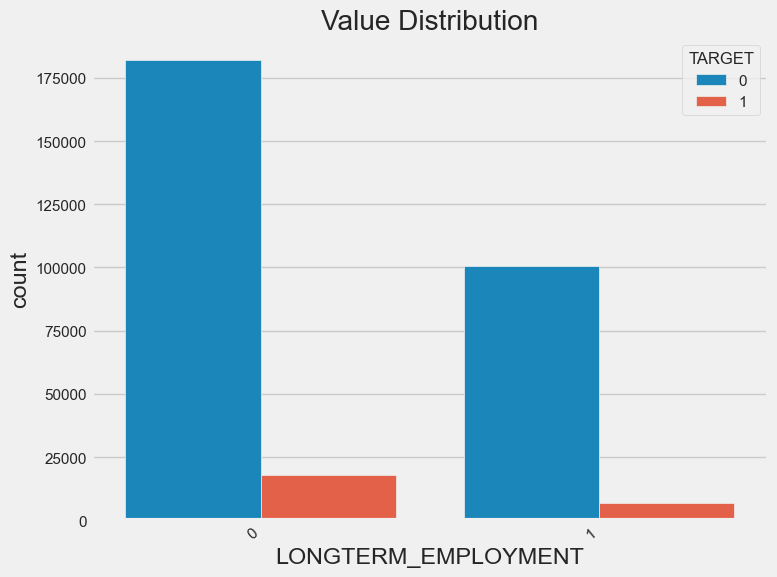

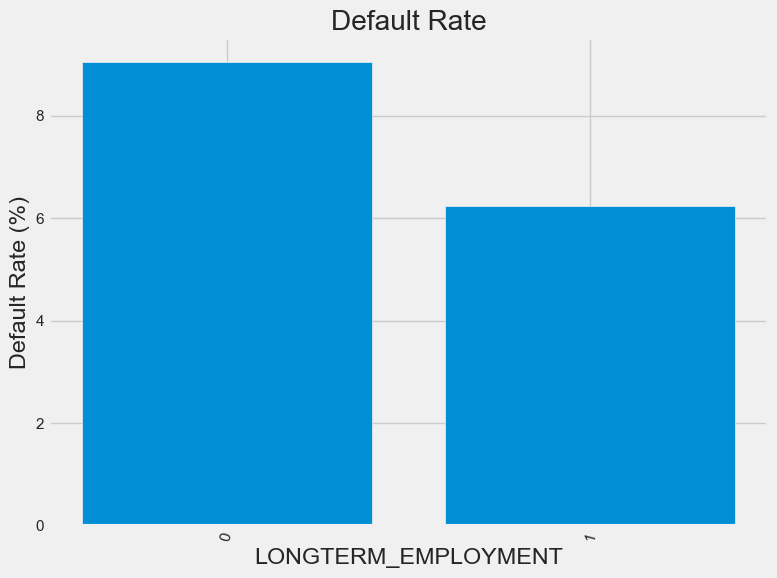

In [265]:
# Empleo a Largo Plazo

filter_cols = ['LONGTERM_EMPLOYMENT']

employment_data = app_train[filter_cols].astype("category")

employment_data['TARGET'] = app_train['TARGET']

show_default_rate(employment_data, 'Long-term Employment')


Data Set Name:Any Children

Any Children Column Name: ANY_CHILDREN



Count       Percentage (%)    Paid             Paid (%)  \
ANY_CHILDREN                                                             
1              92140                29.96   83924                91.08   
0             215371                70.04  198762                92.29   

              Unpaid     Default Rate (%)  
ANY_CHILDREN                               
1               8216                 8.92  
0              16609                 7.71

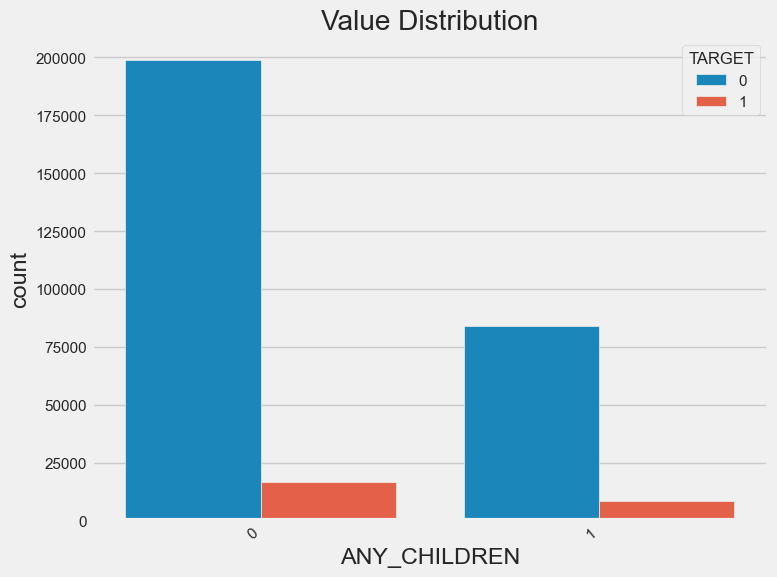

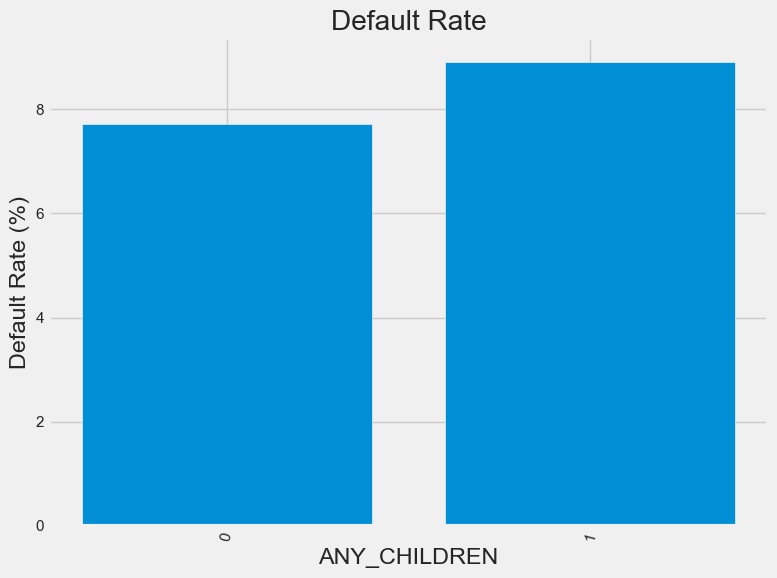


Data Set Name:Family

Family Column Name: NAME_FAMILY_STATUS



Count       Percentage (%)    Paid  \
NAME_FAMILY_STATUS                                          
Civil marriage         29775                 9.68   26814   
Single / not married   45444                14.78   40987   
Separated              19770                 6.43   18150   
Married               196432                63.88  181582   
Widow                  16088                 5.23   15151   
Unknown                    2                 0.00       2   

                                 Paid (%)               Unpaid  \
NAME_FAMILY_STATUS                                               
Civil marriage                      90.06             2,961.00   
Single / not married                90.19             4,457.00   
Separated                           91.81             1,620.00   
Married                             92.44            14,850.00   
Widow                               94.18               937.00   
Unknown                            100.00                 0.00   

                         Default Rate (%)  
NAME_FAMILY_STATUS                         
Civil marriage                       9.94  
Single / not married                 9.81  
Separated                            8.19  
Married                              7.56  
Widow                                5.82  
Unknown                              0.00

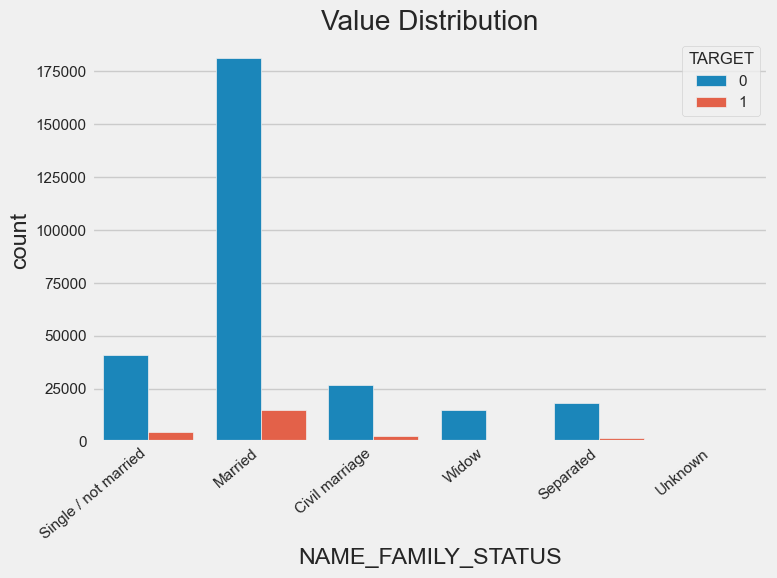

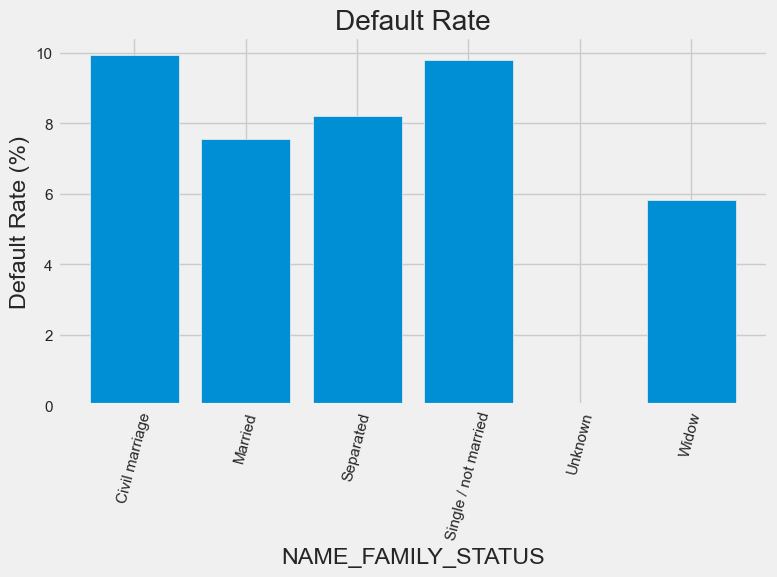


Family Column Name: CNT_CHIDREN_RANGE



Count       Percentage (%)    Paid             Paid (%)  \
CNT_CHIDREN_RANGE                                                             
3 or More            4272                 1.39    3843                89.96   
1                   61119                19.88   55665                91.08   
2                   26749                 8.70   24416                91.28   
0                  215371                70.04  198762                92.29   

                   Unpaid     Default Rate (%)  
CNT_CHIDREN_RANGE                               
3 or More             429                10.04  
1                    5454                 8.92  
2                    2333                 8.72  
0                   16609                 7.71

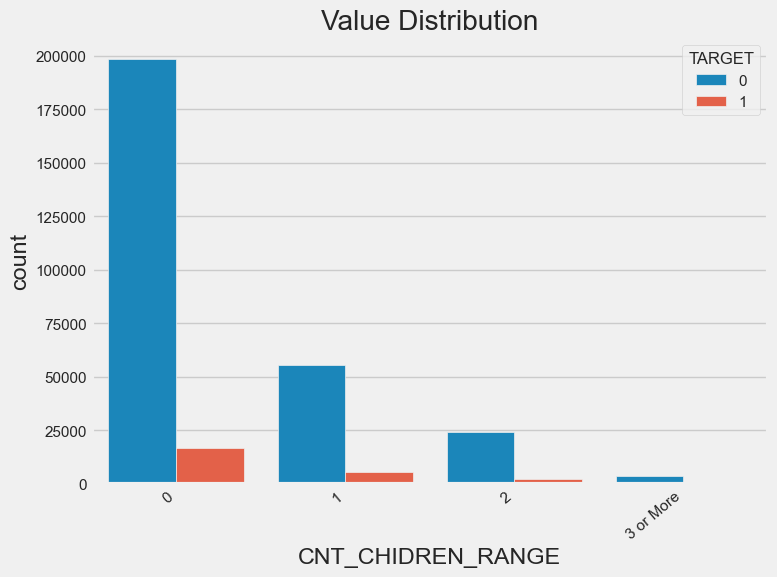

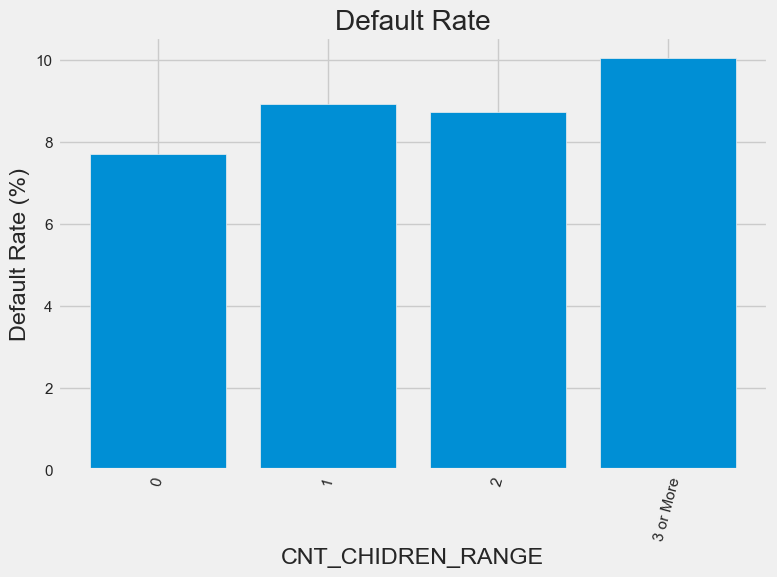


Family Column Name: CNT_FAM_MEMBERS_RANGE



Count       Percentage (%)    Paid  \
CNT_FAM_MEMBERS_RANGE                                        
5 or More                4009                 1.30    3612   
3.0                     52601                17.11   47993   
4.0                     24697                 8.03   22561   
1.0                     67847                22.06   62172   
2.0                    158357                51.50  146348   

                                  Paid (%)  Unpaid     Default Rate (%)  
CNT_FAM_MEMBERS_RANGE                                                    
5 or More                            90.10     397                 9.90  
3.0                                  91.24    4608                 8.76  
4.0                                  91.35    2136                 8.65  
1.0                                  91.64    5675                 8.36  
2.0                                  92.42   12009                 7.58

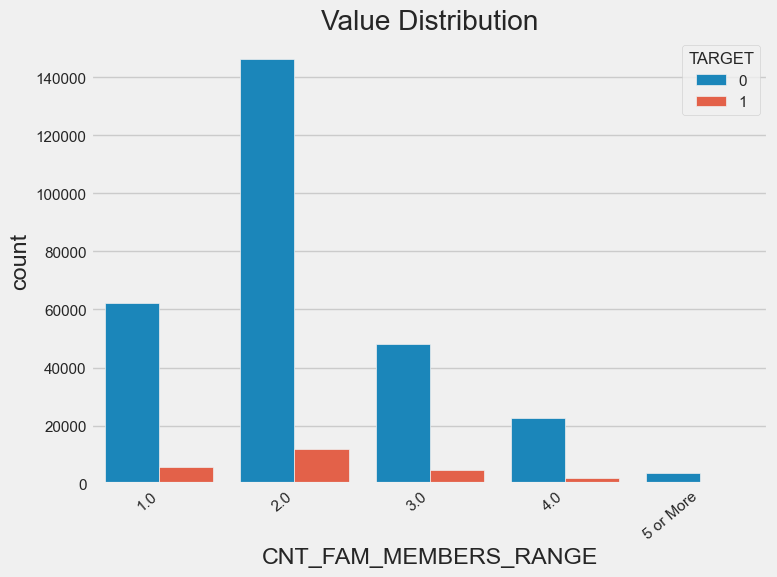

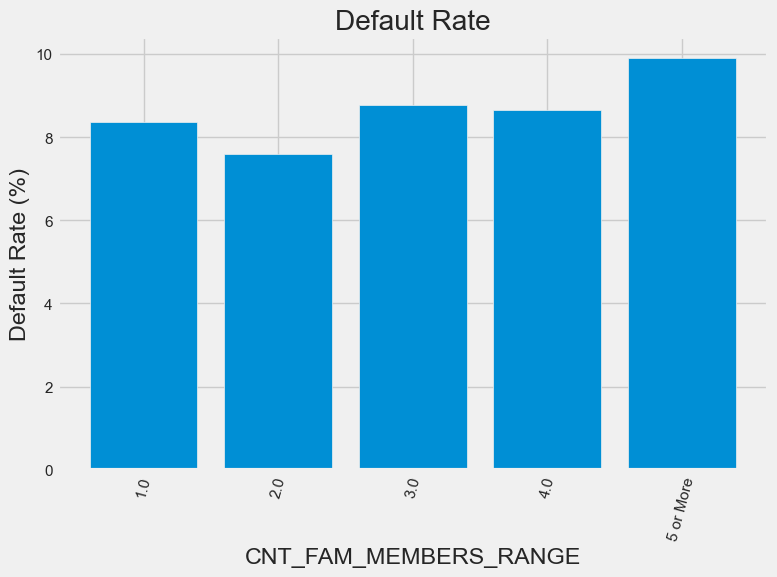

In [266]:
# Datos familiares

filter_cols = ['ANY_CHILDREN']

family_data = app_train[filter_cols].astype("category")

family_data['TARGET'] = app_train['TARGET']

show_default_rate(family_data, 'Any Children')

del family_data

app_train['CNT_CHIDREN_RANGE'] = app_train['CNT_CHILDREN'].map(lambda x: str(x) if x  < 3 else "3 or More" )

app_train['CNT_FAM_MEMBERS_RANGE'] = app_train['CNT_FAM_MEMBERS'].map(lambda x: str(x) if x  < 5 else "5 or More" )

show_default_rate(app_train.loc[:,['ANY_CHILDREN', 'NAME_FAMILY_STATUS', 'CNT_CHIDREN_RANGE', 'CNT_FAM_MEMBERS_RANGE', 'TARGET']], 'Family')

# Eliminar las columnas de rangos
filter_cols = ['CNT_CHIDREN_RANGE', 'CNT_FAM_MEMBERS_RANGE']
app_train = app_train.drop(columns = filter_cols)


Data Set Name:Any Children

Any Children Column Name: ANY_CHILDREN



Count       Percentage (%)    Paid             Paid (%)  \
ANY_CHILDREN                                                             
1              92140                29.96   83924                91.08   
0             215371                70.04  198762                92.29   

              Unpaid     Default Rate (%)  
ANY_CHILDREN                               
1               8216                 8.92  
0              16609                 7.71

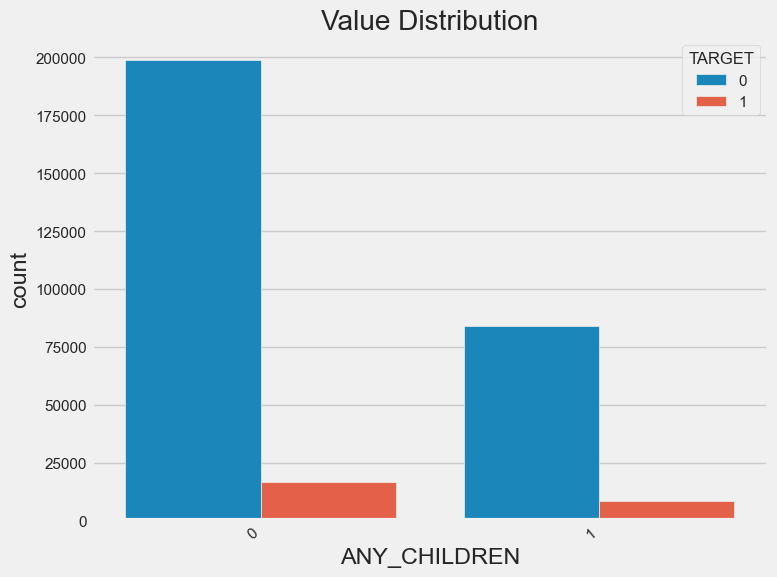

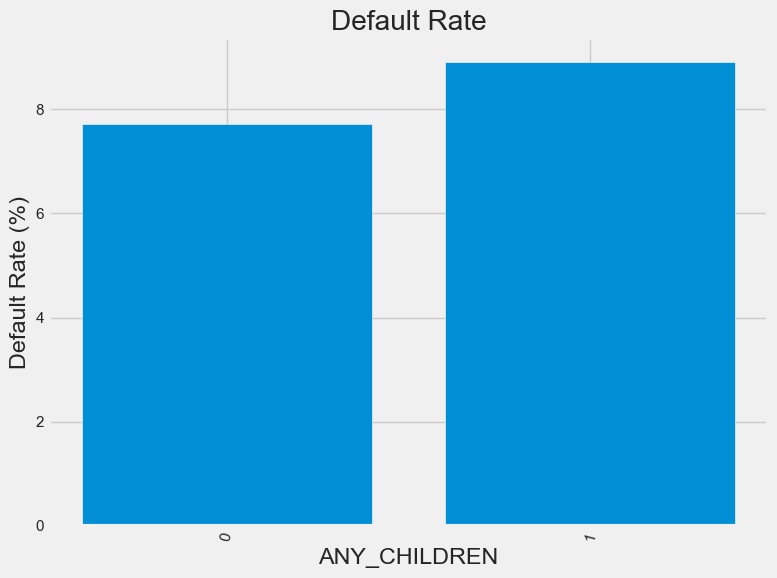


Data Set Name:Family

Family Column Name: NAME_FAMILY_STATUS



Count       Percentage (%)    Paid  \
NAME_FAMILY_STATUS                                          
Civil marriage         29775                 9.68   26814   
Single / not married   45444                14.78   40987   
Separated              19770                 6.43   18150   
Married               196432                63.88  181582   
Widow                  16088                 5.23   15151   
Unknown                    2                 0.00       2   

                                 Paid (%)               Unpaid  \
NAME_FAMILY_STATUS                                               
Civil marriage                      90.06             2,961.00   
Single / not married                90.19             4,457.00   
Separated                           91.81             1,620.00   
Married                             92.44            14,850.00   
Widow                               94.18               937.00   
Unknown                            100.00                 0.00   

                         Default Rate (%)  
NAME_FAMILY_STATUS                         
Civil marriage                       9.94  
Single / not married                 9.81  
Separated                            8.19  
Married                              7.56  
Widow                                5.82  
Unknown                              0.00

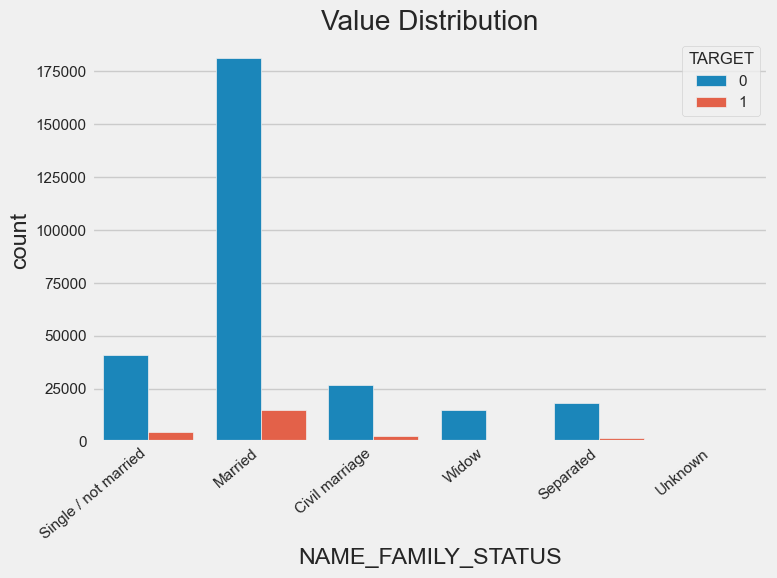

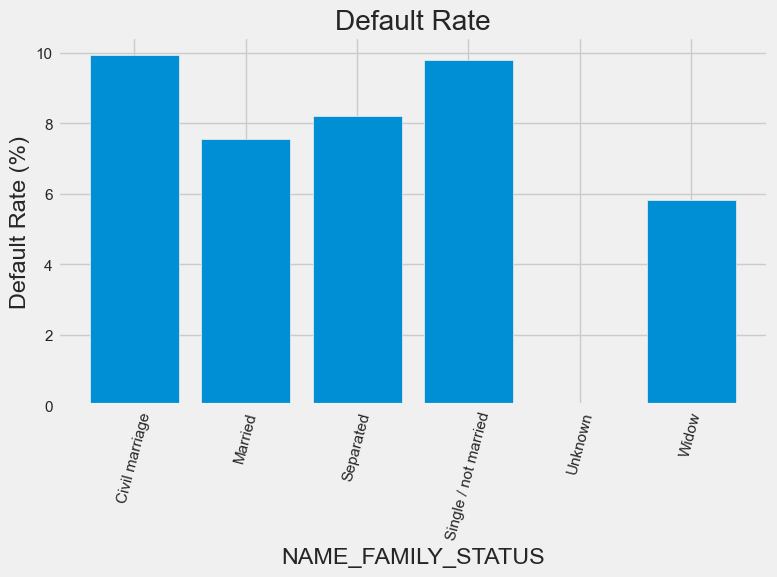


Family Column Name: CNT_CHIDREN_RANGE



Count       Percentage (%)    Paid             Paid (%)  \
CNT_CHIDREN_RANGE                                                             
3 or More            4272                 1.39    3843                89.96   
1                   61119                19.88   55665                91.08   
2                   26749                 8.70   24416                91.28   
0                  215371                70.04  198762                92.29   

                   Unpaid     Default Rate (%)  
CNT_CHIDREN_RANGE                               
3 or More             429                10.04  
1                    5454                 8.92  
2                    2333                 8.72  
0                   16609                 7.71

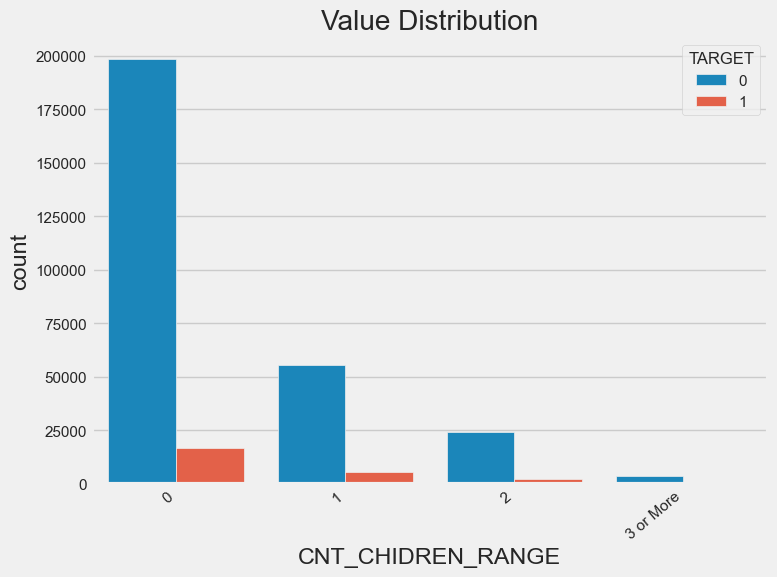

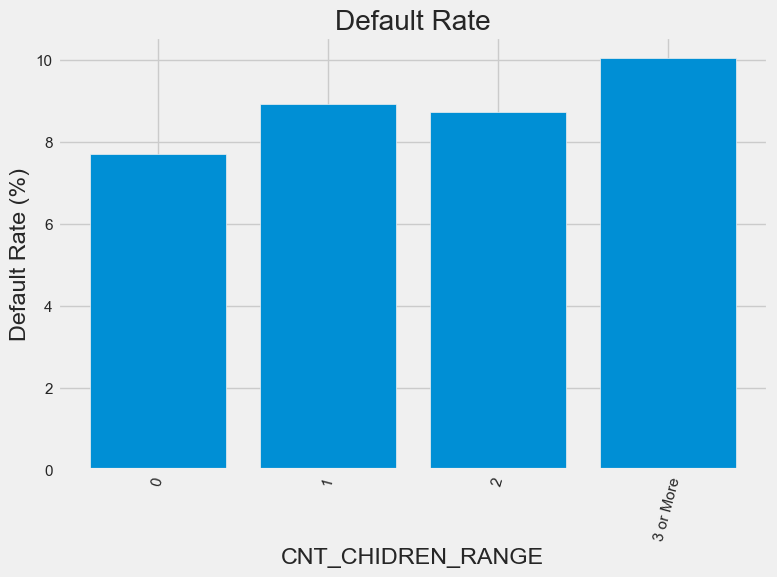


Family Column Name: CNT_FAM_MEMBERS_RANGE



Count       Percentage (%)    Paid  \
CNT_FAM_MEMBERS_RANGE                                        
5 or More                4009                 1.30    3612   
3.0                     52601                17.11   47993   
4.0                     24697                 8.03   22561   
1.0                     67847                22.06   62172   
2.0                    158357                51.50  146348   

                                  Paid (%)  Unpaid     Default Rate (%)  
CNT_FAM_MEMBERS_RANGE                                                    
5 or More                            90.10     397                 9.90  
3.0                                  91.24    4608                 8.76  
4.0                                  91.35    2136                 8.65  
1.0                                  91.64    5675                 8.36  
2.0                                  92.42   12009                 7.58

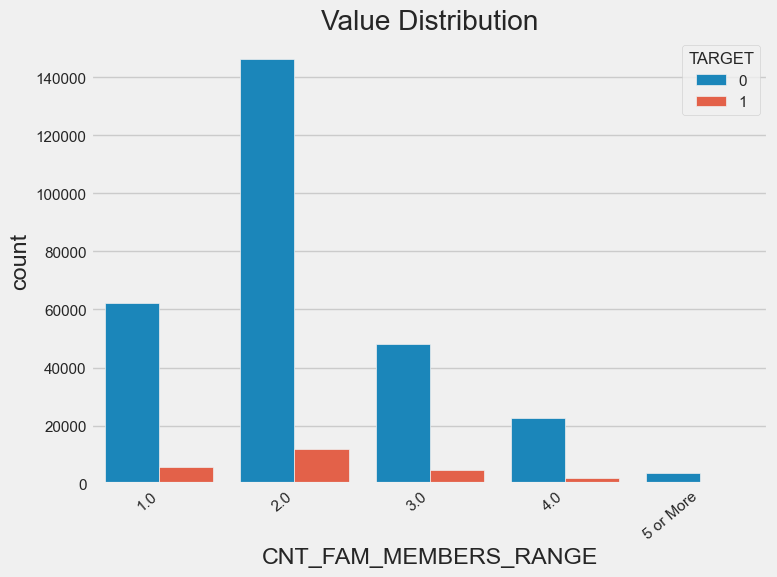

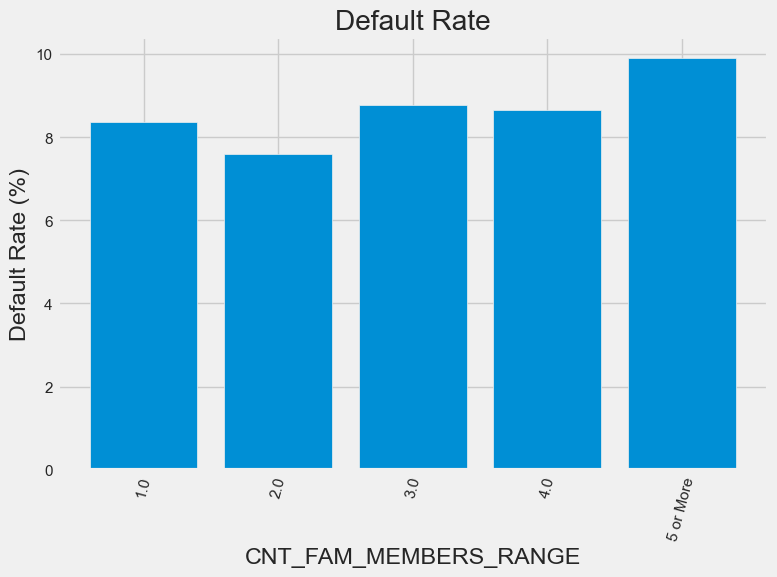

In [267]:
# Datos familiares
filter_cols = ['ANY_CHILDREN']

family_data = app_train[filter_cols].astype("category")
family_data['TARGET'] = app_train['TARGET']

show_default_rate(family_data, 'Any Children')

del family_data

# Crear las columnas de rangos
app_train['CNT_CHIDREN_RANGE'] = app_train['CNT_CHILDREN'].map(lambda x: str(x) if x < 3 else "3 or More")
app_train['CNT_FAM_MEMBERS_RANGE'] = app_train['CNT_FAM_MEMBERS'].map(lambda x: str(x) if x < 5 else "5 or More")

# Usar ANY_CHILDREN en lugar de HAS_CHILDREN
show_default_rate(app_train.loc[:, ['ANY_CHILDREN', 'NAME_FAMILY_STATUS', 'CNT_CHIDREN_RANGE', 'CNT_FAM_MEMBERS_RANGE', 'TARGET']], 'Family')

# Eliminar las columnas de rangos
filter_cols = ['CNT_CHIDREN_RANGE', 'CNT_FAM_MEMBERS_RANGE']
app_train = app_train.drop(columns=filter_cols)

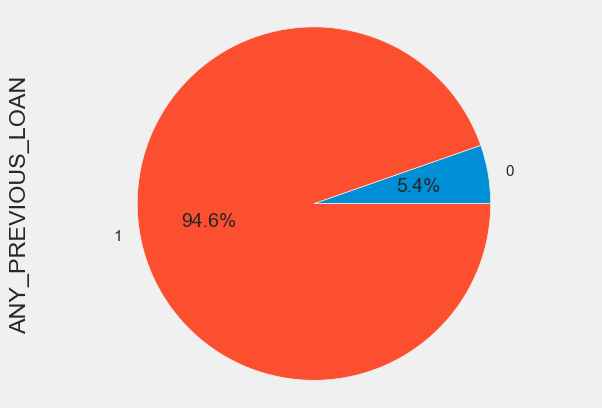

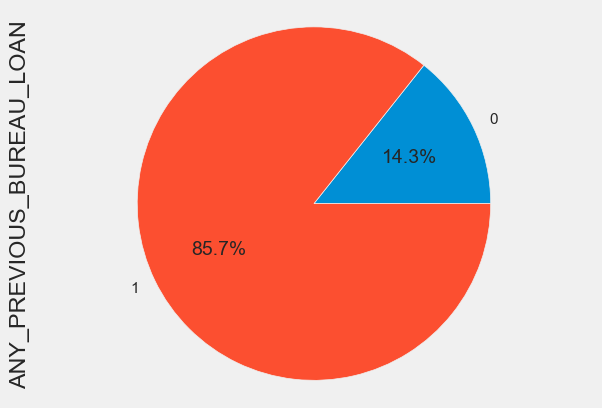

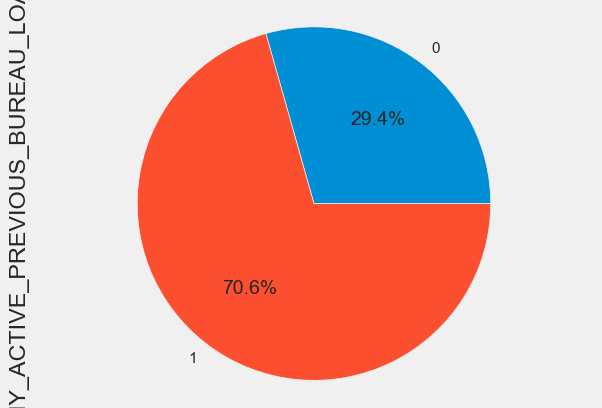

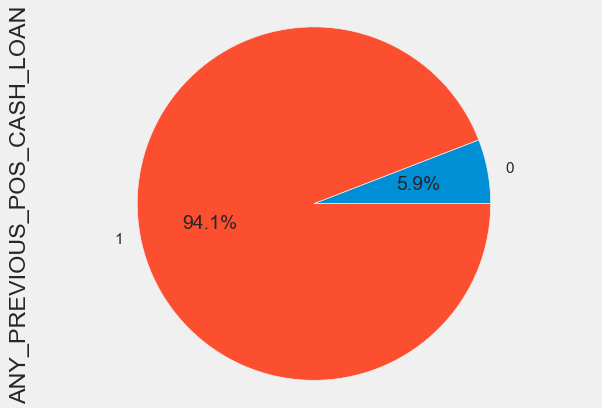

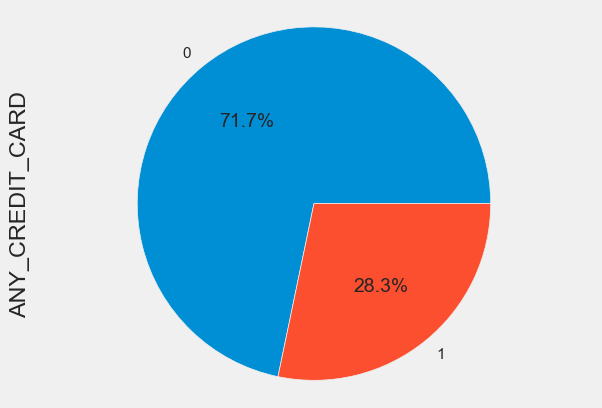

In [268]:
# Mostrar cómo cada archivo agregado complementa los datos iniciales de entrenamiento

aggregate_loan_data = app_train[['PREVIOUS_LOAN_COUNT']]
aggregate_loan_data['ANY_PREVIOUS_LOAN'] = aggregate_loan_data['PREVIOUS_LOAN_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_PREVIOUS_LOAN'].groupby(aggregate_loan_data['ANY_PREVIOUS_LOAN']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

aggregate_loan_data = app_train[['BUREAU_PREVIOUS_LOAN_COUNT']]
aggregate_loan_data['ANY_PREVIOUS_BUREAU_LOAN'] = aggregate_loan_data['BUREAU_PREVIOUS_LOAN_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_PREVIOUS_BUREAU_LOAN'].groupby(aggregate_loan_data['ANY_PREVIOUS_BUREAU_LOAN']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

aggregate_loan_data = app_train[['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT']]
aggregate_loan_data['ANY_ACTIVE_PREVIOUS_BUREAU_LOAN'] = aggregate_loan_data['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_ACTIVE_PREVIOUS_BUREAU_LOAN'].groupby(aggregate_loan_data['ANY_ACTIVE_PREVIOUS_BUREAU_LOAN']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

aggregate_loan_data = app_train[['POS_CASH_COUNT']]
aggregate_loan_data['ANY_PREVIOUS_POS_CASH_LOAN'] = aggregate_loan_data['POS_CASH_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_PREVIOUS_POS_CASH_LOAN'].groupby(aggregate_loan_data['ANY_PREVIOUS_POS_CASH_LOAN']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

aggregate_loan_data = app_train[['CREDIT_CARD_COUNT']]
aggregate_loan_data['ANY_CREDIT_CARD'] = aggregate_loan_data['CREDIT_CARD_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_CREDIT_CARD'].groupby(aggregate_loan_data['ANY_CREDIT_CARD']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()


Data Set Name:Total Credit Amount Range

Total Credit Amount Range Column Name: ALL_ACTIVE_CREDIT_AMT_RANGE



Count       Percentage (%)   Paid  \
ALL_ACTIVE_CREDIT_AMT_RANGE                                      
< 650000                     11859                 3.86  10672   
< 550000                     11880                 3.86  10745   
< 450000                     12585                 4.09  11436   
< 750000                     10819                 3.52   9840   
< 1000000                    21963                 7.14  20139   
< 350000                      6790                 2.21   6227   
< 250000                      2327                 0.76   2154   
< 275000                      3259                 1.06   3017   
< 1350000                    19089                 6.21  17672   
< 300000                      3213                 1.04   2976   
< 225000                      7052                 2.29   6603   
< 4100000                    18504                 6.02  17339   

                                        Paid (%)  Unpaid     Default Rate (%)  
ALL_ACTIVE_CREDIT_AMT_RANGE                                                    
< 650000                                   89.99    1187                10.01  
< 550000                                   90.45    1135                 9.55  
< 450000                                   90.87    1149                 9.13  
< 750000                                   90.95     979                 9.05  
< 1000000                                  91.70    1824                 8.30  
< 350000                                   91.71     563                 8.29  
< 250000                                   92.57     173                 7.43  
< 275000                                   92.57     242                 7.43  
< 1350000                                  92.58    1417                 7.42  
< 300000                                   92.62     237                 7.38  
< 225000                                   93.63     449                 6.37  
< 4100000                                  93.70    1165                 6.30

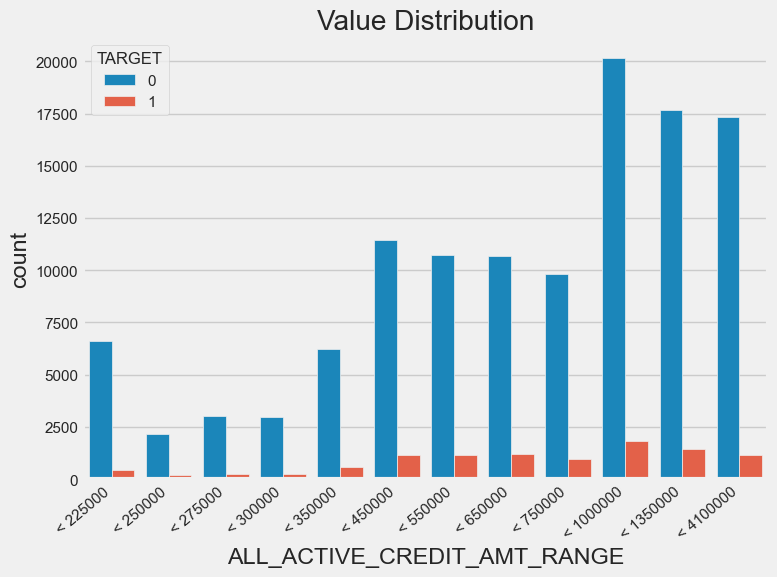

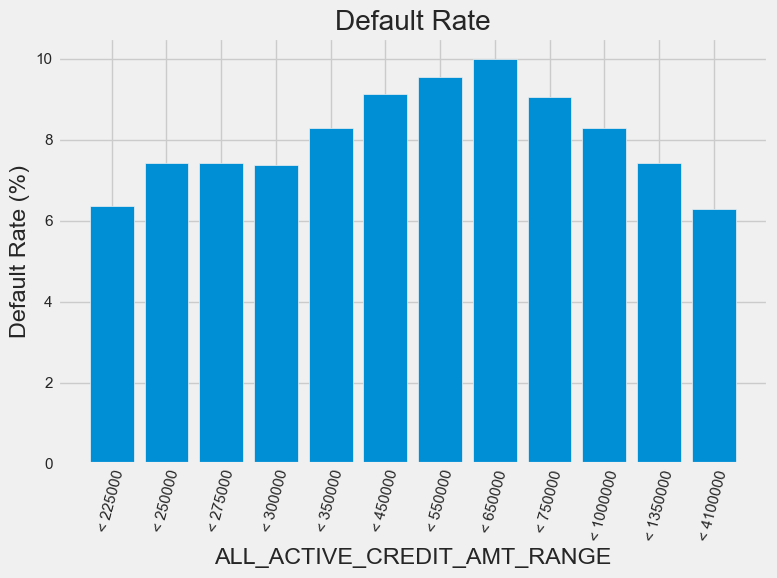

In [269]:
# Cantidad Total de Crédito

bins = np.linspace(0, 4050000, 10)
bins = (0, 225000,  250000, 275000, 300000, 350000, 450000,  550000, 650000, 750000, 1000000, 1350000, 4100000)
labels = ['< 225000',  '< 250000', '< 275000', '< 300000', '< 350000', '< 450000', '< 550000', '< 650000', '< 750000', '< 1000000', '< 1350000', '< 4100000']

app_train['ALL_ACTIVE_CREDIT_AMT_RANGE'] = pd.cut((app_train['AMT_CREDIT'] + app_train['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']), bins=bins, labels=labels)
show_default_rate(app_train.loc[:,['ALL_ACTIVE_CREDIT_AMT_RANGE', 'TARGET']], 'Total Credit Amount Range')



In [270]:
# Eliminar las columnas de rangos
filter_cols = ['ALL_ACTIVE_CREDIT_AMT_RANGE']
app_train = app_train.drop(columns = filter_cols)

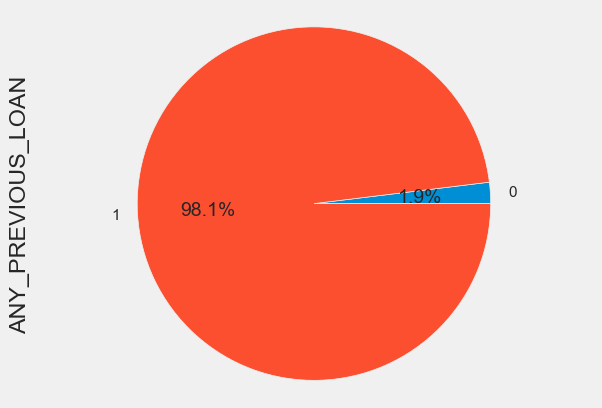

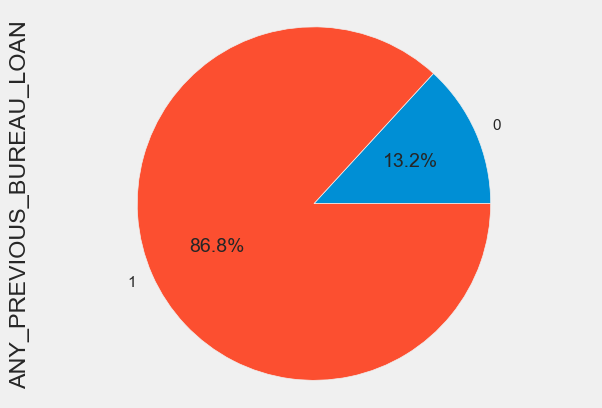

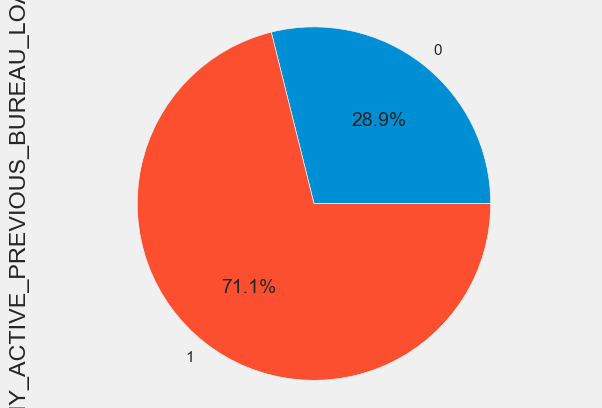

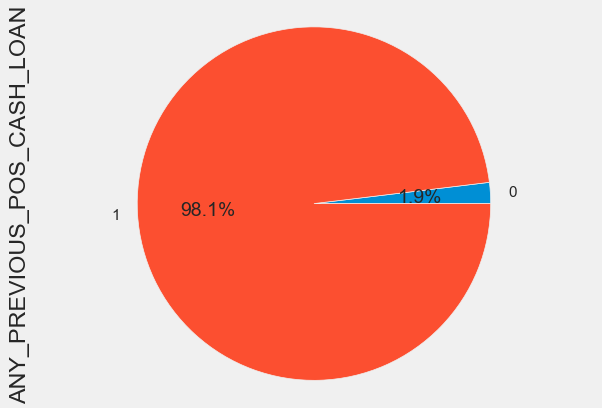

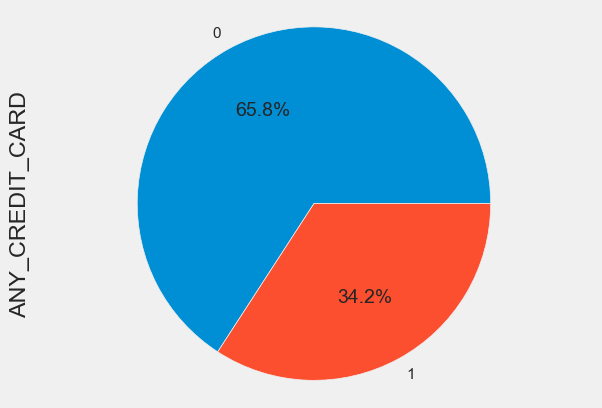

In [271]:
# Mostrar cómo cada archivo agregado complementa los datos de prueba iniciales
aggregate_loan_data = app_test[[ 'PREVIOUS_LOAN_COUNT']]
aggregate_loan_data['ANY_PREVIOUS_LOAN'] = aggregate_loan_data['PREVIOUS_LOAN_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_PREVIOUS_LOAN'].groupby(aggregate_loan_data['ANY_PREVIOUS_LOAN']).count().plot(kind='pie', autopct='%1.1f%%', )
plt.axis('equal')
plt.show()

aggregate_loan_data = app_test[['BUREAU_PREVIOUS_LOAN_COUNT']]
aggregate_loan_data['ANY_PREVIOUS_BUREAU_LOAN'] = aggregate_loan_data['BUREAU_PREVIOUS_LOAN_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_PREVIOUS_BUREAU_LOAN'].groupby(aggregate_loan_data['ANY_PREVIOUS_BUREAU_LOAN']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

aggregate_loan_data = app_test[['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT']]
aggregate_loan_data['ANY_ACTIVE_PREVIOUS_BUREAU_LOAN'] = aggregate_loan_data['BUREAU_ACTIVE_PREVIOUS_LOAN_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_ACTIVE_PREVIOUS_BUREAU_LOAN'].groupby(aggregate_loan_data['ANY_ACTIVE_PREVIOUS_BUREAU_LOAN']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

aggregate_loan_data = app_test[['POS_CASH_COUNT']]
aggregate_loan_data['ANY_PREVIOUS_POS_CASH_LOAN'] = aggregate_loan_data['POS_CASH_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_PREVIOUS_POS_CASH_LOAN'].groupby(aggregate_loan_data['ANY_PREVIOUS_POS_CASH_LOAN']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

aggregate_loan_data = app_test[['CREDIT_CARD_COUNT']]
aggregate_loan_data['ANY_CREDIT_CARD'] = aggregate_loan_data['CREDIT_CARD_COUNT'].map(lambda x: 1 if x > 0 else 0)

aggregate_loan_data['ANY_CREDIT_CARD'].groupby(aggregate_loan_data['ANY_CREDIT_CARD']).count().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

## XI - Preprocesamiento: Variables Categóricas
 
Preprocesaremos las variables categóricas con:
 
* **codificación de etiquetas** para variables categóricas con solo dos valores posibles.
* **codificación one-hot** para variables categóricas con más de dos valores posibles.



In [272]:
# Mostrar muestra de variables categóricas con solo dos valores posibles, según lo listado en la función auxiliar

filter_col = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY']

In [273]:
app_train[filter_col].head(10)

NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY
0         Cash loans            N               Y
1         Cash loans            N               N
2    Revolving loans            Y               Y
3         Cash loans            N               Y
4         Cash loans            N               Y
5         Cash loans            N               Y
6         Cash loans            Y               Y
7         Cash loans            Y               Y
8         Cash loans            N               Y
9    Revolving loans            N               Y

In [274]:
app_test[filter_col].head(10)

NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY
0         Cash loans            N               Y
1         Cash loans            N               Y
2         Cash loans            Y               Y
3         Cash loans            N               Y
4         Cash loans            Y               N
5         Cash loans            Y               Y
6         Cash loans            Y               Y
7         Cash loans            N               Y
8         Cash loans            N               Y
9         Cash loans            Y               Y

In [275]:
# Crear un objeto codificador de etiquetas
le = LabelEncoder()

# Iterar a través de las columnas
for i, source in enumerate(list(app_train.select_dtypes(include=['object']).columns)):     
     if len(list(app_train[source].unique())) <= 2 and len(list(app_test[source].unique())) <= 2:
         print('Label encoding '+source)
         # Train on the training data
         le.fit(app_train[source])
         # Transform both training and testing data
         app_train[source] = le.transform(app_train[source])
         app_test[source] = le.transform(app_test[source])

Label encoding NAME_CONTRACT_TYPE
Label encoding FLAG_OWN_CAR
Label encoding FLAG_OWN_REALTY


In [276]:
# Mostrar muestra después de la codificación de etiquetas

app_train[filter_col].head(10)

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY
0                   0             0                1
1                   0             0                0
2                   1             1                1
3                   0             0                1
4                   0             0                1
5                   0             0                1
6                   0             1                1
7                   0             1                1
8                   0             0                1
9                   1             0                1

In [277]:
app_test[filter_col].head(10)

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY
0                   0             0                1
1                   0             0                1
2                   0             1                1
3                   0             0                1
4                   0             1                0
5                   0             1                1
6                   0             1                1
7                   0             0                1
8                   0             0                1
9                   0             1                1

In [278]:
# Mostrar muestra y tamaño del conjunto de datos de entrenamiento antes de la codificación one-hot

display(app_train.head(10))

print('Training Features shape: ', app_train.shape)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0           M             0   
1      100003       0                   0           F             0   
2      100004       0                   1           M             1   
3      100006       0                   0           F             0   
4      100007       0                   0           M             0   
5      100008       0                   0           M             0   
6      100009       0                   0           F             1   
7      100010       0                   0           M             1   
8      100011       0                   0           F             0   
9      100012       0                   1           M             0   

   FLAG_OWN_REALTY  CNT_CHILDREN     AMT_INCOME_TOTAL           AMT_CREDIT  \
0                1             0           202,500.00           406,597.50   
1                0             0           270,000.00         1,293,502.50   
2                1             0            67,500.00           135,000.00   
3                1             0           135,000.00           312,682.50   
4                1             0           121,500.00           513,000.00   
5                1             0            99,000.00           490,495.50   
6                1             1           171,000.00         1,560,726.00   
7                1             0           360,000.00         1,530,000.00   
8                1             0           112,500.00         1,019,610.00   
9                1             0           135,000.00           405,000.00   

           AMT_ANNUITY  ...  POS_CASH_SK_DPD_DEF_max_SUM  \
0            24,700.50  ...                         0.00   
1            35,698.50  ...                         0.00   
2             6,750.00  ...                         0.00   
3            29,686.50  ...                         0.00   
4            21,865.50  ...                         0.00   
5            27,517.50  ...                         0.00   
6            41,301.00  ...                         0.00   
7            42,075.00  ...                         0.00   
8            33,826.50  ...                         0.00   
9            20,250.00  ...                         0.00   

  POS_CASH_SK_DPD_DEF_min_MEAN POS_CASH_SK_DPD_DEF_min_MAX  \
0                         0.00                        0.00   
1                         0.00                        0.00   
2                         0.00                        0.00   
3                        94.00                        0.00   
4                         0.00                        0.00   
5                         0.00                        0.00   
6                         0.00                        0.00   
7                         9.00                        0.00   
8                         0.00                        0.00   
9                         0.00                        0.00   

  POS_CASH_SK_DPD_DEF_min_MIN POS_CASH_SK_DPD_DEF_min_SUM  \
0                        0.00                        0.00   
1                        0.00                        0.00   
2                        0.00                        0.00   
3                        0.00                        0.00   
4                        0.00                        0.00   
5                        0.00                        0.00   
6                        0.00                        0.00   
7                        0.00                        0.00   
8                        0.00                        0.00   
9                        0.00                        0.00   

  POS_CASH_SK_DPD_DEF_sum_MEAN  POS_CASH_SK_DPD_DEF_sum_MAX  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.00                         0.00   
3                         0.00                        56.75   
4                         0.00 

Training Features shape:  (307511, 995)


In [279]:
# codificación one-hot de variables categóricas
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [280]:
# Mostrar muestra y tamaño del conjunto de datos de entrenamiento después de la codificación one-hot

display(app_train.head(10))

print('Train Features shape: ', app_train.shape)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1                   0             0                1   
1      100003       0                   0             0                0   
2      100004       0                   1             1                1   
3      100006       0                   0             0                1   
4      100007       0                   0             0                1   
5      100008       0                   0             0                1   
6      100009       0                   0             1                1   
7      100010       0                   0             1                1   
8      100011       0                   0             0                1   
9      100012       0                   1             0                1   

   CNT_CHILDREN     AMT_INCOME_TOTAL           AMT_CREDIT  \
0             0           202,500.00           406,597.50   
1             0           270,000.00         1,293,502.50   
2             0            67,500.00           135,000.00   
3             0           135,000.00           312,682.50   
4             0           121,500.00           513,000.00   
5             0            99,000.00           490,495.50   
6             1           171,000.00         1,560,726.00   
7             0           360,000.00         1,530,000.00   
8             0           112,500.00         1,019,610.00   
9             0           135,000.00           405,000.00   

           AMT_ANNUITY      AMT_GOODS_PRICE  ...  \
0            24,700.50           351,000.00  ...   
1            35,698.50         1,129,500.00  ...   
2             6,750.00           135,000.00  ...   
3            29,686.50           297,000.00  ...   
4            21,865.50           513,000.00  ...   
5            27,517.50           454,500.00  ...   
6            41,301.00         1,395,000.00  ...   
7            42,075.00         1,530,000.00  ...   
8            33,826.50           913,500.00  ...   
9            20,250.00           405,000.00  ...   

   WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                             True                      False   
1                            False                      False   
2                            False                      False   
3                            False                      False   
4                            False                      False   
5                            False                      False   
6                            False                      False   
7                            False                      False   
8                            False                      False   
9                            False                      False   

   EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                    True                    False   
1                    True                    False   
2                   False                    False   
3                   False                    False   
4                   False                    False   
5                   False                    False   
6                   False                    False   
7                   False                    False   
8                   False                    False   
9                   False                    False   

   AMT_REQ_CREDIT_BUREAU_YEAR_RANGE_0.0  AMT_REQ_CREDIT_BUREAU_YEAR_RANGE_1.0  \
0                                 False                                  True   
1                                  True                                 False   
2                                  True                                 False   
3                                 False                                 False   
4                                  True                                 False   
5                                 False                                  True   
6                                 False    

Train Features shape:  (307511, 1121)


In [281]:
# Mostrar muestra y tamaño del conjunto de datos de prueba después de la codificación one-hot

display(app_test.head(10))

print('Test Features shape: ', app_test.shape)

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100001                   0             0                1   
1      100005                   0             0                1   
2      100013                   0             1                1   
3      100028                   0             0                1   
4      100038                   0             1                0   
5      100042                   0             1                1   
6      100057                   0             1                1   
7      100065                   0             0                1   
8      100066                   0             0                1   
9      100067                   0             1                1   

   CNT_CHILDREN     AMT_INCOME_TOTAL           AMT_CREDIT  \
0             0           135,000.00           568,800.00   
1             0            99,000.00           222,768.00   
2             0           202,500.00           663,264.00   
3             2           315,000.00         1,575,000.00   
4             1           180,000.00           625,500.00   
5             0           270,000.00           959,688.00   
6             2           180,000.00           499,221.00   
7             0           166,500.00           180,000.00   
8             0           315,000.00           364,896.00   
9             1           162,000.00            45,000.00   

           AMT_ANNUITY      AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  ...  \
0            20,560.50           450,000.00                        0.02  ...   
1            17,370.00           180,000.00                        0.04  ...   
2            69,777.00           630,000.00                        0.02  ...   
3            49,018.50         1,575,000.00                        0.03  ...   
4            32,067.00           625,500.00                        0.01  ...   
5            34,600.50           810,000.00                        0.03  ...   
6            22,117.50           373,500.00                        0.02  ...   
7            14,220.00           180,000.00                        0.01  ...   
8            28,957.50           315,000.00                        0.05  ...   
9             5,337.00            45,000.00                        0.02  ...   

   HOUSETYPE_MODE_terraced house  WALLSMATERIAL_MODE_Block  \
0                          False                     False   
1                          False                     False   
2                          False                     False   
3                          False                     False   
4                          False                     False   
5                          False                      True   
6                          False                     False   
7                          False                     False   
8                          False                     False   
9                          False                     False   

   WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
0                     False                          False   
1                     False                          False   
2                     False                          False   
3                     False                          False   
4                     False                          False   
5                     False                          False   
6                     False                          False   
7                     False                          False   
8                     False                          False   
9                     False                          False   

   WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                      False                     False   
1                      False                     False   
2                      False                     False   
3                      False                      True   
4                      False                 

Test Features shape:  (48744, 1109)


In [282]:
# Arreglar nombres de columnas desordenados

format_colnames(app_train, 'Train')

format_colnames(app_test, 'Test')


Nombre del conjunto de datos:Train


Formateando nombres de columnas:

Nombre del conjunto de datos:Test


Formateando nombres de columnas:


In [ ]:
# Mostrar correlaciones con la variable objetivo
#show_correlations(app_train, 'Training')


Nombre del conjunto de datos:Training


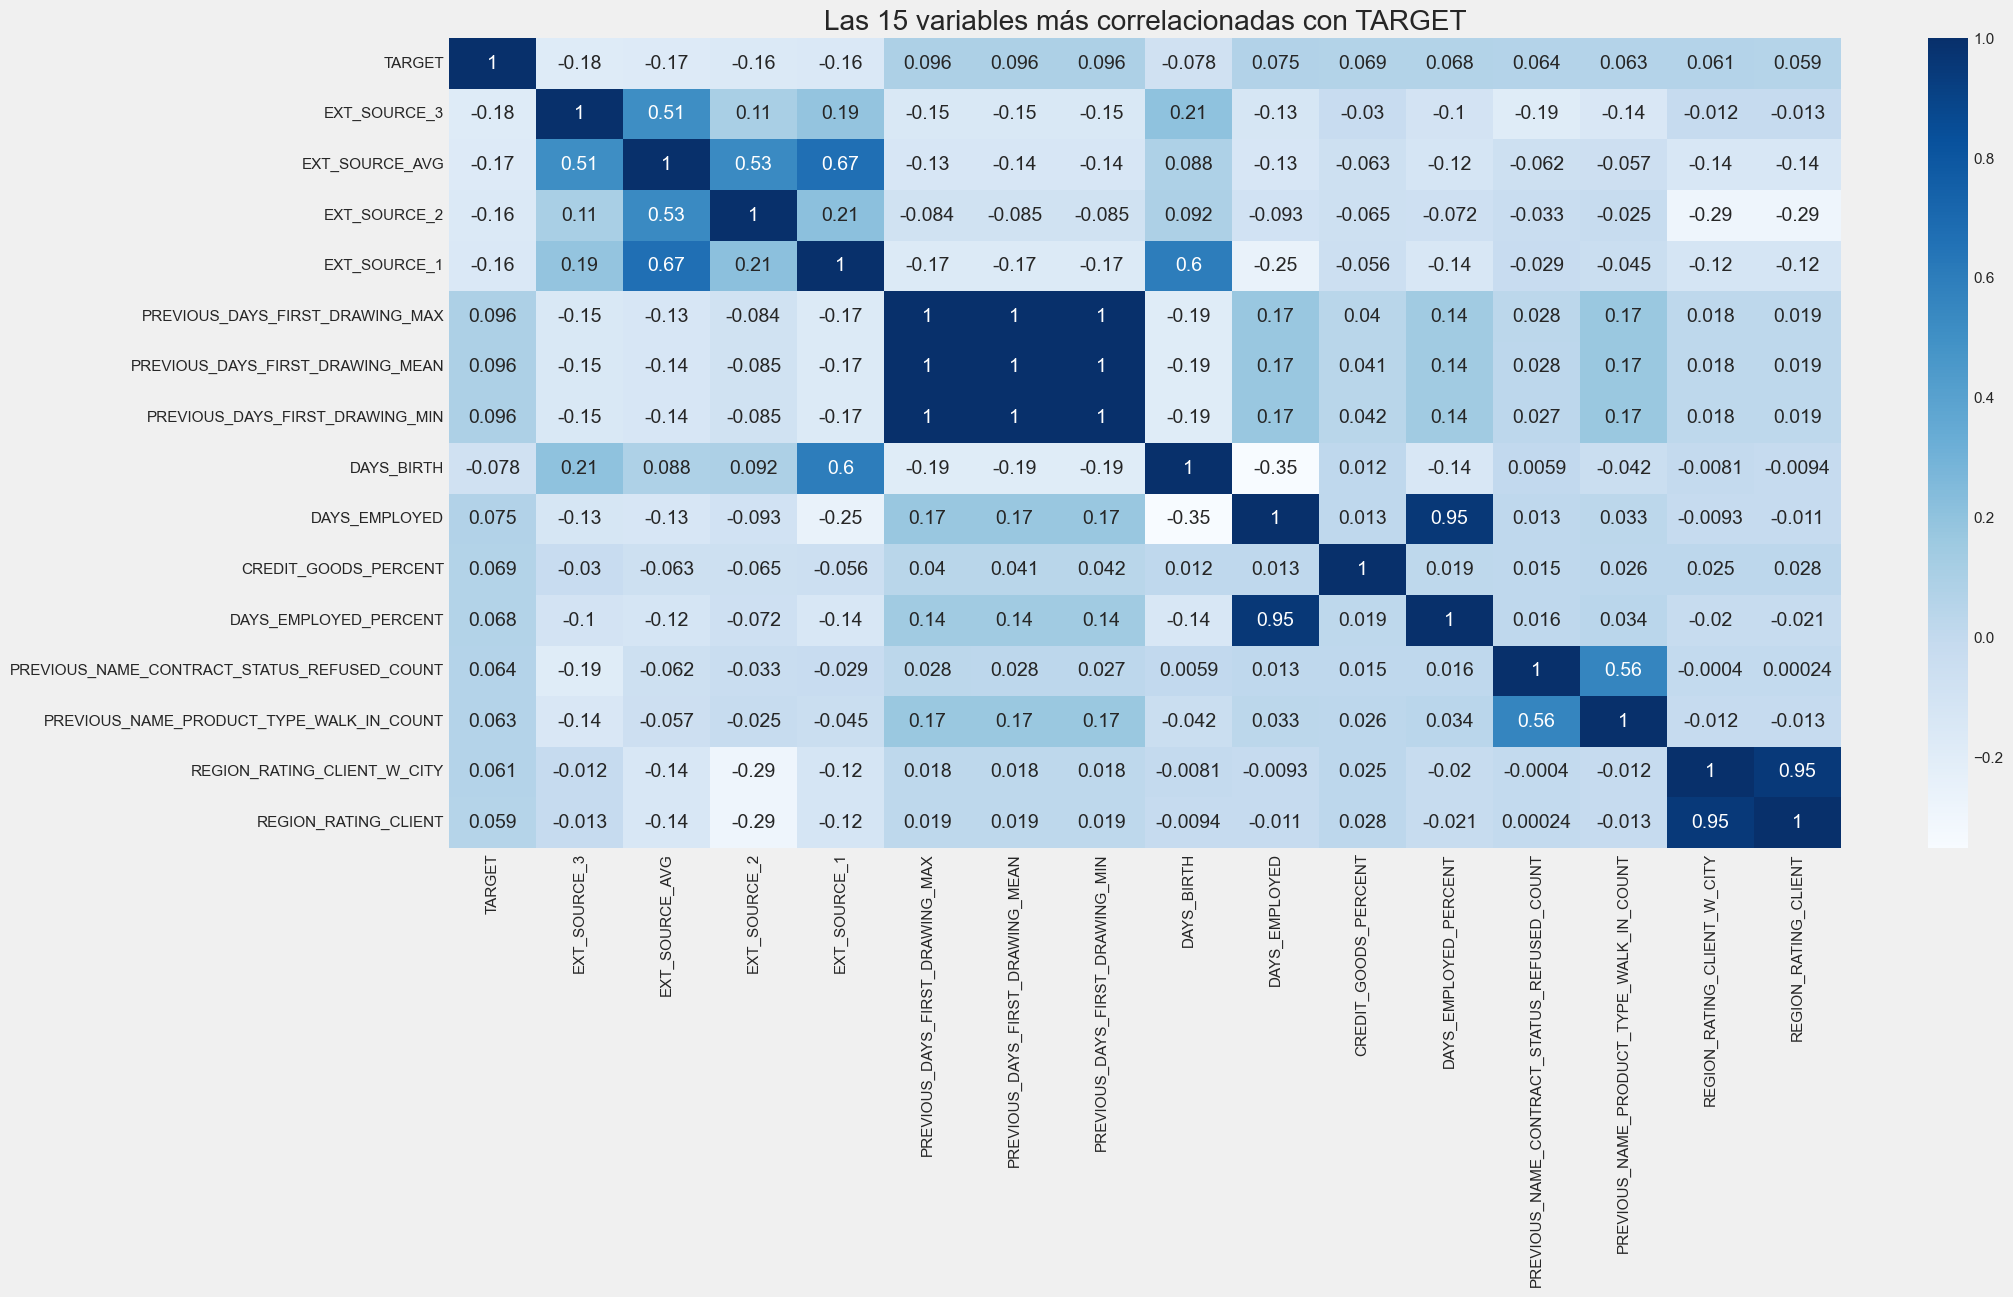

In [283]:
# Calcular la matriz de correlación
corr_matrix = app_train.corr()

# Obtener la correlación absoluta con TARGET
target_corr = abs(corr_matrix['TARGET']).sort_values(ascending=False)

# Seleccionar las 15 variables más correlacionadas con TARGET (incluyendo TARGET misma)
top_features = target_corr.head(16).index.tolist()

# Crear un subconjunto de la matriz de correlación con estas características
top_corr = corr_matrix.loc[top_features, top_features]

# Visualizar el mapa de calor
plt.figure(figsize=(20, 10))
sns.heatmap(top_corr, cmap='Blues', annot=True)
plt.title('Las 15 variables más correlacionadas con TARGET')
plt.show()

In [284]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

# Alinear columnas en train y test

etiquetas_train = app_train['TARGET']

# Alinear los datos de entrenamiento y prueba, mantener solo columnas presentes en ambos dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Volver a añadir la variable objetivo
app_train['TARGET'] = etiquetas_train

print('Dimensiones Features Entrenamiento: ', app_train.shape)
print('Dimensiones Features Test: ', app_test.shape)

Training Features shape:  (307511, 1121)
Testing Features shape:  (48744, 1109)
Dimensiones Features Entrenamiento:  (307511, 1110)
Dimensiones Features Test:  (48744, 1109)


In [ ]:
#show_basic(app_train, 'Training')

##  XII - Preprocesamiento: Eliminación de Variables con Más del 50% de Valores Faltantes

Eliminaremos las variables que tengan más del 50% de valores faltantes.


In [285]:
# Eliminar columnas con más del 80% de valores faltantes

# Total de valores faltantes
mis_val = app_train.isnull().sum()

# Porcentaje de valores faltantes
mis_val_percent = 100 * app_train.isnull().sum() / len(app_train)

# Crear tabla con los resultados
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

# Renombrar las columnas
mis_val_table_ren_columns = mis_val_table.rename(
columns = {0 : 'Valores Faltantes', 1 : '% del Total de Valores'})

# Ordenar la tabla por porcentaje de valores faltantes descendente
mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
'% del Total de Valores', ascending=False).round(1)


missing_train_vars = list(mis_val_table_ren_columns.index[mis_val_table_ren_columns['% del Total de Valores'] > 50])
# display(missing_train_vars)

In [286]:
missing_columns = list(missing_train_vars)

In [287]:
len(missing_train_vars)

423

In [288]:
# Eliminar las columnas con valores faltantes
app_train = app_train.drop(columns = missing_columns)

In [289]:
mis_val_table_ren_columns.head(len(missing_train_vars))

Valores Faltantes  \
BUREAU_ACTIVE_DAYS_ENDDATE_FACT_SUM                      306537   
BUREAU_ACTIVE_DAYS_ENDDATE_FACT_MAX                      306537   
BUREAU_ACTIVE_DAYS_ENDDATE_FACT_MIN                      306537   
CREDIT_CARD_CNT_DRAWINGS_POS_CURRENT_MAX_MIN             305391   
CREDIT_CARD_CNT_DRAWINGS_ATM_CURRENT_MAX_MIN             305391   
...                                                         ...   
ENTRANCES_MODE                                           154828   
ENTRANCES_AVG                                            154828   
LIVINGAREA_MEDI                                          154350   
LIVINGAREA_AVG                                           154350   
LIVINGAREA_MODE                                          154350   

                                              % del Total de Valores  
BUREAU_ACTIVE_DAYS_ENDDATE_FACT_SUM                            99.70  
BUREAU_ACTIVE_DAYS_ENDDATE_FACT_MAX                            99.70  
BUREAU_ACTIVE_DAYS_ENDDATE_FACT_MIN                            99.70  
CREDIT_CARD_CNT_DRAWINGS_POS_CURRENT_MAX_MIN                   99.30  
CREDIT_CARD_CNT_DRAWINGS_ATM_CURRENT_MAX_MIN                   99.30  
...                                                              ...  
ENTRANCES_MODE                                                 50.30  
ENTRANCES_AVG                                                  50.30  
LIVINGAREA_MEDI                                                50.20  
LIVINGAREA_AVG                                                 50.20  
LIVINGAREA_MODE                                                50.20  

[423 rows x 2 columns]

## XIII - Exportación de Datos

Generaremos un archivo que será utilizado en el notebook **Home Credit Default Risk (HCDR) II**

In [290]:
# Escribir a archivo
app_train.to_csv('hcdr.csv', index = False)

In [ ]:
#show_basic(app_train, 'Train - Exported')

In [302]:
# Función para manejar renombrado de columnas para dataframes con MultiIndex, en caso de ser necesario
def rename_multiindex_columns(df, prefix=''):
    columns = ['SK_ID_CURR']
    
    # Verificamos si tenemos un MultiIndex en las columnas
    if hasattr(df.columns, 'levels'):
        # Para MultiIndex
        for var in df.columns.levels[0]:
            if var != 'SK_ID_CURR':
                for stat in df.columns.levels[1]:
                    if var.startswith(prefix):
                        columns.append(f'{var}_{stat.upper()}')
                    else:
                        columns.append(f'{prefix}_{var}_{stat.upper()}')
    else:
        # Para columnas normales
        for col in df.columns:
            if col != 'SK_ID_CURR':
                if col.startswith(prefix):
                    columns.append(f'{col}_SUM')
                else:
                    columns.append(f'{prefix}_{col}_SUM')
    
    # Asegurarnos que el número de columnas coincida
    if len(columns) != len(df.columns):
        print(f"Advertencia: El número de nombres ({len(columns)}) no coincide con el número de columnas ({len(df.columns)})")
        columns = columns[:len(df.columns)]
    
    return columns